# S&P500

In [10]:
# Important libraries
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random
import sklearn
from sklearn.metrics import auc
from matplotlib.gridspec import SubplotSpec
import joblib
import gpflow

# KNN
from scipy.spatial import KDTree

# Cond Gaussian
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.stats import pearsonr

# Weighted
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import weightedcalcs as wc

# Gaussian Copula
from scipy import stats
from scipy.stats import norm, truncnorm

# BNN
import torchbnn as bnn
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
import random

# DER
from lightning.pytorch import Trainer, seed_everything
from lightning import LightningDataModule
from torch_uncertainty.models.mlp import mlp
from torch_uncertainty.losses import DERLoss
from torch_uncertainty.routines import RegressionRoutine
from torch_uncertainty.layers.distributions import NormalInverseGammaLayer
from lightning.pytorch.callbacks import EarlyStopping
import contextlib

data_label = "snp500"
seed = 2023

# File paths
fp_notebooks_folder = "./"
fp_code_folder = "../"
fp_processed_folder = os.path.join(fp_code_folder, "../processed_data")
fp_preprocessed_data_dict = os.path.join(fp_processed_folder, "snp500_data_dict.joblib")
fp_scaler = os.path.join(fp_processed_folder, "snp500_scaler.pkl")

fp_project_checkpoints = os.path.join(fp_code_folder, "checkpoints", data_label)
fp_tuning = os.path.join(fp_project_checkpoints, "tuning")
fp_project_models = os.path.join(fp_project_checkpoints, "models")
fp_project_predictions = os.path.join(fp_project_checkpoints, "predictions")
fp_project_pi_predictions = os.path.join(fp_project_checkpoints, "pi_predictions")
fp_project_model_evaluations = os.path.join(fp_project_checkpoints, "model_evaluation")
fp_project_consolidated_results = os.path.join(fp_project_checkpoints, "consolidated_results")
fp_time_log = os.path.join(fp_project_consolidated_results, "runtime.log")

def create_folder(fp):
    if not os.path.exists(fp):
        os.makedirs(fp)
        return True
    else:
        False

def create_all_seed_folders(cur_seed):
    fp_checkpoint_folders = [fp_project_models, fp_tuning, fp_project_predictions, fp_project_model_evaluations, fp_project_pi_predictions]
    for fp_folder in fp_checkpoint_folders:
        fp = os.path.join(fp_folder, str(cur_seed))
        create_folder(fp)
    print(f"All folders created for seed = {cur_seed}!")

batch_size = 64

feat_days = 5
ori_feat_cols = ["U$", "Mkt-RF", "SMB", "HML", "Mom"]
feat_cols = [f"{feat_col}_day{i}" for i in range(feat_days) for feat_col in ori_feat_cols]

# Create all folders
create_all_seed_folders(seed)
create_folder(fp_project_consolidated_results)

# Check GPU is available
print(tf.config.list_physical_devices('GPU'))

# function to show df
def display_df(df):
    display(df.head())
    print("Shape:", df.shape)

All folders created for seed = 2023!
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


## Load Data

In [11]:
def display_data_dict(data_dict):
    len_df, time_labels = [], []
    splits = ["train_df", "valid_df", "test_df", "outputs"]
    for time_label, time_info_dict in data_dict.items():
        print(time_label)
        stat_dict = {}
        for split_df_name in splits:
            print(f"- {split_df_name}:")
            split_df = time_info_dict[split_df_name]
            if split_df_name == "outputs":
                stat_dict["pred_col"] = split_df[0]
                continue
            display(split_df.head())
            stat_dict[split_df_name] = len(split_df)
        len_df.append(stat_dict)
        time_labels.append(time_label)
    len_df = pd.DataFrame(len_df, index=time_labels)
    display(len_df)
    
data_dict = joblib.load(fp_preprocessed_data_dict)
display_data_dict(data_dict)

t+1
- train_df:


,input_start date,input end date,target_date_t+1,input start index,input end index,target_index_t+1,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,SMB_day3,HML_day3,Mom_day3,U$_day4,Mkt-RF_day4,SMB_day4,HML_day4,Mom_day4,U$_t+1,recession_t+1
0,1964-01-02,1964-01-08,1964-01-09,0,4,5,-0.770049,0.636563,1.183738,1.227446,...,0.141710,1.608279,-0.732825,-0.768612,0.350750,0.102388,-0.363093,-0.063602,-0.767906,False
1,1964-01-03,1964-01-09,1964-01-10,1,5,6,-0.769873,0.163873,0.240015,0.734603,...,0.102388,-0.363093,-0.063602,-0.767906,0.306779,0.063066,-0.833534,0.421585,-0.768007,False
2,1964-01-06,1964-01-10,1964-01-13,2,6,7,-0.769444,0.229830,0.200693,-0.004662,...,0.063066,-0.833534,0.421585,-0.768007,-0.066976,-0.113882,-0.340691,-0.080333,-0.768058,False
3,1964-01-07,1964-01-13,1964-01-14,3,7,8,-0.769394,0.020966,0.141710,1.608279,...,-0.113882,-0.340691,-0.080333,-0.768058,-0.132933,-0.035238,0.936220,0.036782,-0.767705,False
4,1964-01-08,1964-01-14,1964-01-15,4,8,9,-0.768612,0.350750,0.102388,-0.363093,...,-0.035238,0.936220,0.036782,-0.767705,0.141887,-0.703709,1.406662,0.739466,-0.766999,False


- valid_df:


,input_start date,input end date,target_date_t+1,input start index,input end index,target_index_t+1,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,SMB_day3,HML_day3,Mom_day3,U$_day4,Mkt-RF_day4,SMB_day4,HML_day4,Mom_day4,U$_t+1,recession_t+1
10274,2004-10-25,2004-10-29,2004-11-01,10274,10278,10279,1.799705,-0.055983,1.203399,1.115436,...,-0.644726,-0.251083,-1.803583,1.888920,0.174866,-1.116588,0.532985,0.354663,1.889701,False
10275,2004-10-26,2004-11-01,2004-11-02,10275,10279,10280,1.840746,1.472015,-1.313197,1.541073,...,-1.116588,0.532985,0.354663,1.889701,0.042952,0.810181,-0.183877,-0.264369,1.889777,False
10276,2004-10-27,2004-11-02,2004-11-03,10276,10280,10281,1.876820,1.504994,0.770859,-2.513681,...,0.810181,-0.183877,-0.264369,1.889777,-0.033998,-0.330152,-0.071868,-1.100898,1.921692,False
10277,2004-10-28,2004-11-03,2004-11-04,10277,10281,10282,1.881962,0.119902,-0.644726,-0.251083,...,-0.330152,-0.071868,-1.100898,1.921692,1.263152,0.869164,-0.183877,1.241384,1.968253,False
10278,2004-10-29,2004-11-04,2004-11-05,10278,10282,10283,1.888920,0.174866,-1.116588,0.532985,...,0.869164,-0.183877,1.241384,1.968253,1.636907,-1.313197,0.510583,0.337932,1.979597,False


- test_df:


,input_start date,input end date,target_date_t+1,input start index,input end index,target_index_t+1,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,SMB_day3,HML_day3,Mom_day3,U$_day4,Mkt-RF_day4,SMB_day4,HML_day4,Mom_day4,U$_t+1,recession_t+1
11742,2010-08-24,2010-08-30,2010-08-31,11742,11746,11747,1.691458,-1.649939,0.259675,0.286564,...,1.832548,0.779407,0.739466,1.684021,-1.715895,-1.667093,-0.990348,-0.180716,1.685055,False
11743,2010-08-25,2010-08-31,2010-09-01,11743,11747,11748,1.700180,0.471671,2.068479,-0.049466,...,-1.667093,-0.990348,-0.180716,1.685055,-0.012012,-0.546422,1.765093,0.706005,1.763102,False
11744,2010-08-26,2010-09-01,2010-09-02,11744,11748,11749,1.679736,-0.858457,-0.153204,-0.587113,...,-0.546422,1.765093,0.706005,1.763102,3.329798,1.203399,1.003426,0.856580,1.787832,False
11745,2010-08-27,2010-09-02,2010-09-03,11745,11749,11750,1.723524,1.977684,1.832548,0.779407,...,1.203399,1.003426,0.856580,1.787832,1.043296,0.495606,-0.855936,0.421585,1.824158,False
11746,2010-08-30,2010-09-03,2010-09-07,11746,11750,11751,1.684021,-1.715895,-1.667093,-0.990348,...,0.495606,-0.855936,0.421585,1.824158,1.461023,0.652894,0.443377,0.170626,1.792218,False


- outputs:
t+2
- train_df:


,input_start date,input end date,target_date_t+2,input start index,input end index,target_index_t+2,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,SMB_day3,HML_day3,Mom_day3,U$_day4,Mkt-RF_day4,SMB_day4,HML_day4,Mom_day4,U$_t+2,recession_t+2
0,1964-01-02,1964-01-08,1964-01-10,0,4,6,-0.770049,0.636563,1.183738,1.227446,...,0.141710,1.608279,-0.732825,-0.768612,0.350750,0.102388,-0.363093,-0.063602,-0.768007,False
1,1964-01-03,1964-01-09,1964-01-13,1,5,7,-0.769873,0.163873,0.240015,0.734603,...,0.102388,-0.363093,-0.063602,-0.767906,0.306779,0.063066,-0.833534,0.421585,-0.768058,False
2,1964-01-06,1964-01-10,1964-01-14,2,6,8,-0.769444,0.229830,0.200693,-0.004662,...,0.063066,-0.833534,0.421585,-0.768007,-0.066976,-0.113882,-0.340691,-0.080333,-0.767705,False
3,1964-01-07,1964-01-13,1964-01-15,3,7,9,-0.769394,0.020966,0.141710,1.608279,...,-0.113882,-0.340691,-0.080333,-0.768058,-0.132933,-0.035238,0.936220,0.036782,-0.766999,False
4,1964-01-08,1964-01-14,1964-01-16,4,8,10,-0.768612,0.350750,0.102388,-0.363093,...,-0.035238,0.936220,0.036782,-0.767705,0.141887,-0.703709,1.406662,0.739466,-0.767226,False


- valid_df:


,input_start date,input end date,target_date_t+2,input start index,input end index,target_index_t+2,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,SMB_day3,HML_day3,Mom_day3,U$_day4,Mkt-RF_day4,SMB_day4,HML_day4,Mom_day4,U$_t+2,recession_t+2
10273,2004-10-22,2004-10-28,2004-11-01,10273,10277,10279,1.802050,-1.122284,-1.293536,1.496269,...,0.770859,-2.513681,-2.573190,1.881962,0.119902,-0.644726,-0.251083,-1.803583,1.889701,False
10274,2004-10-25,2004-10-29,2004-11-02,10274,10278,10280,1.799705,-0.055983,1.203399,1.115436,...,-0.644726,-0.251083,-1.803583,1.888920,0.174866,-1.116588,0.532985,0.354663,1.889777,False
10275,2004-10-26,2004-11-01,2004-11-03,10275,10279,10281,1.840746,1.472015,-1.313197,1.541073,...,-1.116588,0.532985,0.354663,1.889701,0.042952,0.810181,-0.183877,-0.264369,1.921692,False
10276,2004-10-27,2004-11-02,2004-11-04,10276,10280,10282,1.876820,1.504994,0.770859,-2.513681,...,0.810181,-0.183877,-0.264369,1.889777,-0.033998,-0.330152,-0.071868,-1.100898,1.968253,False
10277,2004-10-28,2004-11-03,2004-11-05,10277,10281,10283,1.881962,0.119902,-0.644726,-0.251083,...,-0.330152,-0.071868,-1.100898,1.921692,1.263152,0.869164,-0.183877,1.241384,1.979597,False


- test_df:


,input_start date,input end date,target_date_t+2,input start index,input end index,target_index_t+2,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,SMB_day3,HML_day3,Mom_day3,U$_day4,Mkt-RF_day4,SMB_day4,HML_day4,Mom_day4,U$_t+2,recession_t+2
11741,2010-08-23,2010-08-27,2010-08-31,11741,11745,11747,1.730507,-0.572645,-1.863702,-0.945544,...,-0.153204,-0.587113,0.555430,1.723524,1.977684,1.832548,0.779407,0.739466,1.685055,False
11742,2010-08-24,2010-08-30,2010-09-01,11742,11746,11748,1.691458,-1.649939,0.259675,0.286564,...,1.832548,0.779407,0.739466,1.684021,-1.715895,-1.667093,-0.990348,-0.180716,1.763102,False
11743,2010-08-25,2010-08-31,2010-09-02,11743,11747,11749,1.700180,0.471671,2.068479,-0.049466,...,-1.667093,-0.990348,-0.180716,1.685055,-0.012012,-0.546422,1.765093,0.706005,1.787832,False
11744,2010-08-26,2010-09-01,2010-09-03,11744,11748,11750,1.679736,-0.858457,-0.153204,-0.587113,...,-0.546422,1.765093,0.706005,1.763102,3.329798,1.203399,1.003426,0.856580,1.824158,False
11745,2010-08-27,2010-09-02,2010-09-07,11745,11749,11751,1.723524,1.977684,1.832548,0.779407,...,1.203399,1.003426,0.856580,1.787832,1.043296,0.495606,-0.855936,0.421585,1.792218,False


- outputs:
t+3
- train_df:


,input_start date,input end date,target_date_t+3,input start index,input end index,target_index_t+3,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,SMB_day3,HML_day3,Mom_day3,U$_day4,Mkt-RF_day4,SMB_day4,HML_day4,Mom_day4,U$_t+3,recession_t+3
0,1964-01-02,1964-01-08,1964-01-13,0,4,7,-0.770049,0.636563,1.183738,1.227446,...,0.141710,1.608279,-0.732825,-0.768612,0.350750,0.102388,-0.363093,-0.063602,-0.768058,False
1,1964-01-03,1964-01-09,1964-01-14,1,5,8,-0.769873,0.163873,0.240015,0.734603,...,0.102388,-0.363093,-0.063602,-0.767906,0.306779,0.063066,-0.833534,0.421585,-0.767705,False
2,1964-01-06,1964-01-10,1964-01-15,2,6,9,-0.769444,0.229830,0.200693,-0.004662,...,0.063066,-0.833534,0.421585,-0.768007,-0.066976,-0.113882,-0.340691,-0.080333,-0.766999,False
3,1964-01-07,1964-01-13,1964-01-16,3,7,10,-0.769394,0.020966,0.141710,1.608279,...,-0.113882,-0.340691,-0.080333,-0.768058,-0.132933,-0.035238,0.936220,0.036782,-0.767226,False
4,1964-01-08,1964-01-14,1964-01-17,4,8,11,-0.768612,0.350750,0.102388,-0.363093,...,-0.035238,0.936220,0.036782,-0.767705,0.141887,-0.703709,1.406662,0.739466,-0.767200,False


- valid_df:


,input_start date,input end date,target_date_t+3,input start index,input end index,target_index_t+3,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,SMB_day3,HML_day3,Mom_day3,U$_day4,Mkt-RF_day4,SMB_day4,HML_day4,Mom_day4,U$_t+3,recession_t+3
10272,2004-10-21,2004-10-27,2004-11-01,10272,10276,10279,1.829149,0.383729,1.341025,0.084946,...,-1.313197,1.541073,0.220818,1.876820,1.504994,0.770859,-2.513681,-2.573190,1.889701,False
10273,2004-10-22,2004-10-28,2004-11-02,10273,10277,10280,1.802050,-1.122284,-1.293536,1.496269,...,0.770859,-2.513681,-2.573190,1.881962,0.119902,-0.644726,-0.251083,-1.803583,1.889777,False
10274,2004-10-25,2004-10-29,2004-11-03,10274,10278,10281,1.799705,-0.055983,1.203399,1.115436,...,-0.644726,-0.251083,-1.803583,1.888920,0.174866,-1.116588,0.532985,0.354663,1.921692,False
10275,2004-10-26,2004-11-01,2004-11-04,10275,10279,10282,1.840746,1.472015,-1.313197,1.541073,...,-1.116588,0.532985,0.354663,1.889701,0.042952,0.810181,-0.183877,-0.264369,1.968253,False
10276,2004-10-27,2004-11-02,2004-11-05,10276,10280,10283,1.876820,1.504994,0.770859,-2.513681,...,0.810181,-0.183877,-0.264369,1.889777,-0.033998,-0.330152,-0.071868,-1.100898,1.979597,False


- test_df:


,input_start date,input end date,target_date_t+3,input start index,input end index,target_index_t+3,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,SMB_day3,HML_day3,Mom_day3,U$_day4,Mkt-RF_day4,SMB_day4,HML_day4,Mom_day4,U$_t+3,recession_t+3
11740,2010-08-20,2010-08-26,2010-08-31,11740,11744,11747,1.741422,-0.330803,0.534928,-0.564711,...,2.068479,-0.049466,0.003320,1.679736,-0.858457,-0.153204,-0.587113,0.555430,1.685055,False
11741,2010-08-23,2010-08-27,2010-09-01,11741,11745,11748,1.730507,-0.572645,-1.863702,-0.945544,...,-0.153204,-0.587113,0.555430,1.723524,1.977684,1.832548,0.779407,0.739466,1.763102,False
11742,2010-08-24,2010-08-30,2010-09-02,11742,11746,11749,1.691458,-1.649939,0.259675,0.286564,...,1.832548,0.779407,0.739466,1.684021,-1.715895,-1.667093,-0.990348,-0.180716,1.787832,False
11743,2010-08-25,2010-08-31,2010-09-03,11743,11747,11750,1.700180,0.471671,2.068479,-0.049466,...,-1.667093,-0.990348,-0.180716,1.685055,-0.012012,-0.546422,1.765093,0.706005,1.824158,False
11744,2010-08-26,2010-09-01,2010-09-07,11744,11748,11751,1.679736,-0.858457,-0.153204,-0.587113,...,-0.546422,1.765093,0.706005,1.763102,3.329798,1.203399,1.003426,0.856580,1.792218,False


- outputs:


,train_df,valid_df,test_df,pred_col
t+1,10274,1468,2935,U$_t+1
t+2,10273,1468,2936,U$_t+2
t+3,10272,1468,2937,U$_t+3


In [7]:
print("Feature Columns:", feat_cols)

Feature Columns: ['U$_day0', 'Mkt-RF_day0', 'SMB_day0', 'HML_day0', 'Mom_day0', 'U$_day1', 'Mkt-RF_day1', 'SMB_day1', 'HML_day1', 'Mom_day1', 'U$_day2', 'Mkt-RF_day2', 'SMB_day2', 'HML_day2', 'Mom_day2', 'U$_day3', 'Mkt-RF_day3', 'SMB_day3', 'HML_day3', 'Mom_day3', 'U$_day4', 'Mkt-RF_day4', 'SMB_day4', 'HML_day4', 'Mom_day4']


## Timer Function

In [14]:
class Timer:
    def __init__(self, seed):
        self.seed = seed

    def restart_timer(self):
        self.description = None
        self.start_time = None
        self.end_time = None
        self.duration = None
        
    def start(self, description):
        self.restart_timer()
        self.description = description
        self.start_time = time.time()

    def end(self):
        self.end_time = time.time()
        self.duration = self.end_time-self.start_time
        print(f"{self.description} took {self.duration}s. ")
        self._log_time()

    def _log_time(self):
        with open(fp_time_log, "a+") as myfile:
            myfile.write(f"{self.seed},{self.description},{self.duration}\n")

## RUE

In [30]:
def set_seed(seed):
    tf.config.experimental.enable_op_determinism()
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def display_history(history, show_acc=False):
    if show_acc:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 2.5))
        axes[0].plot(history.history['loss'])
        axes[0].plot(history.history['val_loss'])
        axes[0].set_title('Model Loss')
        axes[0].set_ylabel('Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Val'], loc='upper left')
        axes[1].plot(history.history['accuracy'])
        axes[1].plot(history.history['val_accuracy'])
        axes[1].set_title('Model Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Val'], loc='upper left')
        axes[2].plot(history.history['f1_score'])
        axes[2].plot(history.history['val_f1_score'])
        axes[2].set_title('Model F1 Score')
        axes[2].set_ylabel('F1 Score')
        axes[2].set_xlabel('Epoch')
        axes[2].legend(['Train', 'Val'], loc='upper left')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.5))
        axes.plot(history.history['loss'])
        axes.plot(history.history['val_loss'])
        axes.set_title('Model Loss')
        axes.set_ylabel('Loss')
        axes.set_xlabel('Epoch')
        axes.legend(['Train', 'Val'], loc='upper left')
    plt.tight_layout()
    plt.show()

from keras import regularizers

class AE_Regressor:
    def __init__(self, encoder_width, encoder_depth, decoder_width, decoder_depth, predictors, output_features):
        from keras.layers import Dense, Dropout
        self.predictors = predictors
        self.output_features = output_features
        self.num_predictors = len(self.predictors)
        self.num_outputs = len(self.output_features)
        self.encoder_width = encoder_width
        self.encoder_depth = encoder_depth
        self.decoder_width = decoder_width
        self.decoder_depth = decoder_depth
        
        # Instantiate model layers
        self.inputs = tf.keras.Input(shape=(self.num_predictors,))
        self.encoder = tf.keras.Sequential(list(
            Dense(self.encoder_width, "relu") for i in range(self.encoder_depth) # , kernel_regularizer="l2"
        ), name="encoder")
        self.decoder = tf.keras.Sequential([
            Dense(self.decoder_width, "relu", kernel_regularizer="l1") for i in range(self.decoder_depth-1) # , kernel_regularizer="l2", tf.keras.regularizers.L2(l2=0.1)
        ]+[Dense(self.num_predictors)], name="decoder")
        self.regressor = tf.keras.Sequential([
            Dropout(rate=0.2),
            Dense(self.num_outputs)
        ], name="regressor")
    
    # Smote is external
    def train_regressor(
        self, train_X, train_y, val_X, val_y, batch_size, max_epochs, verbose, patience):
        from tensorflow.keras.callbacks import EarlyStopping
        # Define regressor
        pred = self.encoder(self.inputs)
        pred = self.regressor(pred)
        self.predictor = tf.keras.Model(inputs=self.inputs, outputs=pred, name="regression_model")
        # Train predictor
        self.predictor.compile(
            loss="mse",
            optimizer=tf.keras.optimizers.Adam()
        )
        es = EarlyStopping(
            monitor='val_loss', mode='min', verbose=1, patience=patience, restore_best_weights=True)
        self.predictor_history = self.predictor.fit(
            train_X, train_y, 
            epochs=max_epochs, 
            validation_data=(val_X, val_y),
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[es],
        )
        print("- Regressor Training History")
        display_history(self.predictor_history)
        best_index = np.argmin(self.predictor_history.history['val_loss'])
        return (
            self.predictor_history.history['val_loss'][best_index], 
            best_index
        )
        
    def train_decoder(
        self, train_X, val_X, batch_size, max_epochs, verbose, patience):
        from tensorflow.keras.callbacks import EarlyStopping
        # Define AE
        self.encoder.trainable=False # Freeze weights
        x = self.encoder(self.inputs)
        x = self.decoder(x)
        self.ae = tf.keras.Model(inputs=self.inputs, outputs=x, name="ae_model")
        # Train AE
        self.ae.compile(
            loss="mae",
            optimizer=tf.keras.optimizers.Adam()
        )
        es = EarlyStopping(
            monitor='val_loss', mode='min', verbose=1, patience=patience, restore_best_weights=True)
        self.ae_history = self.ae.fit(
            train_X, train_X, 
            epochs=max_epochs, 
            validation_data=(val_X, val_X),
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[es]
        )
        print("- Autoencoder Training History")
        display_history(self.ae_history)
        best_epoch = np.argmin(self.ae_history.history['val_loss'])
        return self.ae_history.history['val_loss'][best_epoch], best_epoch

    def replace_encoder_predictor(self, prev_model):
        self.encoder = prev_model.encoder
        self.regressor = prev_model.regressor
        self.encoder_width = prev_model.encoder_width
        self.encoder_depth = prev_model.encoder_depth

    def predict(self, inputs, with_mae=True, weighted=False, dropout_activated=False):
        # Encode
        encoder_output = self.encoder(inputs)
        
        # Get forecast result
        regressor_output = self.regressor(encoder_output, training=dropout_activated)
        if with_mae:
            # Reconstruct
            decoder_output = self.decoder(encoder_output)
            return regressor_output, decoder_output
        else:
            return regressor_output

    def get_config(self):
        return dict(
            encoder_width=self.encoder_width, 
            encoder_depth=self.encoder_depth, 
            decoder_width=self.decoder_width, 
            decoder_depth=self.decoder_depth, 
            predictors=self.predictors, 
            output_features=self.output_features
        )
        
def save_model(model, name, fp_checkpoints, override=False):
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    if os.path.exists(model_folder):
        print("Model checkpoint already exists!")
        if not override:
            return
    else:
        os.makedirs(model_folder)
    
    # Save Parameters
    parameters_to_save = model.get_config()
    parameter_filename = os.path.join(fp_checkpoints, name, "parameters.pickle")
    with open(parameter_filename, 'wb') as handle:
        pickle.dump(parameters_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save Model
    inputs = model.inputs
    encoder_output = model.encoder(inputs)
    decoder_output = model.decoder(encoder_output)
    regressor_output = model.regressor(encoder_output)
    model = tf.keras.Model(inputs, [regressor_output, decoder_output])
    model_filename = os.path.join(fp_checkpoints, name, "model.h5")
    model.save(model_filename)
    print("Model saved!")

def load_model(name, fp_checkpoints): 
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    parameter_filename = os.path.join(fp_checkpoints, name, "parameters.pickle")
    model_filename = os.path.join(fp_checkpoints, name, "model.h5")
    
    if not os.path.exists(model_folder):
        print("model checkpoint does not exist!")
        return
    model = tf.keras.models.load_model(model_filename)
    with open(parameter_filename, 'rb') as handle:
        parameters = pickle.load(handle)
    
    ae_regressor = AE_Regressor(**parameters)
    ae_regressor.encoder = model.get_layer("encoder")
    ae_regressor.decoder = model.get_layer("decoder")
    ae_regressor.regressor = model.get_layer("regressor")
    
    return ae_regressor

def model_tuning_regressor(
    param_grid, predictors, pred_cols, train_df, valid_df, seed,
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    loss_list = []
    epoch_list = []
    time_spent_list = []
    tuning_df_list = []
    parameter_list = list(ParameterGrid(param_grid))
    pbar = tqdm(parameter_list)
    for param_dict in pbar:
        pbar.set_description(f"{param_dict}")
        set_seed(seed)
        regressor = AE_Regressor(**param_dict, predictors=predictors, output_features=pred_cols)
        start = time.time()
        val_loss, best_epoch = regressor.train_regressor(
            train_X, train_y, valid_X, valid_y, batch_size, max_epochs, verbose, patience)
        cur_param_dict = param_dict.copy()
        cur_param_dict["loss"] = val_loss
        cur_param_dict["epochs"] = best_epoch
        cur_param_dict["time/s"] = time.time()-start
        tuning_df_list.append(cur_param_dict)
    tuning_df = pd.DataFrame(tuning_df_list)
    best_param_idx = tuning_df['loss'].idxmin()
    tuning_df["best_hyperparameter"] = [True if i==best_param_idx else False for i in range(len(tuning_df))]
    best_param = parameter_list[best_param_idx]
    return tuning_df, best_param

def get_model_error_corr(predictor, x, y):
    y_pred, x_pred = predictor.predict(x)
    rue = np.mean(np.abs(x-x_pred), axis=-1)
    mae = np.mean(np.abs(y-y_pred), axis=-1)
    corr, pvalue = pearsonr(mae, rue)
    return corr

def model_tuning_decoder(
    param_grid, predictors, pred_cols, train_df, valid_df, seed, prev_model,
    atch_size=128, max_epochs=5000, verbose=1, patience=10):
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    tuning_df_list = []
    parameter_list = list(ParameterGrid(param_grid))
    best_corr = -np.inf
    pbar = tqdm(parameter_list)
    for param_dict in pbar:
        pbar.set_description(f"{param_dict}, best corr: {best_corr:.5f}")
        set_seed(seed)
        predictor = AE_Regressor(**param_dict, predictors=predictors, output_features=pred_cols)
        predictor.replace_encoder_predictor(prev_model)
        start = time.time()
        val_loss, best_epoch = predictor.train_decoder(
            train_X, valid_X, batch_size, max_epochs, verbose, patience)
        timing = time.time()-start
        corr = get_model_error_corr(predictor, valid_X, valid_y)
        cur_param_dict = param_dict.copy()
        cur_param_dict["loss"] = val_loss
        cur_param_dict["corr"] = corr
        cur_param_dict["epochs"] = best_epoch
        cur_param_dict["time/s"] = timing
        tuning_df_list.append(cur_param_dict)
        best_corr = max(corr, best_corr)
    tuning_df = pd.DataFrame(tuning_df_list)
    best_param_idx = tuning_df["corr"].idxmax()
    tuning_df["best_hyperparameter"] = [True if i==best_param_idx else False for i in range(len(tuning_df))]
    best_param = parameter_list[best_param_idx]
    return tuning_df, best_param

def model_training(
    hp_dict, predictors, pred_cols, train_df, valid_df, seed,
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    set_seed(seed)
    timer = Timer(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    
    # Train Regressor
    ae_regressor = AE_Regressor(**hp_dict, predictors=predictors, output_features=pred_cols)
    timer.start(description="Training Encoder and Predictor")
    valid_loss_regressor, best_epoch = ae_regressor.train_regressor(
        train_X, train_y, valid_X, valid_y, 
        batch_size, max_epochs, verbose, patience)
    timer.end()
    
    # Train decoder
    timer.start(description="Training Decoder")
    valid_loss_ae = ae_regressor.train_decoder(
        train_X, valid_X, batch_size, max_epochs, verbose, patience)
    timer.end()
    return ae_regressor

def model_training_predictor(
    hp_dict, predictors, pred_cols, train_df, valid_df, seed,
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    
    from tqdm import tqdm
    import time
    set_seed(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    
    # Train Regressor
    ae_regressor = AE_Regressor(**hp_dict, predictors=predictors, output_features=pred_cols)
    
    start = time.time()
    # Train classifier
    valid_loss_regressor, best_epoch = ae_regressor.train_regressor(
        train_X, train_y, valid_X, valid_y, 
        batch_size, max_epochs, verbose, patience)
    
    # Train decoder
    # valid_loss_ae = ae_regressor.train_decoder(
    #     train_X, valid_X, batch_size, max_epochs, verbose, patience)
    
    print(f"Training took {time.time()-start}s.")
    return ae_regressor

def model_training_decoder(
    hp_dict, predictors, pred_cols, train_df, valid_df, seed, prev_model, 
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    
    from tqdm import tqdm
    import time
    set_seed(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    
    # Train Regressor
    ae_regressor = AE_Regressor(**hp_dict, predictors=predictors, output_features=pred_cols)
    ae_regressor.replace_encoder_predictor(prev_model)
    
    start = time.time()
    # Train classifier
    # valid_loss_regressor, best_epoch = ae_regressor.train_regressor(
    #     train_X, train_y, valid_X, valid_y, 
    #     batch_size, max_epochs, verbose, patience)
    
    # Train decoder
    valid_loss_ae = ae_regressor.train_decoder(
        train_X, valid_X, batch_size, max_epochs, verbose, patience)
    
    print(f"Training took {time.time()-start}s.")
    return ae_regressor

def model_test_predictions(
    ae_regressor, df_train, df_test, pred_cols, predictors, regressor_label, pred_min, T=10, seed=seed):
    df_test = df_test.copy()
    set_seed(seed)
    timer = Timer(seed)
    test_X, test_y = (
        df_test[predictors].values.astype('float32'), df_test[pred_cols].values.astype('float32'))
    
    # MAE
    timer.start(description="Predicting with Decoder + Predictor")
    test_y_pred, test_X_reconstruction = ae_regressor.predict(inputs=test_X)
    timer.end()
    # - Add to df
    predicted_colnames = [col+"_direct"+regressor_label for col in pred_cols]
    reconstruction_colnames = [col+"_reconstruction"+regressor_label for col in predictors]
    rue_colname = "rue"
    df_test[predicted_colnames] = test_y_pred
    df_test[reconstruction_colnames] = test_X_reconstruction
    df_test[rue_colname] = np.mean(np.abs(test_X_reconstruction-test_X), axis=1)
    
    # For MC Dropout
    # - Sample with dropout
    timer.start(description="Predicting with MC Dropout")
    test_y_sample_preds = []
    for i in range(T):
        test_y_pred = ae_regressor.predict(inputs=test_X, dropout_activated=True, with_mae=False)
        test_y_sample_preds.append(test_y_pred)
    timer.end()
    test_y_sample_preds = np.array(test_y_sample_preds)
    test_y_sample_preds =  test_y_sample_preds.transpose((1, 2, 0))
    # - Get mean and std of all sample predictions
    test_y_mean_pred = np.mean(test_y_sample_preds, axis=-1)
    test_y_std_pred = np.std(test_y_sample_preds, axis=-1, ddof=1)

    # - Add to df
    predicted_mean_colnames = [col+"_mean"+regressor_label for col in pred_cols]
    predicted_std_colnames = [col+"_std"+regressor_label for col in pred_cols]
    mcd_colname = "mcd"
    df_test[predicted_mean_colnames] = test_y_mean_pred
    df_test[predicted_std_colnames] = test_y_std_pred
    df_test[mcd_colname] = np.mean(test_y_std_pred, axis=-1)
    
    return df_test

### Tune and Train Predictor

#### Tune Predictor

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000


I0000 00:00:1729657456.931017 2200513 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729657456.931326 2200513 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729657456.931581 2200513 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729657456.931837 2200513 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

110/161 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.3424 

2024-10-23 11:24:17.990232: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1729657458.083432 2206017 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2727 - val_loss: 0.0347
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.0369 - val_loss: 0.0187
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0257 - val_loss: 0.0140
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0184 - val_loss: 0.0132
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0138 - val_loss: 0.0068
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.0104 - val_loss: 0.0063
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0096 - val_loss: 0.0096
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0087 - val_loss: 0.0118
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0073 - val_loss: 0.0042
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.0062 - val_loss: 0.0041
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0056 - val_loss: 0.0051
Epoch 12/1000

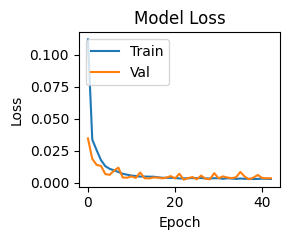

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2661 - val_loss: 0.0271
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 0.0235 - val_loss: 0.0173
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.0166 - val_loss: 0.0126
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.0119 - val_loss: 0.0131
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 0.0097 - val_loss: 0.0068
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.0079 - val_loss: 0.0067
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.0060 - val_loss: 0.0058
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.0055 - val_loss: 0.0044
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.0047 - val_loss: 0.0058
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.0042 - val_loss: 0.0045

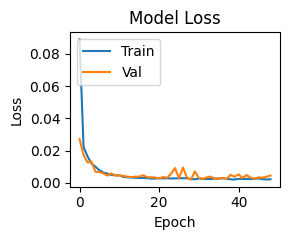

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1570 - val_loss: 0.0244
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0167 - val_loss: 0.0459
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0117 - val_loss: 0.0067
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0076 - val_loss: 0.0074
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 0.0059 - val_loss: 0.0062
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.0045 - val_loss: 0.0050
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.0043 - val_loss: 0.0063
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.0038 - val_loss: 0.0042
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.0037 - val_loss: 0.0042
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 0.0025 - val_loss: 0.0077

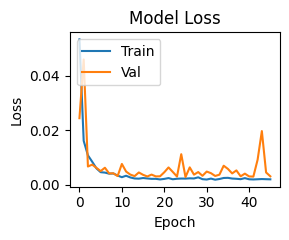

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1207 - val_loss: 0.0185
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0163 - val_loss: 0.0200
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 0.0132 - val_loss: 0.0117
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0101 - val_loss: 0.0179
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.0077 - val_loss: 0.0079
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0077 - val_loss: 0.0310
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0063 - val_loss: 0.0247
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 0.0059 - val_loss: 0.0126
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.0055 - val_loss: 0.0076
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0056 - val_loss: 0.0060
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.0050 - val_loss: 0.0057

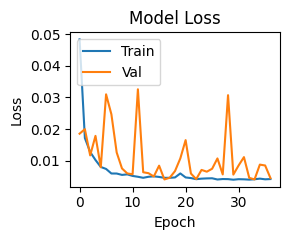

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0918 - val_loss: 0.0156
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0127 - val_loss: 0.0120
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0089 - val_loss: 0.0090
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.0076 - val_loss: 0.0162
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0068 - val_loss: 0.0073
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.0060 - val_loss: 0.0053
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0050 - val_loss: 0.0076
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0049 - val_loss: 0.0067
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0039 - val_loss: 0.0051
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0031 - val_loss: 0.0041

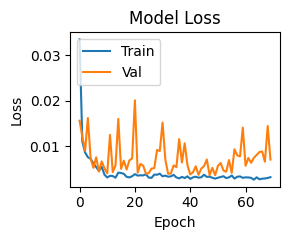

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1137 - val_loss: 0.0136
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.0114 - val_loss: 0.0272
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0091 - val_loss: 0.0187
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0075 - val_loss: 0.0126
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0056 - val_loss: 0.0209
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.0045 - val_loss: 0.0092
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0036 - val_loss: 0.0081
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.0033 - val_loss: 0.0048
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0033 - val_loss: 0.0057
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.0034 - val_loss: 0.0150

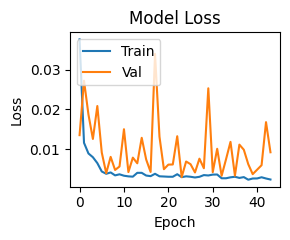

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1163 - val_loss: 0.0229
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0117 - val_loss: 0.0118
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.0086 - val_loss: 0.0195
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0073 - val_loss: 0.0147
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.0067 - val_loss: 0.0158
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0067 - val_loss: 0.0256
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0061 - val_loss: 0.0132
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0057 - val_loss: 0.0070
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.0052 - val_loss: 0.0128
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0056 - val_loss: 0.0156
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.0049 - val_loss: 0.0085

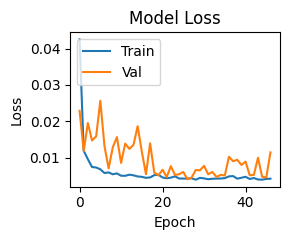

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0886 - val_loss: 0.0161
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0104 - val_loss: 0.0205
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0069 - val_loss: 0.0138
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 0.0049 - val_loss: 0.0096
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0045 - val_loss: 0.0151
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 0.0049 - val_loss: 0.0141
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.0047 - val_loss: 0.0051
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 0.0041 - val_loss: 0.0058
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.0041 - val_loss: 0.0064
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.0045 - val_loss: 0.0137
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.0038 - val_loss: 0.0069

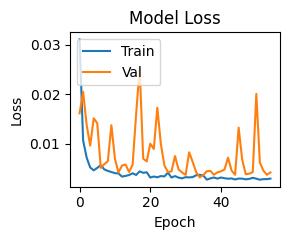

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1219 - val_loss: 0.0102
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0090 - val_loss: 0.0188
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.0060 - val_loss: 0.0247
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.0041 - val_loss: 0.0072
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0048 - val_loss: 0.0232
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.0060 - val_loss: 0.0063
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0033 - val_loss: 0.0178
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0035 - val_loss: 0.0111
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0028 - val_loss: 0.0059
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0025 - val_loss: 0.0077

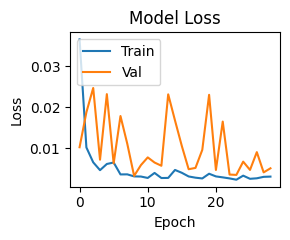

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,epochs,time/s,best_hyperparameter
0,2,128,1,256,0.002492,22,7.249279,False
1,2,128,1,512,0.001914,28,7.873470,True
2,2,128,1,1028,0.002853,25,7.501477,False
3,2,128,2,256,0.004083,16,7.224357,False
4,2,128,2,512,0.003654,49,11.863265,False
5,2,128,2,1028,0.003044,23,8.119690,False
6,2,128,3,256,0.003995,26,9.005495,False
7,2,128,3,512,0.003150,34,10.245044,False
8,2,128,3,1028,0.003220,8,6.487299,False


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2836 - val_loss: 0.0300
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0380 - val_loss: 0.0225
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 0.0259 - val_loss: 0.0158
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0211 - val_loss: 0.0126
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.0149 - val_loss: 0.0093
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.0121 - val_loss: 0.0076
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0095 - val_loss: 0.0073
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0089 - val_loss: 0.0068
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0074 - val_loss: 0.0052
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0069 - val_loss: 0.0065
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0065 - val_loss: 0.0052

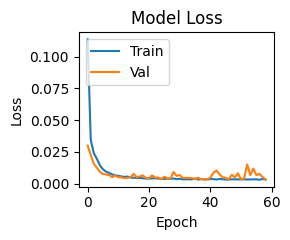

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2545 - val_loss: 0.0228
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.0233 - val_loss: 0.0159
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.0166 - val_loss: 0.0132
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.0136 - val_loss: 0.0108
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.0104 - val_loss: 0.0091
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.0082 - val_loss: 0.0071
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 0.0080 - val_loss: 0.0055
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.0063 - val_loss: 0.0052
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 0.0052 - val_loss: 0.0052
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.0042 - val_loss: 0.0053
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.0041 - val_loss: 0.0057

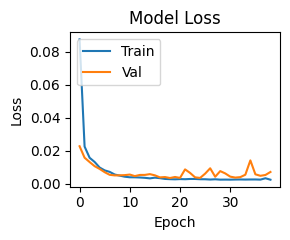

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1460 - val_loss: 0.0187
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.0164 - val_loss: 0.0230
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 0.0118 - val_loss: 0.0162
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.0087 - val_loss: 0.0074
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.0073 - val_loss: 0.0061
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.0055 - val_loss: 0.0058
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.0037 - val_loss: 0.0048
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0035 - val_loss: 0.0048
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0034 - val_loss: 0.0054
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.0030 - val_loss: 0.0050

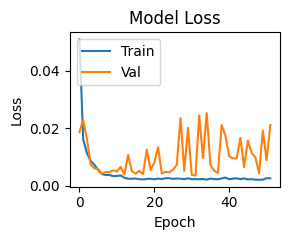

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1193 - val_loss: 0.0264
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.0174 - val_loss: 0.0168
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.0114 - val_loss: 0.0137
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0088 - val_loss: 0.0115
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0082 - val_loss: 0.0148
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.0078 - val_loss: 0.0089
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0074 - val_loss: 0.0107
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0065 - val_loss: 0.0397
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.0064 - val_loss: 0.0095
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.0054 - val_loss: 0.0082
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0051 - val_loss: 0.0173

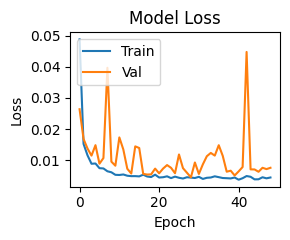

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0825 - val_loss: 0.0393
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.0124 - val_loss: 0.0111
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0099 - val_loss: 0.0107
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0078 - val_loss: 0.0254
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0072 - val_loss: 0.0126
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 0.0056 - val_loss: 0.0084
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.0047 - val_loss: 0.0115
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0047 - val_loss: 0.0075
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0048 - val_loss: 0.0061
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0044 - val_loss: 0.0231
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0044 - val_loss: 0.0077

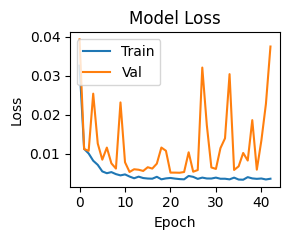

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0893 - val_loss: 0.0148
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.0110 - val_loss: 0.0153
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0076 - val_loss: 0.0100
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.0060 - val_loss: 0.0067
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.0057 - val_loss: 0.0068
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0049 - val_loss: 0.0089
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.0044 - val_loss: 0.0250
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0051 - val_loss: 0.0046
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0042 - val_loss: 0.0070
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.0036 - val_loss: 0.0142
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.0035 - val_loss: 0.0319

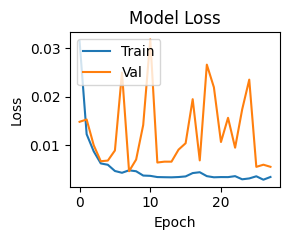

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1176 - val_loss: 0.0241
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0144 - val_loss: 0.0165
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0099 - val_loss: 0.0215
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0085 - val_loss: 0.0151
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0075 - val_loss: 0.0141
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 0.0068 - val_loss: 0.0180
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0069 - val_loss: 0.0115
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0068 - val_loss: 0.0084
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.0061 - val_loss: 0.0339
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.0061 - val_loss: 0.0102
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.0060 - val_loss: 0.0085

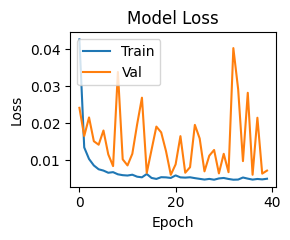

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0844 - val_loss: 0.0185
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0092 - val_loss: 0.0104
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.0068 - val_loss: 0.0337
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.0072 - val_loss: 0.0122
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.0054 - val_loss: 0.0080
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0046 - val_loss: 0.0075
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0046 - val_loss: 0.0107
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 0.0042 - val_loss: 0.0090
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.0038 - val_loss: 0.0078
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0037 - val_loss: 0.0121
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.0036 - val_loss: 0.0074

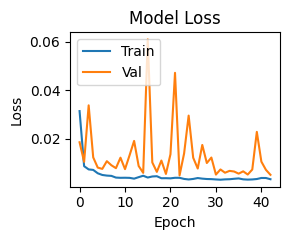

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1245 - val_loss: 0.0408
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.0078 - val_loss: 0.0072
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 0.0056 - val_loss: 0.0066
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.0048 - val_loss: 0.0210
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.0051 - val_loss: 0.0074
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.0040 - val_loss: 0.0165
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.0034 - val_loss: 0.0102
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.0043 - val_loss: 0.0150
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.0032 - val_loss: 0.0075
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.0040 - val_loss: 0.0064
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.0037 - val_loss: 0.0077

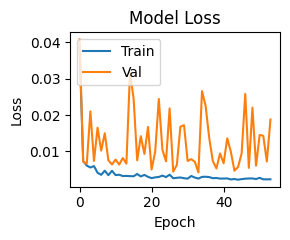

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,epochs,time/s,best_hyperparameter
0,2,128,1,256,0.003331,38,9.164196,True
1,2,128,1,512,0.003598,18,6.453863,False
2,2,128,1,1028,0.003608,31,8.206497,False
3,2,128,2,256,0.004505,28,8.522282,False
4,2,128,2,512,0.005055,22,7.711809,False
5,2,128,2,1028,0.004621,7,5.685050,False
6,2,128,3,256,0.005994,19,8.107011,False
7,2,128,3,512,0.004780,22,8.357214,False
8,2,128,3,1028,0.004188,33,10.031868,False


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2899 - val_loss: 0.0432
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0383 - val_loss: 0.0263
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.0252 - val_loss: 0.0214
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.0192 - val_loss: 0.0151
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.0142 - val_loss: 0.0116
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0118 - val_loss: 0.0119
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.0096 - val_loss: 0.0104
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0084 - val_loss: 0.0075
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0079 - val_loss: 0.0065
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.0068 - val_loss: 0.0099
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0068 - val_loss: 0.0086

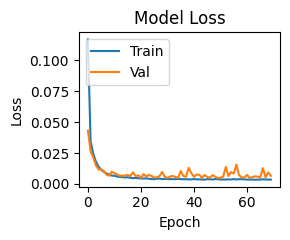

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2677 - val_loss: 0.0225
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 0.0230 - val_loss: 0.0175
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 0.0169 - val_loss: 0.0152
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.0132 - val_loss: 0.0148
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.0098 - val_loss: 0.0117
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0086 - val_loss: 0.0107
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.0063 - val_loss: 0.0067
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.0052 - val_loss: 0.0085
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0047 - val_loss: 0.0060
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.0046 - val_loss: 0.0068

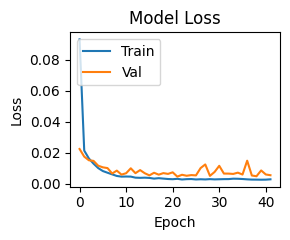

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1588 - val_loss: 0.0306
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.0147 - val_loss: 0.0117
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.0112 - val_loss: 0.0149
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0096 - val_loss: 0.0080
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.0065 - val_loss: 0.0105
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.0061 - val_loss: 0.0067
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.0044 - val_loss: 0.0077
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.0042 - val_loss: 0.0075
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 0.0038 - val_loss: 0.0089
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 0.0038 - val_loss: 0.0083
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 0.0037 - val_loss: 0.0089

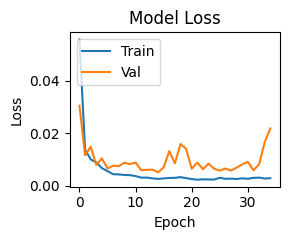

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1213 - val_loss: 0.0305
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.0157 - val_loss: 0.0239
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.0121 - val_loss: 0.0257
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.0104 - val_loss: 0.0137
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0078 - val_loss: 0.0117
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0073 - val_loss: 0.0232
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.0069 - val_loss: 0.0123
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0064 - val_loss: 0.0117
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0058 - val_loss: 0.0099
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0055 - val_loss: 0.0112
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.0054 - val_loss: 0.0186

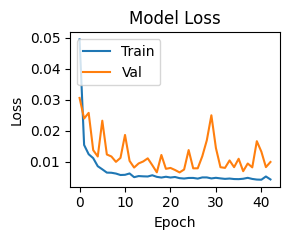

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0914 - val_loss: 0.0187
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.0128 - val_loss: 0.0272
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.0104 - val_loss: 0.0232
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0084 - val_loss: 0.0239
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.0081 - val_loss: 0.0113
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0061 - val_loss: 0.0143
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.0056 - val_loss: 0.0502
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0076 - val_loss: 0.0108
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0048 - val_loss: 0.0095
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 0.0046 - val_loss: 0.0089
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.0041 - val_loss: 0.0106

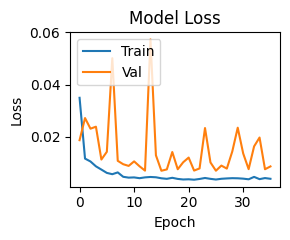

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0954 - val_loss: 0.0751
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.0131 - val_loss: 0.0359
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0088 - val_loss: 0.0469
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0074 - val_loss: 0.0252
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0059 - val_loss: 0.0098
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0045 - val_loss: 0.0109
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0045 - val_loss: 0.0128
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0046 - val_loss: 0.0074
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0039 - val_loss: 0.0103
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.0040 - val_loss: 0.0227
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0040 - val_loss: 0.0078

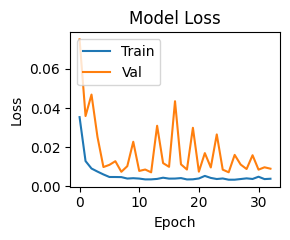

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1220 - val_loss: 0.0405
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0131 - val_loss: 0.0286
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.0111 - val_loss: 0.0147
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0081 - val_loss: 0.0235
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.0073 - val_loss: 0.0128
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.0071 - val_loss: 0.0098
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0065 - val_loss: 0.0134
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0069 - val_loss: 0.0103
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0059 - val_loss: 0.0161
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0059 - val_loss: 0.0082
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.0053 - val_loss: 0.0080

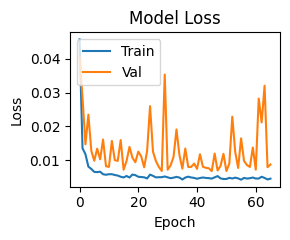

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0872 - val_loss: 0.0308
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0094 - val_loss: 0.0253
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.0083 - val_loss: 0.0178
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.0072 - val_loss: 0.0144
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0055 - val_loss: 0.0110
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 0.0047 - val_loss: 0.0106
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0057 - val_loss: 0.0107
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0041 - val_loss: 0.0167
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 0.0045 - val_loss: 0.0080
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0041 - val_loss: 0.0100
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.0045 - val_loss: 0.0168

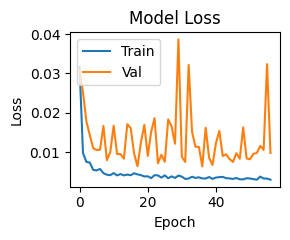

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1413 - val_loss: 0.0234
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.0067 - val_loss: 0.0144
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0065 - val_loss: 0.0211
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.0050 - val_loss: 0.0103
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.0061 - val_loss: 0.0257
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0045 - val_loss: 0.0209
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.0042 - val_loss: 0.0210
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0040 - val_loss: 0.0094
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.0037 - val_loss: 0.0090
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0040 - val_loss: 0.0191
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0041 - val_loss: 0.0143

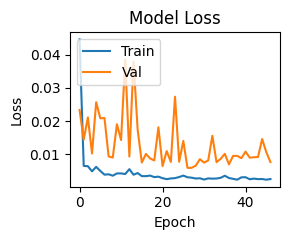

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,epochs,time/s,best_hyperparameter
0,2,128,1,256,0.004722,49,10.792693,False
1,2,128,1,512,0.004665,21,6.943459,True
2,2,128,1,1028,0.005168,14,5.961279,False
3,2,128,2,256,0.006526,22,7.715945,False
4,2,128,2,512,0.007040,15,6.812504,False
5,2,128,2,1028,0.007110,12,6.468003,False
6,2,128,3,256,0.006752,45,11.662547,False
7,2,128,3,512,0.006426,36,10.103201,False
8,2,128,3,1028,0.005942,26,9.110753,False


['../checkpoints/snp500/tuning/2023/all_rue_predictor_best_hp.joblib']

In [10]:
all_rue_best_hp = {}
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    rue_tuning_df, rue_best_hp = model_tuning_regressor(
        param_grid=dict(
            encoder_width = [256, 512, 1028], 
            encoder_depth = [1, 2, 3],
            decoder_width = [128],
            decoder_depth = [2]
        ), predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
        train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], seed=seed,
        batch_size=batch_size, max_epochs=10000, verbose=1, patience=20
    )
    display(rue_tuning_df)
    rue_tuning_df.to_csv(os.path.join(fp_tuning, str(seed), f"tuning_rue_{time_label}.csv"))
    all_rue_best_hp[time_label] = rue_best_hp
joblib.dump(all_rue_best_hp, os.path.join(fp_tuning, str(seed), "all_rue_predictor_best_hp.joblib"))

In [12]:
all_rue_predictor_best_hp = joblib.load(os.path.join(fp_tuning, str(seed), "all_rue_predictor_best_hp.joblib"))
all_rue_predictor_best_hp

{'t+1': {'decoder_depth': 2,
  'decoder_width': 128,
  'encoder_depth': 1,
  'encoder_width': 512},
 't+2': {'decoder_depth': 2,
  'decoder_width': 128,
  'encoder_depth': 1,
  'encoder_width': 256},
 't+3': {'decoder_depth': 2,
  'decoder_width': 128,
  'encoder_depth': 1,
  'encoder_width': 512}}

#### Train Predictor

In [ ]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    best_predictor_hp = all_rue_predictor_best_hp[time_label]
    ae_regressor = model_training_predictor(
        best_predictor_hp, predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
        train_df=time_info_dict["train_df"], valid_df = time_info_dict["valid_df"], seed=seed,
        batch_size=batch_size, max_epochs=10000, verbose=1, patience=20
    ) 
    save_model(model=ae_regressor, name=f"rue_predictor_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)), override=True)

### Tune and Train Decoder

#### Tune Decoder

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 42.7696 - val_loss: 1.6434
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 1.0071 - val_loss: 1.2843
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.9736 - val_loss: 1.2948
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.9519 - val_loss: 1.2627
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.9477 - val_loss: 1.2463
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.9387 - val_loss: 1.2759
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.9433 - val_loss: 1.2459
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.9269 - val_loss: 1.2320
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 0.9244 - val_loss: 1.2362
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.9173 - val_loss: 1.2296
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.9125 - val_loss: 1.246

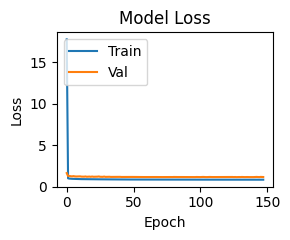

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 62.0843 - val_loss: 1.9309
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 1.3383 - val_loss: 1.7866
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1.3224 - val_loss: 1.7212
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 1.3266 - val_loss: 1.6865
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 1.3156 - val_loss: 1.5837
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 1.2855 - val_loss: 1.6201
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 1.2760 - val_loss: 1.6252
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 1.2757 - val_loss: 1.5633
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.2603 - val_loss: 1.5719
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 1.2444 - val_loss: 1.5513
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.2448 - val_loss: 1.566

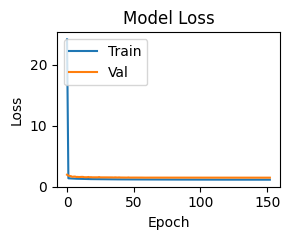

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 82.7809 - val_loss: 2.5256
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1.9992 - val_loss: 2.4770
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1.9963 - val_loss: 2.4522
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 1.9849 - val_loss: 2.2900
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 1.9747 - val_loss: 2.5128
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 1.9409 - val_loss: 2.2358
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1.9407 - val_loss: 2.2258
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.9268 - val_loss: 2.2041
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 1.8925 - val_loss: 2.1895
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 1.8734 - val_loss: 2.1741
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 1.8619 - val_loss: 2.168

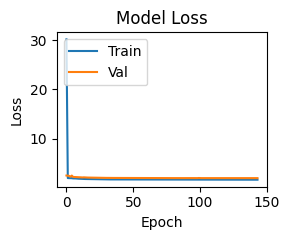

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 84.7605 - val_loss: 2.0171
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 1.3265 - val_loss: 2.0092
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 1.3201 - val_loss: 2.0053
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.3163 - val_loss: 2.0024
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1.3142 - val_loss: 1.9991
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 1.3119 - val_loss: 1.9985
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 1.3102 - val_loss: 2.0001
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 1.3092 - val_loss: 1.9973
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 1.3079 - val_loss: 1.9935
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.3071 - val_loss: 1.9939
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 1.3061 - val_loss: 1.992

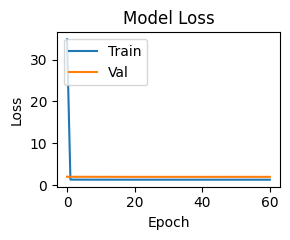

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 160.3332 - val_loss: 3.3089
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 2.6181 - val_loss: 3.2893
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 2.6031 - val_loss: 3.2835
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 2.5931 - val_loss: 3.2706
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 2.5848 - val_loss: 3.2733
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 2.5800 - val_loss: 3.2788
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 2.5761 - val_loss: 3.2610
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 2.5726 - val_loss: 3.2581
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 2.5701 - val_loss: 3.2461
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 2.5666 - val_loss: 3.2513
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 2.5641 - val_loss: 3.25

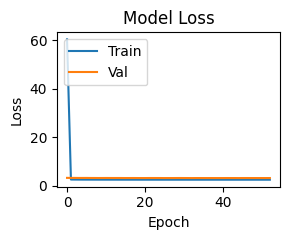

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 310.4102 - val_loss: 7.8221
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1319 - val_loss: 7.7088
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 7.0857 - val_loss: 7.7000
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 7.0639 - val_loss: 7.7384
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 7.0480 - val_loss: 7.7357
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 7.0344 - val_loss: 7.7896
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 7.0320 - val_loss: 7.6881
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 7.0165 - val_loss: 7.6628
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 7.0085 - val_loss: 7.6682
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 7.0009 - val_loss: 7.6598
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 6.9911 - val_loss: 7.664

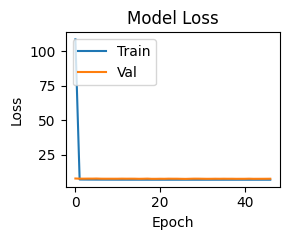

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 126.8185 - val_loss: 2.3425
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1.6559 - val_loss: 2.3377
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 1.6531 - val_loss: 2.3404
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 1.6522 - val_loss: 2.3425
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 1.6522 - val_loss: 2.3360
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1.6508 - val_loss: 2.3410
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6506 - val_loss: 2.3418
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.6504 - val_loss: 2.3391
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.6501 - val_loss: 2.3311
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 1.6491 - val_loss: 2.3376
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.6490 - val_loss: 2.33

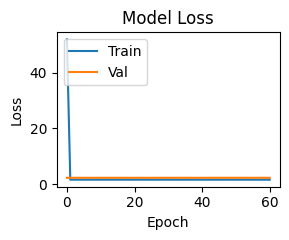

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 258.5830 - val_loss: 4.5941
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 3.9158 - val_loss: 4.5790
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 3.9111 - val_loss: 4.6001
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 3.9116 - val_loss: 4.5897
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 3.9081 - val_loss: 4.6086
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 3.9076 - val_loss: 4.6372
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 3.9077 - val_loss: 4.5942
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 3.9061 - val_loss: 4.5900
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 3.9069 - val_loss: 4.5631
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 3.9027 - val_loss: 4.5910
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 3.9014 - val_loss: 4.6

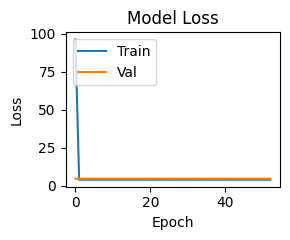

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 538.0858 - val_loss: 13.0660
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3963 - val_loss: 12.8765
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3674 - val_loss: 12.9202
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3647 - val_loss: 13.0605
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3572 - val_loss: 13.0737
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3512 - val_loss: 13.2650
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3731 - val_loss: 13.0048
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3550 - val_loss: 12.9432
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3539 - val_loss: 12.9594
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3505 - val_loss: 13.0071
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3415 - val_loss: 13.

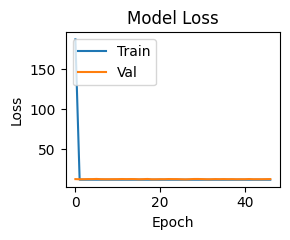

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,corr,epochs,time/s,best_hyperparameter
0,2,512,1,512,1.158660,0.455014,127,22.201779,False
1,2,1028,1,512,1.440658,0.453489,132,21.773337,False
2,2,2048,1,512,1.994341,0.454709,123,20.384920,False
3,3,512,1,512,1.983660,0.464354,40,10.016651,False
4,3,1028,1,512,3.223630,0.464369,32,9.658911,False
5,3,2048,1,512,7.549559,0.464331,26,10.622366,False
6,4,512,1,512,2.328373,0.464407,40,11.242236,True
7,4,1028,1,512,4.551850,0.464377,32,11.199237,False
8,4,2048,1,512,12.774111,0.464327,26,12.605705,False


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 26.9913 - val_loss: 1.4428
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.8424 - val_loss: 1.2813
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.8192 - val_loss: 1.1402
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.7890 - val_loss: 1.2807
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.7833 - val_loss: 1.1266
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.7765 - val_loss: 1.0706
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.7753 - val_loss: 1.0607
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.7619 - val_loss: 1.0653
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.7672 - val_loss: 1.1109
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.7536 - val_loss: 1.0641
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.7532 - val_loss: 1.045

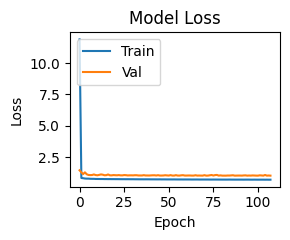

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 36.0569 - val_loss: 1.5873
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 1.0146 - val_loss: 1.3050
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.9836 - val_loss: 1.3661
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.9719 - val_loss: 1.3685
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.9644 - val_loss: 1.3227
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 0.9419 - val_loss: 1.2616
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.9468 - val_loss: 1.2831
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.9327 - val_loss: 1.2663
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.9197 - val_loss: 1.2765
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.9120 - val_loss: 1.2149
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.9164 - val_loss: 1.245

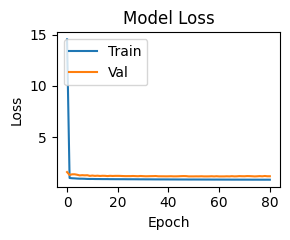

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 45.2585 - val_loss: 1.8470
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 1.3528 - val_loss: 1.8650
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 1.3465 - val_loss: 1.8246
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 1.3328 - val_loss: 1.6323
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 1.2943 - val_loss: 1.5594
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 1.2831 - val_loss: 1.5666
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.2675 - val_loss: 1.6644
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 1.2658 - val_loss: 1.6870
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 1.2557 - val_loss: 1.5310
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 1.2297 - val_loss: 1.5312
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 1.2260 - val_loss: 1.550

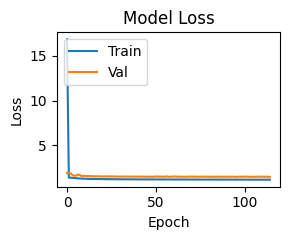

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 68.9949 - val_loss: 1.8545
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.1730 - val_loss: 1.8476
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.1676 - val_loss: 1.8445
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 1.1648 - val_loss: 1.8435
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.1629 - val_loss: 1.8406
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 1.1612 - val_loss: 1.8411
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.1600 - val_loss: 1.8409
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 1.1594 - val_loss: 1.8391
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 1.1587 - val_loss: 1.8373
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 1.1581 - val_loss: 1.8382
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.1577 - val_loss: 1.838

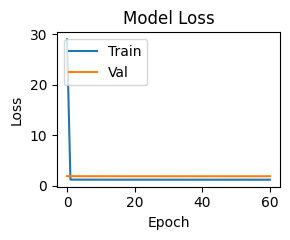

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 134.3206 - val_loss: 2.9846
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 2.3047 - val_loss: 2.9659
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 2.2899 - val_loss: 2.9601
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 2.2806 - val_loss: 2.9487
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 2.2733 - val_loss: 2.9510
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 2.2687 - val_loss: 2.9548
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 2.2654 - val_loss: 2.9417
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 2.2625 - val_loss: 2.9369
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 2.2599 - val_loss: 2.9251
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 2.2567 - val_loss: 2.9311
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 2.2542 - val_loss: 2.9

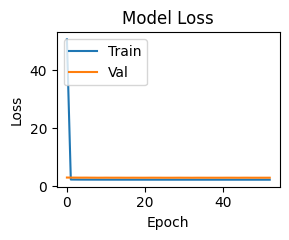

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 272.8976 - val_loss: 7.1677
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 6.4942 - val_loss: 7.0673
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 6.4520 - val_loss: 7.0595
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 6.4308 - val_loss: 7.0898
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 6.4150 - val_loss: 7.0850
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 6.4027 - val_loss: 7.1407
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 6.4020 - val_loss: 7.0443
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 6.3880 - val_loss: 7.0184
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 6.3810 - val_loss: 7.0284
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 6.3750 - val_loss: 7.0270
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 6.3673 - val_loss: 7.0

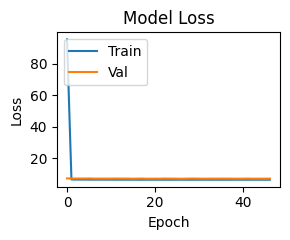

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 111.0584 - val_loss: 2.1841
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5037 - val_loss: 2.1791
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 1.5006 - val_loss: 2.1805
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.4994 - val_loss: 2.1810
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 1.4990 - val_loss: 2.1766
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.4980 - val_loss: 2.1790
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 1.4976 - val_loss: 2.1793
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 1.4974 - val_loss: 2.1779
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 1.4971 - val_loss: 2.1723
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 1.4964 - val_loss: 2.1749
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 1.4961 - val_loss: 2.175

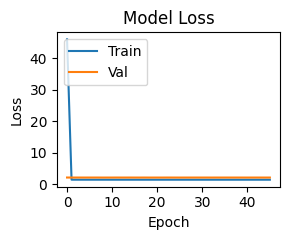

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 232.5699 - val_loss: 4.2714
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 3.6012 - val_loss: 4.2562
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 3.5956 - val_loss: 4.2771
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 3.5957 - val_loss: 4.2659
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 3.5928 - val_loss: 4.2786
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 3.5922 - val_loss: 4.3077
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 3.5917 - val_loss: 4.2704
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 3.5901 - val_loss: 4.2655
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 3.5907 - val_loss: 4.2394
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 3.5868 - val_loss: 4.2649
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 3.5853 - val_loss: 4.2

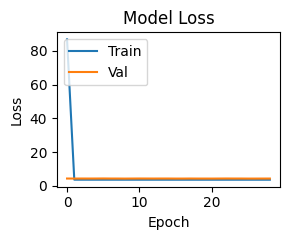

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 500.5702 - val_loss: 12.4258
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7586 - val_loss: 12.2423
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7322 - val_loss: 12.2756
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7302 - val_loss: 12.4068
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7214 - val_loss: 12.4190
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7155 - val_loss: 12.6072
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7374 - val_loss: 12.3515
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7196 - val_loss: 12.2941
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7181 - val_loss: 12.3161
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7142 - val_loss: 12.3606
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7061 - val_loss: 12.

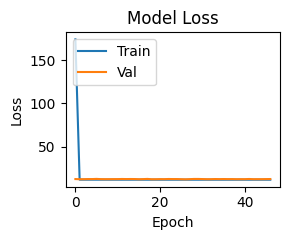

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,corr,epochs,time/s,best_hyperparameter
0,2,512,1,256,1.015875,0.462925,87,15.983562,False
1,2,1028,1,256,1.162191,0.464347,60,12.247432,False
2,2,2048,1,256,1.436778,0.462745,94,16.527986,False
3,3,512,1,256,1.833316,0.474507,40,11.090483,True
4,3,1028,1,256,2.913305,0.474485,32,10.068959,False
5,3,2048,1,256,6.933194,0.474464,26,10.137671,False
6,4,512,1,256,2.172309,0.474482,25,10.254108,False
7,4,1028,1,256,4.239409,0.474339,8,7.592967,False
8,4,2048,1,256,12.141937,0.474470,26,12.365274,False


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 42.7748 - val_loss: 1.6477
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 1.0184 - val_loss: 1.2752
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.9715 - val_loss: 1.2692
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.9550 - val_loss: 1.2620
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.9472 - val_loss: 1.2516
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.9413 - val_loss: 1.2337
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 0.9429 - val_loss: 1.2307
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.9266 - val_loss: 1.2263
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.9240 - val_loss: 1.2524
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.9274 - val_loss: 1.2318
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.9166 - val_loss: 1.237

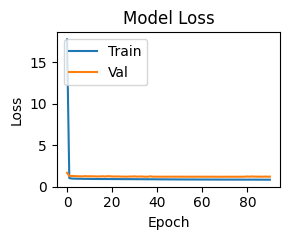

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 62.0922 - val_loss: 1.9512
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 1.3504 - val_loss: 1.6060
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1.3197 - val_loss: 1.7059
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1.3070 - val_loss: 1.5771
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 1.2876 - val_loss: 1.6082
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 1.2903 - val_loss: 1.5705
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 1.2734 - val_loss: 1.5989
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 1.2665 - val_loss: 1.5726
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 1.2585 - val_loss: 1.6547
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 1.2568 - val_loss: 1.5750
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.2439 - val_loss: 1.580

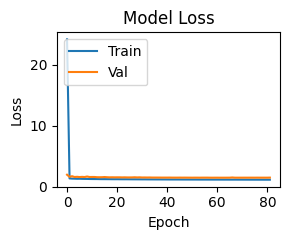

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 82.7875 - val_loss: 2.5613
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 2.0076 - val_loss: 2.4765
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1.9835 - val_loss: 2.3368
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 1.9718 - val_loss: 2.3921
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 1.9565 - val_loss: 2.3537
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 1.9560 - val_loss: 2.2188
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1.9248 - val_loss: 2.2134
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.9108 - val_loss: 2.3180
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 1.9064 - val_loss: 2.2131
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 1.8865 - val_loss: 2.2319
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 1.8722 - val_loss: 2.171

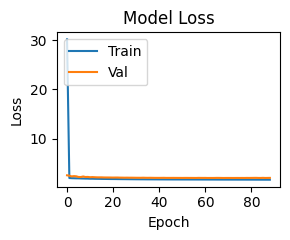

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 84.7665 - val_loss: 2.0256
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.3366 - val_loss: 2.0183
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 1.3306 - val_loss: 2.0154
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.3268 - val_loss: 2.0131
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 1.3244 - val_loss: 2.0088
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.3220 - val_loss: 2.0080
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.3203 - val_loss: 2.0084
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.3192 - val_loss: 2.0068
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 1.3181 - val_loss: 2.0026
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.3168 - val_loss: 2.0034
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.3161 - val_loss: 2.002

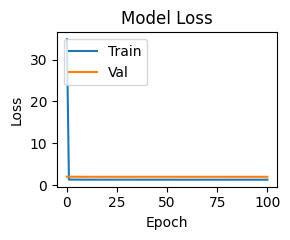

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 160.3412 - val_loss: 3.3134
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 2.6273 - val_loss: 3.2944
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 2.6139 - val_loss: 3.2906
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 2.6047 - val_loss: 3.2769
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 2.5964 - val_loss: 3.2820
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 2.5916 - val_loss: 3.2875
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 2.5880 - val_loss: 3.2706
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 2.5841 - val_loss: 3.2656
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 2.5818 - val_loss: 3.2545
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 2.5781 - val_loss: 3.2605
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 2.5751 - val_loss: 3.26

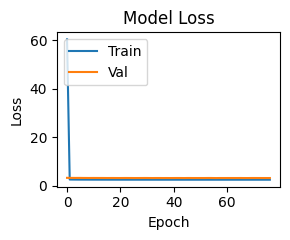

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 310.4198 - val_loss: 7.8210
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1465 - val_loss: 7.7130
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1019 - val_loss: 7.7108
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 7.0808 - val_loss: 7.7514
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 7.0665 - val_loss: 7.7498
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 7.0537 - val_loss: 7.8051
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 7.0519 - val_loss: 7.7043
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 7.0368 - val_loss: 7.6795
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 7.0289 - val_loss: 7.6771
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 7.0220 - val_loss: 7.6804
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 7.0128 - val_loss: 7.6845
E

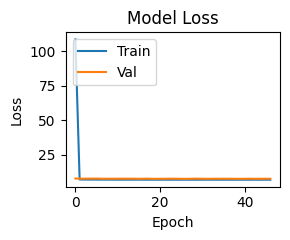

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 126.8268 - val_loss: 2.3543
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 1.6663 - val_loss: 2.3491
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 1.6634 - val_loss: 2.3510
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 1.6625 - val_loss: 2.3523
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 1.6623 - val_loss: 2.3455
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 1.6611 - val_loss: 2.3491
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 1.6608 - val_loss: 2.3524
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 1.6607 - val_loss: 2.3491
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 1.6602 - val_loss: 2.3405
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 1.6596 - val_loss: 2.3454
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 1.6592 - val_loss: 2.34

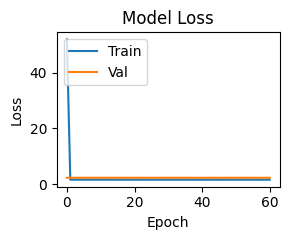

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 258.5912 - val_loss: 4.5985
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 3.9241 - val_loss: 4.5831
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 3.9191 - val_loss: 4.6043
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 3.9193 - val_loss: 4.5928
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 3.9158 - val_loss: 4.6108
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 3.9153 - val_loss: 4.6416
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 3.9155 - val_loss: 4.5976
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 3.9134 - val_loss: 4.5942
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 3.9143 - val_loss: 4.5692
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 3.9103 - val_loss: 4.5950
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 3.9086 - val_loss: 4.62

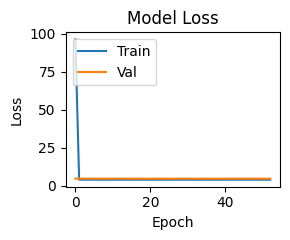

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 538.0950 - val_loss: 13.0808
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.4094 - val_loss: 12.8836
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3793 - val_loss: 12.9243
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3756 - val_loss: 13.0682
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3678 - val_loss: 13.0801
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3621 - val_loss: 13.2750
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3839 - val_loss: 13.0087
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3655 - val_loss: 12.9436
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3650 - val_loss: 12.9599
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3615 - val_loss: 13.0114
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3526 - val_loss: 13.

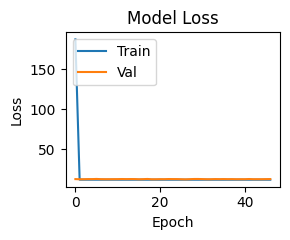

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,corr,epochs,time/s,best_hyperparameter
0,2,512,1,512,1.177767,0.444053,70,13.396874,False
1,2,1028,1,512,1.463548,0.445595,61,12.438517,False
2,2,2048,1,512,2.015771,0.442319,68,13.450939,False
3,3,512,1,512,1.992894,0.454285,80,15.777705,False
4,3,1028,1,512,3.224061,0.454295,56,13.262569,False
5,3,2048,1,512,7.567015,0.454345,26,10.152479,True
6,4,512,1,512,2.338403,0.454290,40,10.840657,False
7,4,1028,1,512,4.561814,0.454319,32,10.814093,False
8,4,2048,1,512,12.782426,0.454342,26,11.852895,False


['../checkpoints/snp500/tuning/2023/all_rue_decoder_best_hp.joblib']

In [26]:
all_rue_decoder_best_hp = {}
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    best_predictor_hp = all_rue_predictor_best_hp[time_label]
    prev_model = load_model(name=f"rue_predictor_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    rue_tuning_df, rue_best_hp = model_tuning_decoder(
        param_grid=dict(
            encoder_width = [best_predictor_hp["encoder_width"]], # , 256, 512
            encoder_depth = [best_predictor_hp["encoder_depth"]], #  3, 4
            decoder_width = [512, 1028, 2048], 
            decoder_depth = [2, 3, 4]
        ), predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
        train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], seed=seed,
        max_epochs=10000, verbose=1, patience=20, prev_model=prev_model
    )
    display(rue_tuning_df)
    rue_tuning_df.to_csv(os.path.join(fp_tuning, str(seed), f"tuning_rue_decoder_{time_label}.csv"))
    all_rue_decoder_best_hp[time_label] = rue_best_hp
joblib.dump(all_rue_decoder_best_hp, os.path.join(fp_tuning, str(seed), "all_rue_decoder_best_hp.joblib"))

In [ ]:
# [256, 512, 1028], [1, 2, 3]
# With Regularisation (L2=0.01) and MSE: 0.41799
# With Regularisation and MAE: 0.43868
# Without Regularisation and MAE: 0.42652
# With Regularisation (L2=0.1) and MSE: 0.45543
# With Regularisation (L1) and MAE: 0.46435

In [27]:
all_rue_decoder_best_hp = joblib.load(os.path.join(fp_tuning, str(seed), "all_rue_decoder_best_hp.joblib"))
all_rue_decoder_best_hp

{'t+1': {'decoder_depth': 4,
  'decoder_width': 512,
  'encoder_depth': 1,
  'encoder_width': 512},
 't+2': {'decoder_depth': 3,
  'decoder_width': 512,
  'encoder_depth': 1,
  'encoder_width': 256},
 't+3': {'decoder_depth': 3,
  'decoder_width': 2048,
  'encoder_depth': 1,
  'encoder_width': 512}}

#### Train Decoder

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 126.8185 - val_loss: 2.3425
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 1.6559 - val_loss: 2.3377
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 1.6531 - val_loss: 2.3404
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.6522 - val_loss: 2.3425
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 1.6522 - val_loss: 2.3360
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 1.6508 - val_loss: 2.3410
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 1.6506 - val_loss: 2.3418
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 1.6504 - val_loss: 2.3391
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 1.6501 - val_loss: 2.3311
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 1.6491 - val_loss: 2.3376
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 1.6490 - val_loss: 2.33

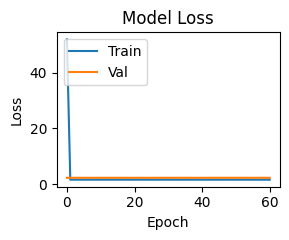

Training took 10.589262008666992s.
Model saved!


Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 68.9949 - val_loss: 1.8545
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 1.1730 - val_loss: 1.8476
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 1.1676 - val_loss: 1.8445
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 1.1648 - val_loss: 1.8435
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.1629 - val_loss: 1.8406
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1.1612 - val_loss: 1.8411
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1.1600 - val_loss: 1.8409
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.1594 - val_loss: 1.8391
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.1587 - val_loss: 1.8373
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 1.1581 - val_loss: 1.8382
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 1.1577 - val_loss: 1.838

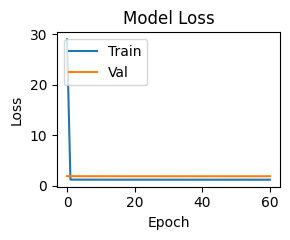

Training took 10.438689231872559s.
Model saved!


Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 310.4198 - val_loss: 7.8210
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1465 - val_loss: 7.7130
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 7.1019 - val_loss: 7.7108
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 7.0808 - val_loss: 7.7514
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 7.0665 - val_loss: 7.7498
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 7.0537 - val_loss: 7.8051
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0519 - val_loss: 7.7043
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 7.0368 - val_loss: 7.6795
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 7.0289 - val_loss: 7.6771
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 7.0220 - val_loss: 7.6804
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 7.0128 - val_loss: 7.6845
E

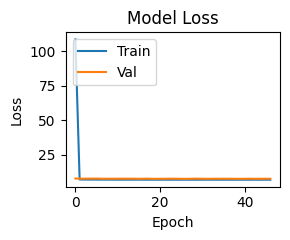

Training took 9.96420931816101s.
Model saved!


In [28]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    prev_model = load_model(name=f"rue_predictor_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    hp_dict = all_rue_decoder_best_hp[time_label]
    ae_regressor = model_training_decoder(
        hp_dict, predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
        train_df=time_info_dict["train_df"], valid_df = time_info_dict["valid_df"], seed=seed, prev_model=prev_model,
        batch_size=batch_size, max_epochs=10000, verbose=1, patience=20
    ) 
    save_model(model=ae_regressor, name=f"rue_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)), override=True)

### Prediction

In [32]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    ae_regressor = load_model(name=f"rue_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    rue_valid_df = model_test_predictions(
        ae_regressor, df_train=time_info_dict["train_df"], df_test=time_info_dict["valid_df"], 
        pred_cols=time_info_dict["outputs"], predictors=feat_cols, regressor_label="_"+time_label, pred_min=int(time_label[-1]), T=10, seed=seed)
    rue_test_df = model_test_predictions(
        ae_regressor, df_train=time_info_dict["train_df"], df_test=time_info_dict["test_df"], 
        pred_cols=time_info_dict["outputs"], predictors=feat_cols, regressor_label="_"+time_label, pred_min=int(time_label[-1]), T=10, seed=seed)
    display(rue_test_df)
    rue_valid_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"rue_valid_{time_label[-1]}.csv"))
    rue_test_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"rue_test_{time_label[-1]}.csv"))

  0%|          | 0/3 [00:00<?, ?it/s]

Predicting with Decoder + Predictor took 0.007172107696533203s. 
Predicting with MC Dropout took 0.033339738845825195s. 
Predicting with Decoder + Predictor took 0.007191896438598633s. 
Predicting with MC Dropout took 0.03348374366760254s. 


,input_start date,input end date,target_date_t+1,input start index,input end index,target_index_t+1,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,Mom_day3_reconstruction_t+1,U$_day4_reconstruction_t+1,Mkt-RF_day4_reconstruction_t+1,SMB_day4_reconstruction_t+1,HML_day4_reconstruction_t+1,Mom_day4_reconstruction_t+1,rue,U$_t+1_mean_t+1,U$_t+1_std_t+1,mcd
11742,2010-08-24,2010-08-30,2010-08-31,11742,11746,11747,1.691458,-1.649939,0.259675,0.286564,...,0.04329,-0.499423,0.002543,0.039456,-0.004415,0.029934,1.136725,1.678182,0.068843,0.068843
11743,2010-08-25,2010-08-31,2010-09-01,11743,11747,11748,1.700180,0.471671,2.068479,-0.049466,...,0.04329,-0.499423,0.002543,0.039456,-0.004415,0.029934,1.144425,1.669409,0.058855,0.058855
11744,2010-08-26,2010-09-01,2010-09-02,11744,11748,11749,1.679736,-0.858457,-0.153204,-0.587113,...,0.04329,-0.499423,0.002543,0.039456,-0.004415,0.029934,1.296649,1.756260,0.054712,0.054712
11745,2010-08-27,2010-09-02,2010-09-03,11745,11749,11750,1.723524,1.977684,1.832548,0.779407,...,0.04329,-0.499423,0.002543,0.039456,-0.004415,0.029934,1.325359,1.794257,0.070793,0.070793
11746,2010-08-30,2010-09-03,2010-09-07,11746,11750,11751,1.684021,-1.715895,-1.667093,-0.990348,...,0.04329,-0.499423,0.002543,0.039456,-0.004415,0.029934,1.227019,1.844059,0.110616,0.110616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14672,2022-04-13,2022-04-20,2022-04-21,14672,14676,14677,10.249206,1.515987,1.753904,-1.640005,...,0.04329,-0.499423,0.002543,0.039456,-0.004415,0.029934,3.500352,10.257666,0.258140,0.258140
14673,2022-04-14,2022-04-21,2022-04-22,14673,14677,14678,10.113077,-1.430083,0.023745,3.109210,...,0.04329,-0.499423,0.002543,0.039456,-0.004415,0.029934,3.476104,10.302917,0.441211,0.441211
14674,2022-04-18,2022-04-22,2022-04-25,14674,14678,14679,10.110808,-0.253853,-1.608111,3.982887,...,0.04329,-0.499423,0.002543,0.039456,-0.004415,0.029934,3.413295,10.185873,0.421588,0.421588
14675,2022-04-19,2022-04-25,2022-04-26,14675,14679,14680,10.288582,1.922720,1.144416,-2.177652,...,0.04329,-0.499423,0.002543,0.039456,-0.004415,0.029934,3.392634,9.993225,0.351129,0.351129


Predicting with Decoder + Predictor took 0.0074748992919921875s. 
Predicting with MC Dropout took 0.033986568450927734s. 
Predicting with Decoder + Predictor took 0.007645845413208008s. 
Predicting with MC Dropout took 0.03360176086425781s. 


,input_start date,input end date,target_date_t+2,input start index,input end index,target_index_t+2,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,Mom_day3_reconstruction_t+2,U$_day4_reconstruction_t+2,Mkt-RF_day4_reconstruction_t+2,SMB_day4_reconstruction_t+2,HML_day4_reconstruction_t+2,Mom_day4_reconstruction_t+2,rue,U$_t+2_mean_t+2,U$_t+2_std_t+2,mcd
11741,2010-08-23,2010-08-27,2010-08-31,11741,11745,11747,1.730507,-0.572645,-1.863702,-0.945544,...,0.047149,-0.515177,0.042119,0.037038,-0.026268,0.047126,1.126651,1.716524,0.094346,0.094346
11742,2010-08-24,2010-08-30,2010-09-01,11742,11746,11748,1.691458,-1.649939,0.259675,0.286564,...,0.047151,-0.515170,0.042107,0.037039,-0.026265,0.047131,1.142328,1.657827,0.100970,0.100970
11743,2010-08-25,2010-08-31,2010-09-02,11743,11747,11749,1.700180,0.471671,2.068479,-0.049466,...,0.047149,-0.515177,0.042116,0.037035,-0.026268,0.047129,1.148858,1.660841,0.047160,0.047160
11744,2010-08-26,2010-09-01,2010-09-03,11744,11748,11750,1.679736,-0.858457,-0.153204,-0.587113,...,0.047148,-0.515173,0.042116,0.037036,-0.026268,0.047127,1.300832,1.836751,0.094809,0.094809
11745,2010-08-27,2010-09-02,2010-09-07,11745,11749,11751,1.723524,1.977684,1.832548,0.779407,...,0.047152,-0.515172,0.042112,0.037042,-0.026268,0.047128,1.326114,1.746619,0.110233,0.110233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14672,2022-04-13,2022-04-20,2022-04-22,14672,14676,14678,10.249206,1.515987,1.753904,-1.640005,...,0.047145,-0.515158,0.042115,0.037036,-0.026246,0.047144,3.501455,10.141565,0.494257,0.494257
14673,2022-04-14,2022-04-21,2022-04-25,14673,14677,14679,10.113077,-1.430083,0.023745,3.109210,...,0.047139,-0.515154,0.042116,0.037034,-0.026244,0.047145,3.481465,10.073040,0.322639,0.322639
14674,2022-04-18,2022-04-22,2022-04-26,14674,14678,14680,10.110808,-0.253853,-1.608111,3.982887,...,0.047138,-0.515154,0.042112,0.037034,-0.026248,0.047140,3.420566,10.148764,0.495500,0.495500
14675,2022-04-19,2022-04-25,2022-04-27,14675,14679,14681,10.288582,1.922720,1.144416,-2.177652,...,0.047138,-0.515154,0.042114,0.037033,-0.026246,0.047143,3.390783,10.028673,0.522809,0.522809


Predicting with Decoder + Predictor took 0.008094072341918945s. 
Predicting with MC Dropout took 0.033986568450927734s. 
Predicting with Decoder + Predictor took 0.007777690887451172s. 
Predicting with MC Dropout took 0.03369259834289551s. 


,input_start date,input end date,target_date_t+3,input start index,input end index,target_index_t+3,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,Mom_day3_reconstruction_t+3,U$_day4_reconstruction_t+3,Mkt-RF_day4_reconstruction_t+3,SMB_day4_reconstruction_t+3,HML_day4_reconstruction_t+3,Mom_day4_reconstruction_t+3,rue,U$_t+3_mean_t+3,U$_t+3_std_t+3,mcd
11740,2010-08-20,2010-08-26,2010-08-31,11740,11744,11747,1.741422,-0.330803,0.534928,-0.564711,...,0.021831,-0.533047,0.008429,0.043557,0.000509,0.032542,0.989156,1.685798,0.085317,0.085317
11741,2010-08-23,2010-08-27,2010-09-01,11741,11745,11748,1.730507,-0.572645,-1.863702,-0.945544,...,0.021829,-0.533058,0.008425,0.043559,0.000507,0.032544,1.132960,1.713487,0.068091,0.068091
11742,2010-08-24,2010-08-30,2010-09-02,11742,11746,11749,1.691458,-1.649939,0.259675,0.286564,...,0.021833,-0.533044,0.008426,0.043560,0.000510,0.032541,1.147572,1.700732,0.067367,0.067367
11743,2010-08-25,2010-08-31,2010-09-03,11743,11747,11750,1.700180,0.471671,2.068479,-0.049466,...,0.021830,-0.533047,0.008427,0.043561,0.000508,0.032542,1.148465,1.702955,0.080707,0.080707
11744,2010-08-26,2010-09-01,2010-09-07,11744,11748,11751,1.679736,-0.858457,-0.153204,-0.587113,...,0.021826,-0.533061,0.008424,0.043559,0.000507,0.032546,1.306462,1.713423,0.059413,0.059413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14672,2022-04-13,2022-04-20,2022-04-25,14672,14676,14679,10.249206,1.515987,1.753904,-1.640005,...,0.021812,-0.533053,0.008417,0.043556,0.000495,0.032549,3.506235,10.247672,0.443738,0.443738
14673,2022-04-14,2022-04-21,2022-04-26,14673,14677,14680,10.113077,-1.430083,0.023745,3.109210,...,0.021813,-0.533029,0.008422,0.043560,0.000492,0.032546,3.482804,9.884115,0.279804,0.279804
14674,2022-04-18,2022-04-22,2022-04-27,14674,14678,14681,10.110808,-0.253853,-1.608111,3.982887,...,0.021817,-0.533040,0.008418,0.043556,0.000496,0.032548,3.425135,9.970139,0.308831,0.308831
14675,2022-04-19,2022-04-25,2022-04-28,14675,14679,14682,10.288582,1.922720,1.144416,-2.177652,...,0.021809,-0.533025,0.008421,0.043561,0.000489,0.032545,3.398901,10.004057,0.464925,0.464925


## GPR Model Training

In [ ]:
def model_training_gpr(
    predictors, pred_cols, train_df, valid_df, seed):

    timer = Timer(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float64'), train_df[pred_cols].values.astype('float64'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float64'), valid_df[pred_cols].values.astype('float64'))

    rng = np.random.default_rng(seed)
    n_inducing = round(len(train_X)*0.001) # 0.1% of points as inducing points
    print("- Number of Inducing Points:", n_inducing)
    inducing_points = rng.choice(train_X, size=n_inducing, replace=False)

    start = time.time()
    
    def step_callback(step, variables, values):
        print(f"Step {step} {time.time()-start:.3f} s", end="\r")

    gpr = gpflow.models.SGPR(
        (train_X, train_y),
        kernel=gpflow.kernels.SquaredExponential(),
        inducing_variable=inducing_points,
    )
    opt = gpflow.optimizers.Scipy()
    print(f"Training started...")
    timer.start(description="Training GPR")
    opt.minimize(gpr.training_loss, gpr.trainable_variables, step_callback=step_callback)
    timer.end()
    # Train GPR
    # from sklearn.gaussian_process import GaussianProcessRegressor
    # from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
    # kernel = DotProduct() + WhiteKernel()
    # gpr = GaussianProcessRegressor(kernel=kernel, copy_X_train=False, random_state=seed)
    # print(f"Training started...")
    # start = time.time()
    # gpr.fit(train_X, train_y)
    
    
    return gpr

def model_test_predictions_gpr(
    gpr, df_test, pred_cols, predictors, regressor_label, pred_min, seed=seed):
    timer = Timer(seed)
    df_test = df_test.copy()
  
    test_X, test_y = (
        df_test[predictors].values.astype('float64'), df_test[pred_cols].values.astype('float64'))
    timer.start(description="Predicting with GPR")
    test_y_pred, test_std = gpr.compiled_predict_y(test_X)
    timer.end()

    # test_y_pred, test_std = gpr.predict(test_X, return_std=True)
#     print(test_std.shape)
    predicted_colnames = [col+"_gpr"+regressor_label for col in pred_cols]
    std_colnames = [col+"_gpr_std"+regressor_label for col in pred_cols]
    gpr_mean_std_colname = "gpr_std_mean"
    df_test[predicted_colnames] = test_y_pred
    df_test[std_colnames] = test_std
    df_test[gpr_mean_std_colname] = np.mean(test_std, axis=1)
    
    if df_test['target_index'].dtype != "int64":
        df_test['target_index'] = df_test['target_index'].apply(lambda x: eval(x)[pred_min-1])
    
    return df_test

def save_model_gpr(model, name, fp_checkpoints):
    model.compiled_predict_y = tf.function(
        lambda Xnew: model.predict_y(Xnew),
        input_signature=[tf.TensorSpec(shape=[None, len(predictors)], dtype=tf.float64)],
    )
    tf.saved_model.save(model, os.path.join(fp_checkpoints, name))
    print("Model saved!")

def load_model_gpr(name, fp_checkpoints): 
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    
    if not os.path.exists(model_folder):
        print("model checkpoint does not exist!")
        return
    
    return tf.saved_model.load(model_folder)
    
def calculate_mse(df_test, pred_cols, model_label, regressor_label):
    y_true = df_test[pred_cols].values
    predicted_cols = [col+model_label+regressor_label for col in pred_cols]
    y_pred = df_test[predicted_cols].values
    return sklearn.metrics.mean_squared_error(y_true, y_pred)

### Predict T+1

In [ ]:
gpr_1 = model_training_gpr( # 88.14491534233093s.
    predictors=predictors, pred_cols=pred_cols_1, 
    train_df=df_train_1, valid_df = df_valid_1, seed=seed
) 

In [ ]:
save_model_gpr(model=gpr_1, name="gpr_1", fp_checkpoints=os.path.join(fp_project_models, str(seed)))

In [ ]:
gpr_1 = load_model_gpr(name="gpr_1", fp_checkpoints=os.path.join(fp_project_models, str(seed)))

In [ ]:
gpr_1_valid_pred = model_test_predictions_gpr(
    gpr=gpr_1, df_test=df_valid_1, pred_cols=pred_cols_1, 
    predictors=predictors, regressor_label="_t+1", pred_min=1)
gpr_1_valid_pred.to_csv(os.path.join(fp_project_predictions, str(seed), "gpr_valid_1.csv"))
gpr_1_test_pred = model_test_predictions_gpr(
    gpr=gpr_1, df_test=df_test_1, pred_cols=pred_cols_1, 
    predictors=predictors, regressor_label="_t+1", pred_min=1)
gpr_1_test_pred.to_csv(os.path.join(fp_project_predictions, str(seed), "gpr_test_1.csv"))

In [ ]:
calculate_mse(df_test=gpr_1_test_pred, pred_cols=pred_cols_1, model_label="_gpr", regressor_label="_t+1")

In [ ]:
# gpr_1 = load_model_gpr(name="gpr_1", fp_checkpoints=os.path.join(fp_project_models, str(seed)))

### Predict T+2

In [ ]:
gpr_2 = model_training_gpr( 
    predictors=predictors, pred_cols=pred_cols_2, 
    train_df=df_train_2, valid_df = df_valid_2, seed=seed
) 

In [ ]:
save_model_gpr(model=gpr_2, name="gpr_2", fp_checkpoints=os.path.join(fp_project_models, str(seed)))

In [ ]:
gpr_2 = load_model_gpr(name="gpr_2", fp_checkpoints=os.path.join(fp_project_models, str(seed)))

In [ ]:
gpr_2_valid_pred = model_test_predictions_gpr(
    gpr=gpr_2, df_test=df_valid_2, pred_cols=pred_cols_2, 
    predictors=predictors, regressor_label="_t+2", pred_min=2)
gpr_2_valid_pred.to_csv(os.path.join(fp_project_predictions, str(seed), "gpr_valid_2.csv"))
gpr_2_test_pred = model_test_predictions_gpr(
    gpr=gpr_2, df_test=df_test_2, pred_cols=pred_cols_2, 
    predictors=predictors, regressor_label="_t+2", pred_min=2)
gpr_2_test_pred.to_csv(os.path.join(fp_project_predictions, str(seed), "gpr_test_2.csv"))

In [ ]:
calculate_mse(df_test=gpr_2_test_pred, pred_cols=pred_cols_2, model_label="_gpr", regressor_label="_t+2")

In [ ]:
# gpr_2 = load_model_gpr(name="gpr_2", fp_checkpoints=os.path.join(fp_project_models, str(seed)))

### Predict T+3

In [ ]:
gpr_3 = model_training_gpr( 
    predictors=predictors, pred_cols=pred_cols_3, 
    train_df=df_train_3, valid_df = df_valid_3, seed=seed
) 

In [ ]:
save_model_gpr(model=gpr_3, name="gpr_3", fp_checkpoints=os.path.join(fp_project_models, str(seed)))

In [ ]:
gpr_3 = load_model_gpr(name="gpr_3", fp_checkpoints=os.path.join(fp_project_models, str(seed)))

In [ ]:
gpr_3_valid_pred = model_test_predictions_gpr(
    gpr=gpr_3, df_test=df_valid_3, pred_cols=pred_cols_3, 
    predictors=predictors, regressor_label="_t+3", pred_min=3)
gpr_3_valid_pred.to_csv(os.path.join(fp_project_predictions, str(seed), "gpr_valid_3.csv"))
gpr_3_test_pred = model_test_predictions_gpr(
    gpr=gpr_3, df_test=df_test_3, pred_cols=pred_cols_3, 
    predictors=predictors, regressor_label="_t+3", pred_min=3)
gpr_3_test_pred.to_csv(os.path.join(fp_project_predictions, str(seed), "gpr_test_3.csv"))

In [ ]:
calculate_mse(df_test=gpr_3_test_pred, pred_cols=pred_cols_3, model_label="_gpr", regressor_label="_t+3")

In [ ]:
# gpr_3 = load_model_gpr(name="gpr_3", fp_checkpoints=os.path.join(fp_project_models, str(seed)))

## InferNoise

In [ ]:
def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred), axis=-1)

def tune_infernoise(ae_predictor, stddev_list, valid_df, inputs, outputs, seed, T, regressor_label):
    corr_list = []
    loss_list = []
    for stddev in tqdm(stddev_list):
        valid_pred_df = infernoise_test_predictions(ae_predictor, valid_df, inputs, outputs, seed, T, stddev, regressor_label, False)
        loss = valid_pred_df["infernoise_mae"]
        ue = valid_pred_df["infernoise_uncertainty"]
        corr, _ = pearsonr(ue, loss)
        loss_list.append(valid_pred_df["infernoise_mae"].mean())
        corr_list.append(corr)
    tuning_df = pd.DataFrame({"std": stddev_list, "correlation": corr_list, "loss":loss_list})
    tuning_df["best_hyperparameter"] = False
    best_index = tuning_df["loss"].idxmin()
    tuning_df.iloc[best_index, -1] = True
    return tuning_df

def infernoise_test_predictions(ae_predictor, test_df, inputs, outputs, seed, T, stddev, regressor_label, time_run=True):
    timer = Timer(seed=seed)
    test_df = test_df.copy()
    # Process data
    test_X, test_y = (test_df[inputs].values.astype('float32'), test_df[outputs].values.astype('float32'))
    
    set_seed(seed)

    # Define model
    input_layer = tf.keras.Input(shape=(len(inputs),))
    gaussian_noise_layer = tf.keras.layers.GaussianNoise(stddev, seed=seed)
    x = ae_predictor.encoder(input_layer)
    x = gaussian_noise_layer(x)
    x = ae_predictor.regressor.layers[-1](x) # To ignore dropout layer
    infernoise_model = tf.keras.Model(inputs=input_layer, outputs=x, name="infernoise_model")
    
    # For Infer Noise
    # - Sample with infer noise
    test_y_sample_preds = [] # T, num samples, output classes
    if time_run:
        timer.start(description="Predicting with Infer-Noise")
    for i in range(T):
        test_y_pred = infernoise_model(test_X, training=True)
        # print(test_y_pred[:5])
        test_y_sample_preds.append(test_y_pred)
    if time_run:
        timer.end()
    
    test_y_sample_preds = np.array(test_y_sample_preds)
    test_y_sample_preds =  test_y_sample_preds.transpose((1, 2, 0)) # num samples, predicted features, T
    
    # - Get mean prediction 
    # num samples, predicted features
    test_y_mean_pred = np.mean(test_y_sample_preds, axis=-1)
    predicted_infernoise_colnames = [col + "_infernoise"+regressor_label for col in outputs]
    test_df[predicted_infernoise_colnames] = test_y_mean_pred
    
    # - Get loss for each output
    test_y_mc_loss = mae_fn(y_true=test_y, y_pred=test_y_mean_pred)
    test_df["infernoise_mae"] = test_y_mc_loss
    
    # - Uncertainty score (for regression)
    #   - Calculate std of predictions
    test_y_sd_pred = np.mean(np.std(test_y_sample_preds, axis=-1, ddof=1), axis=-1)
    test_df["infernoise_uncertainty"] = test_y_sd_pred

    return test_df

def display_tuning_df(tuning_df):
    def highlight_sentiment(row):
        if row["best_hyperparameter"]:
            return ['background-color: #cafae6'] * len(row)
        else:
            return [''] * len(row)
    return tuning_df.style.apply(highlight_sentiment, axis=1)


### Tuning

In [ ]:
infernoise_dict = {
    "t+1": {"model_name": "rue_t+1", "valid_df": df_valid_1, "test_df": df_test_1, "outputs": pred_cols_1},
    "t+2": {"model_name": "rue_t+2", "valid_df": df_valid_2, "test_df": df_test_2, "outputs": pred_cols_2},
    "t+3": {"model_name": "rue_t+3", "valid_df": df_valid_3, "test_df": df_test_3, "outputs": pred_cols_3},
}
infernoise_hp_dict = {}
for time_label, info_dict in infernoise_dict.items():
    print(f"{time_label}:")
    ae_regressor = load_model(name=info_dict["model_name"], fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    infernoise_tuning_df = tune_infernoise(
        ae_regressor, stddev_list=[0.00001, 0.00005, 0.0001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], 
        valid_df=info_dict["valid_df"], inputs=predictors, outputs=info_dict["outputs"], seed=seed, T=10, regressor_label="_"+time_label
    )
    display(display_tuning_df(infernoise_tuning_df))
    infernoise_hp_dict[time_label] = infernoise_tuning_df.iloc[infernoise_tuning_df["loss"].argmin(), 0]

In [ ]:
joblib.dump(infernoise_hp_dict, os.path.join(fp_tuning, "all_infernoise_best_hp.joblib"))

In [ ]:
infernoise_hp_dict = joblib.load(os.path.join(fp_tuning, "all_infernoise_best_hp.joblib"))
infernoise_hp_dict

### Prediction

In [ ]:
for time_label, info_dict in infernoise_dict.items():
    print(f"{time_label}:")
    ae_regressor = load_model(name=info_dict["model_name"], fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    infernoise_valid_df = infernoise_test_predictions(
         ae_regressor, test_df=info_dict["valid_df"], inputs=predictors, outputs=info_dict["outputs"], regressor_label="_"+time_label, 
        seed=seed, T=10, stddev=infernoise_hp_dict[time_label])
    infernoise_test_df = infernoise_test_predictions(
         ae_regressor, test_df=info_dict["test_df"], inputs=predictors, outputs=info_dict["outputs"], regressor_label="_"+time_label, 
        seed=seed, T=10, stddev=infernoise_hp_dict[time_label])
    display(infernoise_test_df)
    infernoise_valid_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"infernoise_valid_{time_label[-1]}.csv"))
    infernoise_test_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"infernoise_test_{time_label[-1]}.csv"))

## BNN

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred), axis=-1)

def set_seed_pytorch(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

class TabularDataset(Dataset):
    def __init__(self, df, feat_cols, target_cols):
        self.data_df = df
        self.feat_cols = feat_cols
        self.target_cols = target_cols

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        features = torch.from_numpy(row[self.feat_cols].values.astype(float)).float()
        label = torch.from_numpy(row[self.target_cols].values.astype(float)).float()
        return features, label

def instantiate_bnn_model(num_layers, width, num_inputs, num_outputs, seed):
    set_seed_pytorch(seed)
    layers = []
    in_features, out_features = num_inputs, width
    for i in range(num_layers):
        if (i == (num_layers-1)):
            out_features = num_outputs
        layers.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=in_features, out_features=out_features))
        if (i != num_layers-1):
            layers.append(nn.ReLU())
        in_features = width
    return nn.Sequential(*layers)

def train_bnn_model(bnn_model, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed, fp_model):
    set_seed_pytorch(seed)
    # Prepare dataset
    train_ds = TabularDataset(df=train_df, feat_cols=feat_cols, target_cols=target_cols)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Prepare dataset
    set_seed_pytorch(seed)
    valid_ds = TabularDataset(df=valid_df, feat_cols=feat_cols, target_cols=target_cols)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.1
    optimizer = optim.Adam(bnn_model.parameters(), lr=0.001)

    best_epoch, best_val_loss, patience_count = -1, np.inf, 0

    bnn_model.to(device)

    with tqdm(range(epochs), total=epochs) as pbar:
        for epoch in pbar:
            for x_batch, y_batch in train_dl:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = bnn_model(x_batch)
                mse = mse_loss(pred, y_batch)
                kl = kl_loss(bnn_model)
                cost = mse + kl_weight*kl
                
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
                
                x_batch = x_batch.detach().cpu()
                y_batch = y_batch.detach().cpu()
                mse = mse.detach().cpu()
                kl = kl.detach().cpu()
                cost = cost.detach().cpu()
                
            # Evaluate performance on validation set
            valid_pred = predict_bnn_model(bnn_model, valid_dl, feat_cols, target_cols, seed=seed, silent=True)
            valid_loss = evaluate_bnn_perf(valid_df, feat_cols, target_cols, valid_pred)
            pbar.set_description(f"valid_loss: {valid_loss:.5f}")

            # Early stopping
            if valid_loss < best_val_loss:
                best_epoch, best_val_loss = epoch, valid_loss
                patience_count = 0
                torch.save(bnn_model, fp_model)
            else:
                patience_count += 1
                if patience_count > patience:
                    print(f"Early stopping! Model achieved best performance at Epoch {best_epoch} with loss = {best_val_loss}.")
                    break
    
    return best_val_loss, best_epoch
        
def predict_bnn_model(bnn_model, dl, feat_cols, target_cols, seed, silent):
    set_seed_pytorch(seed)
    # Send model to gpu
    bnn_model.to(device)
    # Predictions
    all_pred = []
    # Predict with model
    with tqdm(dl, total=len(dl), disable=silent) as pbar:
        for x_batch, y_batch in pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = bnn_model(x_batch)
            all_pred.append(pred.detach().cpu())
    return torch.cat(all_pred)

def evaluate_bnn_perf(df, feat_cols, target_cols, pred):
    y = df[target_cols].values
    mse = torch.mean(torch.square(pred-y)).item()
    return mse

def evaluate_bnn(bnn_model, df, feat_cols, target_cols, seed):
    ds = TabularDataset(df=df, feat_cols=feat_cols, target_cols=target_cols)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    pred = predict_bnn_model(bnn_model, dl, feat_cols, target_cols, seed=seed, silent=True)
    return evaluate_bnn_perf(df, feat_cols, target_cols, pred)

def tune_bnn_model(param_grid, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed, fp_model):
    parameter_list = list(ParameterGrid(param_grid))
    loss_list, time_list, epoch_list = [], [], []
    with tqdm(parameter_list) as pbar:
        for param_dict in pbar:
            bnn_model = instantiate_bnn_model(seed=seed, num_inputs=len(feat_cols), num_outputs=len(target_cols), **param_dict)
            start = time.time()
            loss, best_epoch = train_bnn_model(bnn_model, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed, fp_model)
            time_list.append(time.time()-start)
            epoch_list.append(best_epoch)
            loss_list.append(loss)
    tuning_df = pd.DataFrame(parameter_list)
    tuning_df["loss"] = loss_list
    tuning_df["epoch"] = epoch_list
    tuning_df["time/s"] = time_list
    best_index = np.argmin(tuning_df["loss"])
    tuning_df["best_hyperparameter"] = False
    tuning_df.iloc[best_index, -1] = True
    return tuning_df, parameter_list[best_index]

def train_model_w_best_param(best_param, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed, fp_model):
    bnn_model =  instantiate_bnn_model(seed=seed, num_inputs=len(feat_cols), num_outputs=len(target_cols), **best_param)
    timer = Timer(seed=seed)
    timer.start(description="Training BNN")
    train_bnn_model(bnn_model, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed, fp_model)
    timer.end()
    return torch.load(fp_model)

def bnn_model_prediction(bnn_model, test_df, feat_cols, target_cols, T, seed,  regressor_label):
    test_df = test_df.copy()
    set_seed_pytorch(seed)
    # Prepare dataset
    test_ds = TabularDataset(df=test_df, feat_cols=feat_cols, target_cols=target_cols)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    seed_list = list(range(seed, seed+T))
    all_logits = []
    timer = Timer(seed=seed)
    timer.start(description="Predicting with BNN")
    for cur_seed in tqdm(seed_list):
        logits = predict_bnn_model(bnn_model, test_dl, feat_cols, target_cols, seed=cur_seed, silent=True)
        all_logits.append(logits)
    timer.end()
    
    all_logits = torch.stack(all_logits) # T, N, O
    test_y_pred = all_logits.mean(axis=0) # N, O
    test_y_std = all_logits.std(axis=0) # N, O
    test_y = torch.from_numpy(test_df[target_cols].values).float()
    
    test_df["bnn_uncertainty"] = test_y_std.mean(axis=-1) # N
    test_df["bnn_mae"] = mae_fn(y_true=test_y.numpy(), y_pred=test_y_pred.numpy())
    predicted_colnames = [col + "_bnn_"+ regressor_label for col in target_cols]
    test_df[predicted_colnames] = test_y_pred
    return test_df

### Tuning

In [ ]:
best_width_1=256
ae_regressor_1 = model_training(
    width=best_width_1, predictors=predictors, pred_cols=pred_cols_1, 
    train_df=df_train_1, valid_df = df_valid_1, seed=seed,
    batch_size=2048, max_epochs=10000, verbose=1, patience=20
) 

In [ ]:
bnn_dict = {
    "t+1": {"train_df": df_train_1, "valid_df": df_valid_1, "test_df": df_test_1, "outputs": pred_cols_1},
    "t+2": {"train_df": df_train_2, "valid_df": df_valid_2, "test_df": df_test_2, "outputs": pred_cols_2},
    "t+3": {"train_df": df_train_3, "valid_df": df_valid_3, "test_df": df_test_3, "outputs": pred_cols_3},
}
all_bnn_best_hp = {}
for time_label, time_info_dict in bnn_dict.items():
    fp_model = os.path.join(fp_project_models, str(seed), f"bnn_{time_label}.pt")
    bnn_tuning_df, bnn_best_hp = tune_bnn_model(
        param_grid={"num_layers":[2, 3], "width":[32, 64, 128, 256]}, 
        train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
        feat_cols=predictors, target_cols=time_info_dict["outputs"], epochs=500, patience=5, seed=seed, fp_model=fp_model)
    display(bnn_tuning_df)
    bnn_tuning_df.to_csv(os.path.join(fp_tuning, str(seed), f"tuning_bnn_{time_label}.csv"))
    all_bnn_best_hp[time_label] = bnn_best_hp
joblib.dump(all_bnn_best_hp, os.path.join(fp_tuning, "all_bnn_best_hp.joblib"))

In [ ]:
all_bnn_best_hp = joblib.load(os.path.join(fp_tuning, str(seed), "all_bnn_best_hp.joblib"))
print(all_bnn_best_hp)

### Training

In [ ]:
bnn_dict = {
    "t+1": {"train_df": df_train_1, "valid_df": df_valid_1, "test_df": df_test_1, "outputs": pred_cols_1},
    "t+2": {"train_df": df_train_2, "valid_df": df_valid_2, "test_df": df_test_2, "outputs": pred_cols_2},
    "t+3": {"train_df": df_train_3, "valid_df": df_valid_3, "test_df": df_test_3, "outputs": pred_cols_3},
}
for time_label, time_info_dict in tqdm(bnn_dict.items(), total=len(bnn_dict)):
    fp_model = os.path.join(fp_project_models, str(seed), f"bnn_{time_label}.pt")
    bnn_best_hp = all_bnn_best_hp[time_label]
    bnn_model = train_model_w_best_param(
        best_param=bnn_best_hp, train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
        feat_cols=predictors, target_cols=time_info_dict["outputs"],
        epochs=500, patience=5, seed=seed, fp_model=fp_model
    )

### Prediction

In [ ]:
bnn_dict = {
    "t+1": {"train_df": df_train_1, "valid_df": df_valid_1, "test_df": df_test_1, "outputs": pred_cols_1},
    "t+2": {"train_df": df_train_2, "valid_df": df_valid_2, "test_df": df_test_2, "outputs": pred_cols_2},
    "t+3": {"train_df": df_train_3, "valid_df": df_valid_3, "test_df": df_test_3, "outputs": pred_cols_3},
}
for time_label, time_info_dict in tqdm(bnn_dict.items(), total=len(bnn_dict)):
    fp_model = os.path.join(fp_project_models, str(seed), f"bnn_{time_label}.pt")
    bnn_model = torch.load(fp_model)
    bnn_valid_df = bnn_model_prediction(bnn_model, time_info_dict["valid_df"], feat_cols=predictors, target_cols=time_info_dict["outputs"], T=10, seed=seed, regressor_label=time_label)
    bnn_test_df = bnn_model_prediction(bnn_model, time_info_dict["test_df"], feat_cols=predictors, target_cols=time_info_dict["outputs"], T=10, seed=seed, regressor_label=time_label)
    display(bnn_test_df)
    bnn_valid_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"bnn_valid_{time_label[-1]}.csv"))
    bnn_test_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"bnn_test_{time_label[-1]}.csv"))

## DER

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

enable_print  = print
disable_print = lambda *x, **y: None

def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred), axis=-1)

class TabularDataset(Dataset):
    def __init__(self, df, feat_cols, target_cols):
        self.data_df = df
        self.feat_cols = feat_cols
        self.target_cols = target_cols

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        features = torch.from_numpy(row[self.feat_cols].values.astype(float)).float()
        label = torch.from_numpy(row[self.target_cols].values.astype(float)).float()
        return features, label

def optim_regression(
    model: nn.Module, learning_rate: float = 0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0,)
    return optimizer

def train_der_w_param(n_hidden_layers, hidden_width, train_df, valid_df, inputs, outputs, seed, max_epochs=500, patience=5, time_training=True):
    seed_everything(seed, workers=True)
    timer = Timer(seed=seed)
    # Data
    train_ds = TabularDataset(df=train_df, feat_cols=inputs, target_cols=outputs)
    valid_ds = TabularDataset(df=valid_df, feat_cols=inputs, target_cols=outputs)
    datamodule = LightningDataModule.from_datasets(train_ds, val_dataset=valid_ds, test_dataset=valid_ds, batch_size=batch_size, num_workers=63)
    datamodule.training_task = "regression"
    # print("hidden_dims:", [hidden_width for _ in range(n_hidden_layers)])
    # Model
    model = mlp(
        in_features=len(inputs),
        num_outputs=4*len(outputs),
        hidden_dims=[hidden_width for _ in range(n_hidden_layers)],
        final_layer=NormalInverseGammaLayer,
        final_layer_args={"dim": len(outputs)},
    )
    
    # Training
    loss = DERLoss(reg_weight=1e-2)
    routine = RegressionRoutine(
        probabilistic=True,
        output_dim=len(outputs),
        model=model,
        loss=loss,
        optim_recipe=optim_regression(model),
    )
    early_stopping = EarlyStopping('val/MSE', patience=patience, verbose=True, mode='min')

    trainer = Trainer(accelerator="gpu", devices=1, max_epochs=max_epochs, enable_progress_bar=True, callbacks=[early_stopping])
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        if time_training:
            timer.start(description="Training DER")
        trainer.fit(model=routine, datamodule=datamodule)
        if time_training:
            timer.end()
        result = trainer.test(model=routine, datamodule=datamodule)

    return model, result[0]

def der_model_prediction(der_model, test_df, feat_cols, target_cols, seed, silent, regressor_label):
    seed_everything(seed, workers=True)
    test_df = test_df.copy()

    timer = Timer(seed=seed)
    timer.start(description="Predicting with DER")
    with torch.no_grad():
        x = torch.from_numpy(test_df[feat_cols].values).float()
        dists = der_model(x)
        means = dists.loc
        std = torch.sqrt(dists.variance_loc)
    timer.end()
    
    test_y = torch.from_numpy(test_df[target_cols].values).float()
    
    test_df["der_uncertainty"] = std.mean(axis=-1) # N
    test_df["der_mae"] = mae_fn(y_true=test_y.numpy(), y_pred=means.numpy())
    predicted_colnames = [col + "_der_"+regressor_label for col in target_cols]
    test_df[predicted_colnames] = means
    return test_df

def tune_der_model(param_grid, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed,):
    parameter_list = list(ParameterGrid(param_grid))
    loss_list, time_list = [], []
    with tqdm(parameter_list) as pbar:
        for param_dict in pbar:
            start = time.time()
            der_model, result = train_der_w_param(
                train_df=train_df, valid_df=valid_df, 
                inputs=feat_cols, outputs=target_cols,
                seed=seed, max_epochs=epochs, patience=patience, **param_dict
            )
            # print(result)
            time_list.append(time.time()-start)
            loss_list.append(result['test/MSE'])
    tuning_df = pd.DataFrame(parameter_list)
    tuning_df["loss"] = loss_list
    tuning_df["time/s"] = time_list
    best_index = np.argmin(tuning_df["loss"])
    tuning_df["best_hyperparameter"] = False
    tuning_df.iloc[best_index, -1] = True
    return tuning_df, parameter_list[best_index]

### Tuning

In [ ]:
der_dict = {
    "t+1": {"train_df": df_train_1, "valid_df": df_valid_1, "test_df": df_test_1, "outputs": pred_cols_1},
    "t+2": {"train_df": df_train_2, "valid_df": df_valid_2, "test_df": df_test_2, "outputs": pred_cols_2},
    "t+3": {"train_df": df_train_3, "valid_df": df_valid_3, "test_df": df_test_3, "outputs": pred_cols_3},
}
all_der_best_hp = {}
for time_label, time_info_dict in tqdm(der_dict.items(), total=len(der_dict)):
    der_tuning_df, der_best_hp = tune_der_model(
        param_grid={
            "n_hidden_layers":[2, 3, 4],
            "hidden_width": [128, 256, 512]}, 
        train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
        feat_cols=predictors, target_cols=time_info_dict["outputs"], epochs=500, patience=5, seed=seed
    )
    der_tuning_df.to_csv(os.path.join(fp_tuning, str(seed), f"tuning_der_{time_label}.csv"))
    all_der_best_hp[time_label] = der_best_hp
    display(der_tuning_df)
joblib.dump(all_der_best_hp, os.path.join(fp_tuning, str(seed), "all_der_best_hp.joblib"))

In [ ]:
all_der_best_hp = joblib.load(os.path.join(fp_tuning, "all_der_best_hp.joblib"))
all_der_best_hp

### Training

In [ ]:
der_dict = {
    "t+1": {"train_df": df_train_1, "valid_df": df_valid_1, "test_df": df_test_1, "outputs": pred_cols_1},
    "t+2": {"train_df": df_train_2, "valid_df": df_valid_2, "test_df": df_test_2, "outputs": pred_cols_2},
    "t+3": {"train_df": df_train_3, "valid_df": df_valid_3, "test_df": df_test_3, "outputs": pred_cols_3},
}
for time_label, time_info_dict in tqdm(der_dict.items(), total=len(der_dict)):
    fp_model = os.path.join(fp_project_models, str(seed), f"der_{time_label}.pt")
    der_model, _ = train_der_w_param(
        **all_der_best_hp[time_label], 
        train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
        inputs=predictors, outputs=time_info_dict["outputs"],
        seed=seed, max_epochs=500, patience=5
    )
    torch.save(der_model, fp_model)

### Prediction

In [ ]:
der_dict = {
    "t+1": {"train_df": df_train_1, "valid_df": df_valid_1, "test_df": df_test_1, "outputs": pred_cols_1},
    "t+2": {"train_df": df_train_2, "valid_df": df_valid_2, "test_df": df_test_2, "outputs": pred_cols_2},
    "t+3": {"train_df": df_train_3, "valid_df": df_valid_3, "test_df": df_test_3, "outputs": pred_cols_3},
}
for time_label, time_info_dict in tqdm(der_dict.items(), total=len(der_dict)):
    fp_model = os.path.join(fp_project_models, str(seed), f"der_{time_label}.pt")
    der_model = torch.load(fp_model)
    der_valid_df = der_model_prediction(
        der_model, test_df=time_info_dict["valid_df"], feat_cols=predictors, target_cols=time_info_dict["outputs"], seed=seed, silent=False, regressor_label=time_label)
    der_test_df = der_model_prediction(
        der_model, test_df=time_info_dict["test_df"], feat_cols=predictors, target_cols=time_info_dict["outputs"], seed=seed, silent=False, regressor_label=time_label)
    display(der_test_df)
    der_valid_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"der_valid_{time_label[-1]}.csv"))
    der_test_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"der_test_{time_label[-1]}.csv"))

## Generate Prediction Interval

#### Load Predictions

In [12]:
def load_scaler(fp_scaler_file):
    import pickle 
    with open(fp_scaler_file, 'rb') as handle:
        scaler = pickle.load(handle)
    return scaler

def load_all_predictions(time_label, split="test"):
    columns = []
    df_list = [] 
    for model in ["rue"]: # Update this when you have a new ue # , "gpr", "infernoise", "bnn", "der"
        fp = os.path.join(fp_project_predictions, str(seed), f"{model}_{split}_{time_label}.csv")
        df = pd.read_csv(fp, index_col=0)
        # find new columns not in current column list
        new_cols = [col for col in df.columns if col not in columns]
        columns.extend(new_cols)
        df_list.append(df[new_cols])
    return pd.concat(df_list, axis=1)

# Save all predictions
def save_df_dict(df_dict, seed):
    for time_label, time_info in tqdm(df_dict.items()):
        fp_seed_folder = os.path.join(fp_project_pi_predictions, str(seed))
        create_folder(fp_seed_folder)
        val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
        val_df.to_csv(os.path.join(fp_seed_folder, "val_"+time_label+".csv"))
        test_df.to_csv(os.path.join(fp_seed_folder, "test_"+time_label+".csv"))
        joblib.dump(pred_cols, os.path.join(fp_seed_folder, "pred_cols_"+time_label+".joblib"))
    print("Saved df_dict!")

# Load all predictions
def load_df_dict(seed, time_labels=["t+1", "t+2", "t+3"]):
    df_dict = {}
    for time_label in tqdm(time_labels):
        fp_seed_folder = os.path.join(fp_project_pi_predictions, str(seed))
        val_df = pd.read_csv(os.path.join(fp_seed_folder, "val_"+time_label+".csv"), index_col=0)
        val_df = val_df.loc[:, ~val_df.columns.str.contains('^Unnamed')]
        test_df = pd.read_csv(os.path.join(fp_seed_folder, "test_"+time_label+".csv"), index_col=0)
        test_df = test_df.loc[:, ~test_df.columns.str.contains('^Unnamed')]
        pred_cols = joblib.load(os.path.join(fp_seed_folder, "pred_cols_"+time_label+".joblib"))
        df_dict[time_label] = {"valid_df": val_df, "test_df": test_df, "pred_cols":pred_cols}
    print("Loaded df_dict!")
    return df_dict

def add_new_ue_to_df_dict(df_dict, seed, model, time_labels=["t+1", "t+2", "t+3"]):
    for time_label in tqdm(time_labels):
        for split in ["valid_df", "test_df"]:
            fp = os.path.join(fp_project_predictions, str(seed), f"{model}_{split[:-3]}_{time_label[-1]}.csv")
            df = pd.read_csv(fp, index_col=0)
            df = df.reset_index(drop=True)
            # find new columns not in current column list
            new_cols = [col for col in df.columns if col not in df_dict[time_label][split].columns]
            if len(new_cols)==0:
                print(f"No new columns in {split}")
                continue
            df_dict[time_label][split] = pd.concat([df_dict[time_label][split], df[new_cols]], axis=1)
    return df_dict

In [13]:
scaler = load_scaler(fp_scaler)

val_df_1 = load_all_predictions(time_label=1, split="valid")
val_df_2 = load_all_predictions(time_label=2, split="valid")
val_df_3 = load_all_predictions(time_label=3, split="valid")
    
test_df_1 = load_all_predictions(time_label=1)
test_df_2 = load_all_predictions(time_label=2)
test_df_3 = load_all_predictions(time_label=3)

df_dict = {
    "t+1": {"valid_df": val_df_1, "test_df": test_df_1, "pred_cols": data_dict["t+1"]["outputs"]}, 
    "t+2": {"valid_df": val_df_2, "test_df": test_df_2, "pred_cols": data_dict["t+2"]["outputs"]}, 
    "t+3": {"valid_df": val_df_3, "test_df": test_df_3, "pred_cols": data_dict["t+3"]["outputs"]}, 
}

# df_dict = add_new_ue_to_df_dict(df_dict, seed=seed, model="der", time_labels=["t+1", "t+2", "t+3"])

In [ ]:
df_dict = load_df_dict(seed)

#### Calculate KNN Prediction Interval

In [18]:
def standard_inverse_transform_one_col(series: pd.Series, scaler: sklearn.preprocessing.StandardScaler, col: str):
    feat_index = scaler.feature_names_in_.tolist().index(col)
    mean, std = scaler.mean_[feat_index], np.sqrt(scaler.var_[feat_index])
    return series*std+mean
    
def knn_prediction_interval(df_val, df_test, scaler, predictors, pred_cols, pred_label, regressor_label, ue_col, alpha=0.05, seed=seed):
    pi_label = "_knn"
    df_val, df_test = df_val.copy(), df_test.copy()

    unscaled_cols = [col+"_unscaled" for col in pred_cols]
    prediction_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
    unscaled_pred_cols = [col+"_unscaled" for col in prediction_cols]

    # Unscale the prediction columns
    df_val[unscaled_cols] = standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    df_test[unscaled_cols] = standard_inverse_transform_one_col(df_test[pred_cols], scaler, col="U$")
    df_val[unscaled_pred_cols] = standard_inverse_transform_one_col(df_val[prediction_cols], scaler, col="U$")
    df_test[unscaled_pred_cols] = standard_inverse_transform_one_col(df_test[prediction_cols], scaler, col="U$")

    # Set K = sqrt of size of validation set
    k = round(np.sqrt(len(df_val)))

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction_"+regressor_label for col in predictors]
    valid_re = df_val[predictors].values - df_val[reconstruction_cols].values
    test_re = df_test[predictors].values - df_test[reconstruction_cols].values

    timer = Timer(seed=seed)
    timer.start(description="KNN PI")

    # Find neighbours
    n_val = len(valid_re)
    kdtree = KDTree(valid_re)
    dist, ind = kdtree.query(test_re, k=k, workers=-1)

    for col in pred_cols:
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col+"_unscaled"].values.astype('float32')
        val_y_pred = df_val[col+pred_label+"_"+regressor_label+"_unscaled"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        # Nearbouring prediction errors
        neighbour_pe = val_pe[ind]

        # PI = 0.95 Percentile of neigbouring errors
        df_test[col+"_"+ue_col+pi_label] = np.quantile(neighbour_pe, np.ceil((k+1)*(1-alpha))/k, method='higher')
        #np.percentile(neighbour_pe, (1-alpha/2)*100, axis=1)

    timer.end()
    
    return df_test


In [19]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
}    

# Apply knn_prediction_interval to all RUE
for time_label, time_info in df_dict.items():
    val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
    ue_label = "rue"
    for ue_label, ue_info in ue_dict.items():
        pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
        df_dict[time_label]["test_df"] = knn_prediction_interval(
            df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
            pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler)

save_df_dict(df_dict=df_dict, seed=seed)

KNN PI took 0.013492345809936523s. 
KNN PI took 0.009024620056152344s. 
KNN PI took 0.008813142776489258s. 


  0%|          | 0/3 [00:00<?, ?it/s]

Saved df_dict!


In [20]:
[col for col in df_dict["t+1"]["valid_df"].columns if "direct" in col]

['U$_t+1_direct_t+1']

#### Calculate Weighted Percentile Prediction Interval

In [21]:
def weighted_percentile_original(values, weights, percentile): # both are matrices
    n_test = len(values)
    pis = []
    for i in tqdm(range(n_test), total=n_test, leave=False):
        df = pd.DataFrame({'v': values[i], 'w': weights[i]})
        # display(df)
        calc = wc.Calculator('w')  # w designates weight
        pi = calc.quantile(df, 'v', percentile)
        pis.append(pi)
    return pis

def weighted_percentile_matrix(values, weights, percentile):
    ix = np.argsort(values, axis=-1) # sort within each 
    values = np.take_along_axis(values, ix, axis=-1) # sort data
    weights = np.take_along_axis(weights, ix, axis=-1) # sort weights
    cdf = (np.cumsum(weights, axis=-1) - 0.5 * weights) / np.sum(weights, axis=-1, keepdims=True) # 'like' a CDF function
    return [np.interp(percentile, cdf[i], values[i]) for i in range(values.shape[0])]

def weighted_prediction_interval(df_val, df_test, scaler, predictors, pred_cols, pred_label, regressor_label, ue_col, alpha=0.05, seed=seed):
    pi_label = "_weighted"
    df_val, df_test = df_val.copy(), df_test.copy()

    unscaled_cols = [col+"_unscaled" for col in pred_cols]
    prediction_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
    unscaled_pred_cols = [col+"_unscaled" for col in prediction_cols]

    # standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    # Unscale the prediction columns
    df_val[unscaled_cols] = standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    df_test[unscaled_cols] = standard_inverse_transform_one_col(df_test[pred_cols], scaler, col="U$")
    df_val[unscaled_pred_cols] = standard_inverse_transform_one_col(df_val[prediction_cols], scaler, col="U$")
    df_test[unscaled_pred_cols] = standard_inverse_transform_one_col(df_test[prediction_cols], scaler, col="U$")

    # Set K = sqrt of size of validation set
    n_val = len(df_val)
    n_test = len(df_test)
    n_feat = len(prediction_cols)
    k = round(np.sqrt(n_val))

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction"+"_"+regressor_label for col in predictors]
    valid_re = df_val[predictors].values - df_val[reconstruction_cols].values
    test_re = df_test[predictors].values - df_test[reconstruction_cols].values

    timer = Timer(seed=seed)
    timer.start(description="Weighted PI")

    # Mahalanobis distance = euclidan distance after pc with whitening
    # - https://stackoverflow.com/questions/69811792/mahalanobis-distance-not-equal-to-euclidean-distance-after-pca
    re_scaler = StandardScaler()
    pca = PCA(whiten=True)
    valid_re = re_scaler.fit_transform(valid_re)
    valid_re = pca.fit_transform(valid_re)
    test_re = re_scaler.transform(test_re)
    test_re = pca.transform(test_re)

    # Find neighbours
    sigma = 10
    kdtree = KDTree(valid_re)
    mahalanobis_dist, ind = kdtree.query(test_re, k=k, workers=-1, p=2)
    dist = mahalanobis_dist/np.sqrt(n_feat) # already sorted by distance (nearest first; ascending order of distance)
    weights = np.exp(-np.square(dist)/(2*sigma**2)) # descending order of weights
    print(np.sum(np.sum(weights, axis=1)==0))
    print(np.mean(np.var(weights, axis=1)))
    modified_alpha = np.ceil((k+1)*(1-alpha))/k

    for col in tqdm(pred_cols):
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col+"_unscaled"].values.astype('float32')
        val_y_pred = df_val[col+pred_label+"_"+regressor_label+"_unscaled"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        # Nearbouring prediction errors
        neighbour_pe = val_pe[ind]

        # # PI = 0.95 Weighted Percentile of neigbouring errors
        # pis = []
        # for i in tqdm(range(n_test), total=n_test, leave=False):
        #     df = pd.DataFrame({'v': neighbour_pe[i], 'w': weights[i]})
        #     # display(df)
        #     calc = wc.Calculator('w')  # w designates weight
        #     pi = calc.quantile(df, 'v', modified_alpha)
        #     pis.append(pi)
        pis = weighted_percentile_matrix(values=neighbour_pe, weights=weights, percentile=modified_alpha)
        df_test[col+"_"+ue_col+pi_label] = pis

    timer.end()
    
    return df_test

In [23]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
}    

# Apply weighted_prediction_interval to all RUE
for time_label, time_info in df_dict.items():
    val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
    ue_label = "rue"
    for ue_label, ue_info in ue_dict.items():
        pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
        df_dict[time_label]["test_df"] = weighted_prediction_interval(
            df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
            pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler)

save_df_dict(df_dict=df_dict, seed=seed)

0
0.00018731784316967394


  0%|          | 0/1 [00:00<?, ?it/s]

Weighted PI took 0.10502338409423828s. 
0
0.00018723830022120233


  0%|          | 0/1 [00:00<?, ?it/s]

Weighted PI took 0.09969449043273926s. 
0
0.000187112775228825


  0%|          | 0/1 [00:00<?, ?it/s]

Weighted PI took 0.10124778747558594s. 


  0%|          | 0/3 [00:00<?, ?it/s]

Saved df_dict!


#### Calculate Conditional Gaussian Prediction Interval

In [24]:
class ConditionalGaussianDistribution:
    def __init__(self, Y, X):
        self.Y = Y # Assume shape = (num_samples, num_output)
        self.X = X # Assume shape = (num_samples, num_inputs)
        self.YX = np.concatenate((Y, X), axis=-1) # Assume shape = (num_samples, num_output+num_inputs)
        self.num_Y = self.Y.shape[1]
        self.num_X = self.X.shape[1]

        # Fitting
        self.esti_mean_YX = np.mean(self.YX, axis = 0) # (num_output+num_inputs,)
        self.esti_covariance_matrix_YX = np.cov(self.YX.T, ddof=1) # (num_output+num_inputs, num_output+num_inputs)
        
        # Useful stats
        self.mu_Y = self.esti_mean_YX[:self.num_Y]
        self.mu_X = self.esti_mean_YX[self.num_Y:]
        self.cov_XX = self.esti_covariance_matrix_YX[self.num_Y:, self.num_Y:]
        self.cov_YY = self.esti_covariance_matrix_YX[:self.num_Y, :self.num_Y]
        self.cov_YX = self.esti_covariance_matrix_YX[:self.num_Y, self.num_Y:]
        self.cov_XY = self.esti_covariance_matrix_YX[self.num_Y:, :self.num_Y]
        
    def get_conditional_mean(self, alpha):
        # alpha = (num_samples, self.num_X)
        return (
            self.mu_Y + 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX),
                (alpha - self.mu_X).T))
        ).flatten()
        
    def get_conditional_cov(self):
        return (
            self.cov_YY - 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX), 
                self.cov_XY))
        ).flatten()[0]

def cond_gauss_prediction_interval(df_val, df_test, scaler, predictors, pred_cols, pred_label, regressor_label, ue_col, alpha=0.05, seed=seed):
    pi_label = "_cond_gauss"
    df_val, df_test = df_val.copy(), df_test.copy()

    unscaled_cols = [col+"_unscaled" for col in pred_cols]
    prediction_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
    unscaled_pred_cols = [col+"_unscaled" for col in prediction_cols]

    # Unscale the prediction columns
    df_val[unscaled_cols] = standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    df_test[unscaled_cols] = standard_inverse_transform_one_col(df_test[pred_cols], scaler, col="U$")
    df_val[unscaled_pred_cols] = standard_inverse_transform_one_col(df_val[prediction_cols], scaler, col="U$")
    df_test[unscaled_pred_cols] = standard_inverse_transform_one_col(df_test[prediction_cols], scaler, col="U$")

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction_"+regressor_label for col in predictors]
    valid_re = df_val[predictors].values - df_val[reconstruction_cols].values
    test_re = df_test[predictors].values - df_test[reconstruction_cols].values

    n_val = len(df_val)

    timer = Timer(seed=seed)
    timer.start(description="Conditional PI")

    for col in tqdm(pred_cols):
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col+"_unscaled"].values.astype('float32')
        val_y_pred = df_val[col+pred_label+"_"+regressor_label+"_unscaled"].values.astype('float32')
        val_pe = val_y-val_y_pred

        # Stack both pe and reconstruction error to fit the cond gaussian model
        val_data = np.hstack((np.expand_dims(val_pe, axis=1), valid_re))
        
        # Parameter Estimation on Validation Set
        uncertainty_distribution = ConditionalGaussianDistribution(
            Y=np.expand_dims(val_pe, axis=1), 
            X= valid_re
        )
        esti_conditional_mean_Y = uncertainty_distribution.get_conditional_mean(test_re)
        esti_conditional_std_Y = np.sqrt(uncertainty_distribution.get_conditional_cov())
        
        # 1-alpha/2 -> Because Gaussian is symmetrical
        df_test[col+"_"+ue_col+pi_label] = norm.ppf(1-alpha/2, loc=esti_conditional_mean_Y, scale=esti_conditional_std_Y).flatten()

    timer.end()
    
    return df_test


In [26]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
}    

# Apply cond_gauss_prediction_interval to all RUE
for time_label, time_info in df_dict.items():
    val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
    ue_label = "rue"
    for ue_label, ue_info in ue_dict.items():
        pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
        df_dict[time_label]["test_df"] = cond_gauss_prediction_interval(
            df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
            pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler)

save_df_dict(df_dict=df_dict, seed=seed)

  0%|          | 0/1 [00:00<?, ?it/s]

Conditional PI took 0.018529653549194336s. 


  0%|          | 0/1 [00:00<?, ?it/s]

Conditional PI took 0.0071675777435302734s. 


  0%|          | 0/1 [00:00<?, ?it/s]

Conditional PI took 0.006990671157836914s. 


  0%|          | 0/3 [00:00<?, ?it/s]

Saved df_dict!


#### Calculate Gaussian Corpula Prediction Interval

In [28]:
EPSILON = np.finfo(np.float32).eps

class ConditionalGaussianDistribution:
    def __init__(self, Y, X):
        self.Y = Y # Assume shape = (num_samples, num_output)
        self.X = X # Assume shape = (num_samples, num_inputs)
        self.YX = np.concatenate((Y, X), axis=-1) # Assume shape = (num_samples, num_output+num_inputs)
        self.num_Y = self.Y.shape[1]
        self.num_X = self.X.shape[1]

        # Fitting
        self.esti_mean_YX = np.mean(self.YX, axis = 0) # (num_output+num_inputs,)
        self.esti_covariance_matrix_YX = np.cov(self.YX.T, ddof=1) # (num_output+num_inputs, num_output+num_inputs)
        
        # Useful stats
        self.mu_Y = self.esti_mean_YX[:self.num_Y]
        self.mu_X = self.esti_mean_YX[self.num_Y:]
        self.cov_XX = self.esti_covariance_matrix_YX[self.num_Y:, self.num_Y:]
        self.cov_YY = self.esti_covariance_matrix_YX[:self.num_Y, :self.num_Y]
        self.cov_YX = self.esti_covariance_matrix_YX[:self.num_Y, self.num_Y:]
        self.cov_XY = self.esti_covariance_matrix_YX[self.num_Y:, :self.num_Y]
        
    def get_conditional_mean(self, alpha):
        # alpha = (num_samples, self.num_X)
        return (
            self.mu_Y + 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX),
                (alpha - self.mu_X).T))
        ).flatten()
        
    def get_conditional_cov(self):
        return (
            self.cov_YY - 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX), 
                self.cov_XY))
        ).flatten()[0]

class GaussianCopula:
    def __init__(self, X):
        self.X = X
        self.n_feat = X.shape[1]

        # Get all CDFs
        self.cdfs = []
        for i_feat in range(self.n_feat):
            self.cdfs.append(stats.ecdf(X[:, i_feat]))

    def add_y(self, y):
        self.y = y
        self.y_cdf = stats.ecdf(self.y)
        
    def X_to_V(self, cur_X):
        X_Vi = np.empty(cur_X.shape)
        for i_feat in range(self.n_feat):
            Fi = self.cdfs[i_feat].cdf.evaluate(cur_X[:, i_feat]).clip(EPSILON, 1 - EPSILON)
            X_Vi[:,i_feat] = norm.ppf(Fi)
        return X_Vi

    def Y_to_V(self, cur_y):
        y_Fi = self.y_cdf.cdf.evaluate(cur_y).clip(EPSILON, 1 - EPSILON)
        y_Vi = norm.ppf(y_Fi)
        return y_Vi

    def V_to_Y(self, cur_y_Vi):
        y_Fi = norm.cdf(cur_y_Vi)
        y = np.percentile(self.y, y_Fi*100, axis=0, method="higher")
        return y

def gauss_copula_prediction_interval(df_val, df_test, scaler, predictors, pred_cols, pred_label, regressor_label, ue_col, alpha=0.05, seed=seed):
    pi_label = "_gauss_copula"
    df_val, df_test = df_val.copy(), df_test.copy()

    unscaled_cols = [col+"_unscaled" for col in pred_cols]
    prediction_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
    unscaled_pred_cols = [col+"_unscaled" for col in prediction_cols]

    # Unscale the prediction columns
    df_val[unscaled_cols] = standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    df_test[unscaled_cols] = standard_inverse_transform_one_col(df_test[pred_cols], scaler, col="U$")
    df_val[unscaled_pred_cols] = standard_inverse_transform_one_col(df_val[prediction_cols], scaler, col="U$")
    df_test[unscaled_pred_cols] = standard_inverse_transform_one_col(df_test[prediction_cols], scaler, col="U$")

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction"+"_"+regressor_label for col in predictors]
    valid_re = df_val[predictors].values - df_val[reconstruction_cols].values
    test_re = df_test[predictors].values - df_test[reconstruction_cols].values

    timer = Timer(seed=seed)
    timer.start(description="Copula PI")

    # Convert reconstruction and prediction error to V
    gc = GaussianCopula(valid_re)
    valid_re = gc.X_to_V(valid_re)
    test_re = gc.X_to_V(test_re)

    n_val = len(df_val)

    for col in tqdm(pred_cols):
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col+"_unscaled"].values.astype('float32')
        val_y_pred = df_val[col+pred_label+"_"+regressor_label+"_unscaled"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        gc.add_y(val_pe)
        val_pe = gc.Y_to_V(val_pe)

        # Parameter Estimation on Validation Set
        uncertainty_distribution = ConditionalGaussianDistribution(
            Y=np.expand_dims(val_pe, axis=1), 
            X= valid_re
        )
        esti_conditional_mean_Y = uncertainty_distribution.get_conditional_mean(test_re)
        esti_conditional_std_Y = np.sqrt(uncertainty_distribution.get_conditional_cov())

        pi_V = norm.ppf(1-alpha, loc=esti_conditional_mean_Y, scale=esti_conditional_std_Y).flatten()
        # print(pi_V)

        # Convert from V space back to Y
        df_test[col+"_"+ue_col+pi_label] = gc.V_to_Y(pi_V)

    timer.end()
    
    return df_test


In [30]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
}    

# Apply weighted_prediction_interval to all RUE
for time_label, time_info in df_dict.items():
    val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
    ue_label = "rue"
    for ue_label, ue_info in ue_dict.items():
        pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
        df_dict[time_label]["test_df"] = gauss_copula_prediction_interval(
            df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
            pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler)

save_df_dict(df_dict=df_dict, seed=seed)

  0%|          | 0/1 [00:00<?, ?it/s]

Copula PI took 0.052442312240600586s. 


  0%|          | 0/1 [00:00<?, ?it/s]

Copula PI took 0.03436112403869629s. 


  0%|          | 0/1 [00:00<?, ?it/s]

Copula PI took 0.03442549705505371s. 


  0%|          | 0/3 [00:00<?, ?it/s]

Saved df_dict!


In [ ]:
df_dict = load_df_dict(seed)

#### Calculate Conformal Prediction Intervals

In [31]:
def conformal_prediction_interval(df_val, df_test, scaler, predictors, pred_cols, pred_label, regressor_label, ue_col, alpha=0.05, seed=seed):
    pi_label = "_conformal"
    df_val, df_test = df_val.copy(), df_test.copy()
    unscaled_cols = [col+"_unscaled" for col in pred_cols]
    prediction_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
    unscaled_pred_cols = [col+"_unscaled" for col in prediction_cols]
    df_val[unscaled_cols] = standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    df_test[unscaled_cols] = standard_inverse_transform_one_col(df_test[pred_cols], scaler, col="U$")
    df_val[unscaled_pred_cols] = standard_inverse_transform_one_col(df_val[prediction_cols], scaler, col="U$")
    df_test[unscaled_pred_cols] = standard_inverse_transform_one_col(df_test[prediction_cols], scaler, col="U$")

    timer = Timer(seed=seed)
    timer.start(description="Conformal PI")

    for col in pred_cols:
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col+"_unscaled"].values.astype('float32')
        val_y_pred = df_val[col+pred_label+"_"+regressor_label+"_unscaled"].values.astype('float32')
        val_error = np.abs(val_y-val_y_pred)
    
        # Get uncertainty 
        val_ue = df_val[ue_col].astype('float32')

        # Get scores
        val_scores = val_error/val_ue
        # Get the score quantile
        n = len(df_val)
        qhat = np.quantile(val_scores, np.ceil((n+1)*(1-alpha))/n, method='higher')

        # 2. Test df
        # Get uncertainty 
        test_ue = df_test[ue_col].astype('float32')

        # Caclulate PI
        df_test[col+"_"+ue_col+pi_label] = test_ue*qhat
        
    timer.end()
    
    return df_test

In [33]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
    "MC Dropout": {
        "pred_label": "_mean", "ue_col": "mcd", 
    },
    # "GPR": {
    #     "pred_label": "_gpr", "ue_col": "gpr_std_mean", 
    # },
    # "Infer-Noise": {
    #     "pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", 
    # },
    # "BNN": {
    #     "pred_label": "_bnn", "ue_col": "bnn_uncertainty", 
    # },
    # "DER": {
    #     "pred_label": "_der", "ue_col": "der_uncertainty", 
    # }
}    

# Apply conformal prediction to all UEs
for time_label, time_info in df_dict.items():
    val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
    for ue_label, ue_info in ue_dict.items():
        pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
        df_dict[time_label]["test_df"] = conformal_prediction_interval(
            df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
            pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler)

save_df_dict(df_dict=df_dict, seed=seed)

Conformal PI took 0.0013709068298339844s. 
Conformal PI took 0.001299142837524414s. 
Conformal PI took 0.0012090206146240234s. 
Conformal PI took 0.0012617111206054688s. 
Conformal PI took 0.0012481212615966797s. 
Conformal PI took 0.0008680820465087891s. 


  0%|          | 0/3 [00:00<?, ?it/s]

Saved df_dict!


In [34]:
df_dict["t+1"]["test_df"]

,input_start date,input end date,target_date_t+1,input start index,input end index,target_index_t+1,U$_day0,Mkt-RF_day0,SMB_day0,HML_day0,...,mcd,U$_t+1_unscaled,U$_t+1_direct_t+1_unscaled,U$_t+1_rue_knn,U$_t+1_rue_weighted,U$_t+1_rue_cond_gauss,U$_t+1_rue_gauss_copula,U$_t+1_rue_conformal,U$_t+1_mean_t+1_unscaled,U$_t+1_mcd_conformal
11742,2010-08-24,2010-08-30,2010-08-31,11742,11746,11747,1.691458,-1.649939,0.259675,0.286564,...,0.068843,1049.33,1048.432957,113.805176,28.590454,29.139665,42.459595,25.771475,1046.603491,38.093460
11743,2010-08-25,2010-08-31,2010-09-01,11743,11747,11748,1.700180,0.471671,2.068479,-0.049466,...,0.058855,1080.29,1044.318592,113.805176,27.743774,29.692802,37.990723,25.946058,1043.123463,32.566750
11744,2010-08-26,2010-09-01,2010-09-02,11744,11748,11749,1.679736,-0.858457,-0.153204,-0.587113,...,0.054712,1090.10,1080.502543,113.805176,14.860107,27.943753,26.802734,29.397224,1077.575889,30.274168
11745,2010-08-27,2010-09-02,2010-09-03,11745,11749,11750,1.723524,1.977684,1.832548,0.779407,...,0.070793,1104.51,1084.044294,113.805176,26.882690,34.797363,32.791138,30.048140,1092.648803,39.172184
11746,2010-08-30,2010-09-03,2010-09-07,11746,11750,11751,1.684021,-1.715895,-1.667093,-0.990348,...,0.110616,1091.84,1108.507785,113.805176,23.882812,32.873847,35.070312,27.818598,1112.404292,61.207870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14672,2022-04-13,2022-04-20,2022-04-21,14672,14676,14677,10.249206,1.515987,1.753904,-1.640005,...,0.258140,4393.66,4413.709448,113.805176,49.001587,76.681673,19.450439,79.358902,4449.946118,142.837875
14673,2022-04-14,2022-04-21,2022-04-22,14673,14677,14678,10.113077,-1.430083,0.023745,3.109210,...,0.441211,4271.78,4402.313118,113.805176,38.753418,64.694399,21.379883,78.809143,4467.896656,244.137543
14674,2022-04-18,2022-04-22,2022-04-25,14674,14678,14679,10.110808,-0.253853,-1.608111,3.982887,...,0.421588,4296.12,4365.234289,113.805176,27.998535,-0.742034,23.967529,77.385162,4421.466997,233.279236
14675,2022-04-19,2022-04-25,2022-04-26,14675,14679,14680,10.288582,1.922720,1.144416,-2.177652,...,0.351129,4175.20,4350.531203,113.805176,37.330322,2.990952,17.513916,76.916756,4345.046652,194.291702


## Evaluation

### Evaluation Functions

In [35]:
def get_prediction_performance_table(test_df_dict, ue_dict):
    perf_df_dict = []
    for ue_name, ue_info in ue_dict.items():
        ue_row_dict = {"Model": ue_name}
        pred_label = ue_info["pred_label"]
        for regressor_label, test_df_info in test_df_dict.items():
            test_df = test_df_info["test_df"]
            pred_cols = test_df_info["pred_cols"]
            y_pred_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
            # ue_cols = [col+ue_label for col in predictors]
            ue_row_dict[regressor_label] = sklearn.metrics.mean_squared_error(test_df[pred_cols], test_df[y_pred_cols])
        perf_df_dict.append(ue_row_dict)
    return pd.DataFrame(perf_df_dict)

def calculate_aurc(ue, loss):
    num_samples = len(ue)
    ue_loss_df = pd.DataFrame({"ue":ue, "loss":loss})
    ue_loss_df = ue_loss_df.sort_values(by="ue", ascending=True)
    ue_loss_df["cumulative_loss"] = ue_loss_df["loss"].expanding().mean()
    ue_loss_df["coverage"] = (np.arange(num_samples)+1)/num_samples
    return auc(ue_loss_df["coverage"], ue_loss_df["cumulative_loss"].values)

def min_max_norm(vec):
    return (vec - vec.min()) / (vec.max() - vec.min())

def remove_outliers(vec):
    # vector within 3 std away from mean
    # data_mean, data_std = np.mean(vec), np.std(vec)
    # num_std = 3
    # return vec[(vec <= data_mean + num_std*data_std) & (vec >= data_mean - num_std*data_std)]

    Q1 = np.percentile(vec, 25, method= 'midpoint') 
    Q3 = np.percentile(vec, 75, method= 'midpoint') 
    IQR = Q3 - Q1 
    # low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    return vec[(vec <= up_lim )]
    
def min_max_norm_wo_outliers(vec):
    vec_wo_outliers = remove_outliers(vec)
    vec_min, vec_max = min(vec_wo_outliers), max(vec_wo_outliers)
    return (vec - vec_min) / (vec_max - vec_min)

def calculate_sigma_risk(ue, loss, thres):
    ue = min_max_norm_wo_outliers(ue)
    return loss[ue<=thres].mean()

def get_ue_performance_table(test_df_dict, ue_dict):
    from scipy.stats import pearsonr
    perf_df_dict = []
    for ue_name, ue_info in ue_dict.items():
        ue_row_dict = {"Model": ue_name}
        pred_label = ue_info["pred_label"]
        ue_col = ue_info["ue_col"]
        for regressor_label, test_df_info in test_df_dict.items():
            test_df = test_df_info["test_df"]
            pred_cols = test_df_info["pred_cols"]
            y_pred_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
            
            y_true = test_df[pred_cols].values
            y_pred = test_df[y_pred_cols].values
            ues = test_df[ue_col].values
            
            mean_abs_errors = np.mean(np.abs(y_true-y_pred), axis=1)
            
            corr, p_value = pearsonr(ues, mean_abs_errors)
            aurc = calculate_aurc(ues, mean_abs_errors)

            ue_row_dict[regressor_label+" Corr"] = corr
            ue_row_dict[regressor_label+" Pval"] = p_value
            ue_row_dict[regressor_label+" AURC"] = aurc

            for thres in [0.1, 0.2, 0.3, 0.4]:
                ue_row_dict[regressor_label+f" Sigma={thres}"] = calculate_sigma_risk(ues, mean_abs_errors, thres)
            
        perf_df_dict.append(ue_row_dict)
    return pd.DataFrame(perf_df_dict)

def calculate_picp_for_a_feature(actual, lb, ub):
    # PICP (Prediction interval coverage probability)
    # - The percentage of points within the prediction interval; The higher the better. 
    points_within_pi = ((actual >= lb) & (actual <= ub))
    num_points_within_pi = points_within_pi.sum()
    total_num_points = len(actual)
    picp = num_points_within_pi/total_num_points
    return picp

def calculate_pinaw_for_a_feature(actual, lb, ub):
    # Prediction interval normalized average width (PINAW)
    # - The average size of the prediction interval. 
    range_of_underlying_target = actual.max() - actual.min()
    total_num_points = len(actual)
    width_of_pi = ub-lb
    sum_of_widths_of_pi = width_of_pi.sum()
    pinaw = sum_of_widths_of_pi/(total_num_points*range_of_underlying_target)
    return pinaw

def calculate_pinafd_for_a_feature(actual, lb, ub):
    # Prediction interval normalized average failure distance (PINAFD)
    # - The average distance of points outside of the prediction interval to the bounds of the prediction interval. 
    range_of_underlying_target = actual.max() - actual.min()
    points_outside_pi = ((actual < lb) | (actual > ub))
    num_points_outside_pi = points_outside_pi.sum()
    if num_points_outside_pi == 0:
        return 0
    else:
        dist_lb = (lb-actual).abs()
        dist_ub = (ub-actual).abs()
        shortest_dist_to_any_b = np.minimum(dist_lb, dist_ub)
        failure_dist = shortest_dist_to_any_b[points_outside_pi]
        pinafd = failure_dist.sum()/(num_points_outside_pi*range_of_underlying_target)
        return pinafd
    
def calculate_cp_for_a_feature(actual, lb, ub):
    picp = calculate_picp_for_a_feature(actual, lb, ub)
    alpha = 0.05
    delta = alpha/50
    cp = (1-alpha+delta-picp)**2
    return cp
    
    
def calculate_cwfdc_for_a_feature(actual, lb, ub):
    pinaw = calculate_pinaw_for_a_feature(actual, lb, ub)
    pinafd = calculate_pinafd_for_a_feature(actual, lb, ub)
    cp = calculate_cp_for_a_feature(actual, lb, ub)
    rho = 1
    beta = 1000
    cwfdc = pinaw + rho*pinafd + beta * cp
    return cwfdc

def aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func):
    total_metric = 0
    pred_cols, df_test = df_info["pred_cols"], df_info["test_df"]
    pred_label, ue_col,  pi_label = pi_info["pred_label"], pi_info["ue_col"], pi_info["pi_label"]
    num_feat = len(pred_cols)
    for pred_col in pred_cols:
        pi_col = f"{pred_col}_{ue_col}{pi_label}"
        predicted_col = f"{pred_col}{pred_label}_{time_label}_unscaled"
        pi, pred = df_test[pi_col], df_test[predicted_col]
        total_metric += metric_func(
            actual=df_test[pred_col+"_unscaled"], 
            lb=pred-pi, 
            ub=pred+pi
        )
    av_metric = total_metric/num_feat
    return av_metric

def calculate_metrics(df_dict, pi_dict):
    output_df_list = []
    feature_list = ['SpO2 (%)', 'RESP (bpm)', 'ABPmean (mmHg)', 'HR (bpm)', 'ABPsys (mmHg)', 'ABPdias (mmHg)']
    for time_label, df_info in df_dict.items():
        for pi_label, pi_info in pi_dict.items():
            picp = aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func=calculate_picp_for_a_feature)
            pinaw = aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func=calculate_pinaw_for_a_feature)
            pinafd = aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func=calculate_pinafd_for_a_feature)
            cp = aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func=calculate_cp_for_a_feature)
            cwfdc = aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func=calculate_cwfdc_for_a_feature)
            output_df_list.append({
                "Time Horizon":time_label,
                "Method":pi_label,
                "PICP":picp,
                "PINAW":pinaw,
                "PINAFD":pinafd,
                "CP":cp,
                "CWFDC":cwfdc
            })
            
    output_df = pd.DataFrame(output_df_list)
    return output_df
    

### Load Predictions

In [36]:
def load_scaler(fp_scaler_file):
    import pickle 
    with open(fp_scaler_file, 'rb') as handle:
        scaler = pickle.load(handle)
    return scaler


# Load all predictions
def load_df_dict(seed, time_labels=["t+1", "t+2", "t+3"]):
    df_dict = {}
    for time_label in tqdm(time_labels):
        fp_seed_folder = os.path.join(fp_project_pi_predictions, str(seed))
        val_df = pd.read_csv(os.path.join(fp_seed_folder, "val_"+time_label+".csv"))
        test_df = pd.read_csv(os.path.join(fp_seed_folder, "test_"+time_label+".csv"))
        pred_cols = joblib.load(os.path.join(fp_seed_folder, "pred_cols_"+time_label+".joblib"))
        df_dict[time_label] = {"valid_df": val_df, "test_df": test_df, "pred_cols":pred_cols}
    print("Loaded df_dict!")
    return df_dict

In [38]:
scaler = load_scaler(fp_scaler)

df_dict = load_df_dict(seed)

  0%|          | 0/3 [00:00<?, ?it/s]

Loaded df_dict!


### Prediction Performance Table

In [39]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
    # "Infer-Noise": {
    #     "pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", 
    # },
    "MC Dropout": {
        "pred_label": "_mean", "ue_col": "mcd", 
    },
    # "GPR": {
    #     "pred_label": "_gpr", "ue_col": "gpr_std_mean", 
    # },
    # "BNN": {
    #     "pred_label": "_bnn", "ue_col": "bnn_uncertainty", 
    # },
    # "DER": {
    #     "pred_label": "_der", "ue_col": "der_uncertainty", 
    # },
}    
pred_perf_df = get_prediction_performance_table(df_dict, ue_dict)
display(pred_perf_df)
pred_perf_df.to_csv(os.path.join(fp_project_model_evaluations, str(seed), "pred_perf.csv"))

,Model,t+1,t+2,t+3
0,RUE,0.007011,0.010971,0.016046
1,MC Dropout,0.009968,0.017683,0.020381


### Compare UE Performance

In [40]:
ue_perf_df = get_ue_performance_table(df_dict, ue_dict)
display(ue_perf_df)
ue_perf_df.to_csv(os.path.join(fp_project_model_evaluations, str(seed), "ue_perf.csv"))

,Model,t+1 Corr,t+1 Pval,t+1 AURC,t+1 Sigma=0.1,t+1 Sigma=0.2,t+1 Sigma=0.3,t+1 Sigma=0.4,t+2 Corr,t+2 Pval,...,t+2 Sigma=0.2,t+2 Sigma=0.3,t+2 Sigma=0.4,t+3 Corr,t+3 Pval,t+3 AURC,t+3 Sigma=0.1,t+3 Sigma=0.2,t+3 Sigma=0.3,t+3 Sigma=0.4
0,RUE,0.540663,1.676077e-222,0.031318,0.019904,0.025184,0.027380,0.031040,0.535215,2.559456e-217,...,0.035102,0.037454,0.041722,0.498100,5.400459e-184,0.049941,0.034848,0.042214,0.044476,0.048565
1,MC Dropout,0.399577,5.996084e-113,0.046611,0.033032,0.037278,0.044286,0.048791,0.396270,5.441978e-111,...,0.052876,0.059093,0.066984,0.384445,4.503265e-104,0.066290,0.053314,0.055639,0.060653,0.067126


In [41]:
def display_ue_perf(ue_perf_df):
    for i in range(3):
        column_indices = [0] + list(range(1+i*7, 1+(i+1)*7))
        display(ue_perf_df.iloc[:,column_indices].set_index("Model"))
display_ue_perf(ue_perf_df)

,t+1 Corr,t+1 Pval,t+1 AURC,t+1 Sigma=0.1,t+1 Sigma=0.2,t+1 Sigma=0.3,t+1 Sigma=0.4
Model,,,,,,,
RUE,0.540663,1.676077e-222,0.031318,0.019904,0.025184,0.027380,0.031040
MC Dropout,0.399577,5.996084e-113,0.046611,0.033032,0.037278,0.044286,0.048791


,t+2 Corr,t+2 Pval,t+2 AURC,t+2 Sigma=0.1,t+2 Sigma=0.2,t+2 Sigma=0.3,t+2 Sigma=0.4
Model,,,,,,,
RUE,0.535215,2.559456e-217,0.042389,0.029418,0.035102,0.037454,0.041722
MC Dropout,0.396270,5.441978e-111,0.065444,0.050368,0.052876,0.059093,0.066984


,t+3 Corr,t+3 Pval,t+3 AURC,t+3 Sigma=0.1,t+3 Sigma=0.2,t+3 Sigma=0.3,t+3 Sigma=0.4
Model,,,,,,,
RUE,0.498100,5.400459e-184,0.049941,0.034848,0.042214,0.044476,0.048565
MC Dropout,0.384445,4.503265e-104,0.066290,0.053314,0.055639,0.060653,0.067126


### Compare PI Performance

In [43]:
pi_dict = {
    "RUE Gaussian Copula": {
        "pred_label": "_direct", "ue_col": "rue", "pi_label": "_gauss_copula"
    },
    "RUE Conditional Gaussian": {
        "pred_label": "_direct", "ue_col": "rue", "pi_label": "_cond_gauss"
    },
    "RUE Weighted": {
        "pred_label": "_direct", "ue_col": "rue", "pi_label": "_weighted"
    },
    "RUE KNN": {
        "pred_label": "_direct", "ue_col": "rue", "pi_label": "_knn"
    },
    "RUE Conformal": {
        "pred_label": "_direct", "ue_col": "rue", "pi_label": "_conformal"
    },
    # "Infer-Noise Conformal": {
    #     "pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", "pi_label": "_conformal"
    # },
    "MC Dropout Conformal": {
        "pred_label": "_mean", "ue_col": "mcd", "pi_label": "_conformal"
    },
    # "GPR Conformal": {
    #     "pred_label": "_gpr", "ue_col": "gpr_std_mean", "pi_label": "_conformal"
    # },
    # "BNN Conformal": {
    #     "pred_label": "_bnn", "ue_col": "bnn_uncertainty", "pi_label": "_conformal"
    # },
    # "DER Conformal": {
    #     "pred_label": "_der", "ue_col": "der_uncertainty", "pi_label": "_conformal"
    # },
}   

pi_stats = calculate_metrics(df_dict, pi_dict)
# pi_stats.to_csv(os.path.join(fp_project_model_evaluations, str(seed), "pi_perf.csv"))
pi_stats

,Time Horizon,Method,PICP,PINAW,PINAFD,CP,CWFDC
0,t+1,RUE Gaussian Copula,0.682112,0.012587,0.006699,0.072301,72.319808
1,t+1,RUE Conditional Gaussian,0.885179,0.022075,0.008503,0.004332,4.362998
2,t+1,RUE Weighted,0.831687,0.018950,0.007044,0.014236,14.261696
3,t+1,RUE KNN,0.985349,0.060741,0.011010,0.001180,1.251621
4,t+1,RUE Conformal,0.917547,0.022792,0.006523,0.001119,1.148428
5,t+1,MC Dropout Conformal,0.978535,0.051141,0.007432,0.000758,0.816745
6,t+2,RUE Gaussian Copula,0.666894,0.016071,0.008100,0.080716,80.740542
7,t+2,RUE Conditional Gaussian,0.879768,0.028239,0.010235,0.005074,5.112416
8,t+2,RUE Weighted,0.843665,0.024827,0.008264,0.011521,11.553925
9,t+2,RUE KNN,0.976499,0.061025,0.012970,0.000650,0.724176


### Paper Graphs

#### Line Graph

In [66]:
def plot_predictions_with_pi(df_dict, pi_dict, scaler, seed, dpi=300, save_figs=False):
    fp_fig_folder = os.path.join(fp_project_model_evaluations, str(seed), "pi_line_graphs")
    create_folder(fp_fig_folder)

    features = scaler.feature_names_in_

    num_cols = len(df_dict)
    num_rows = len(df_dict["t+1"]["pred_cols"])
    
    # Plots in multiples of three
    for pi_name, pi_info in pi_dict.items():
        print(pi_name, ":")
        pred_label, ue_col, pi_label = pi_info["pred_label"], pi_info["ue_col"], pi_info["pi_label"]

        # Plot for all three time intervals
        fig, axes = plt.subplots(num_rows, num_cols, dpi=dpi, figsize=(4*num_cols, 3*num_rows), sharey=True)
        
        for i, (regressor_label, test_df_info) in enumerate(df_dict.items()):
            test_df = test_df_info["test_df"]
            pred_cols = test_df_info["pred_cols"]

            #     # Sort columns for display
            zipped_cols = list(zip(features, pred_cols))
            zipped_cols = sorted(zipped_cols, key = lambda x: x[0])
    
            for j, (feature, pred_col) in enumerate(zipped_cols):
                y_pred_col = pred_col+pred_label+"_"+regressor_label

                index = pd.to_datetime(test_df[f"target_date_{regressor_label}"], format="%Y-%m-%d")
                y_true = test_df[pred_col+"_unscaled"].values
                y_pred = test_df[y_pred_col+"_unscaled"].values
                pi = test_df[pred_col+"_"+ue_col+pi_label].values
                
                # Plot predictions and their CI
                axes[i].plot(index, y_true, color="red")
                axes[i].plot(index, y_pred, color="green")
                axes[i].fill_between(
                    index, (y_pred-pi), (y_pred+pi), 
                    color='green', alpha=0.3
                )  
                if j!=0:
                    axes[i].set_ylabel(feature)
                axes[i].set_title(regressor_label)
        fig.suptitle(pi_name)
        plt.tight_layout()
        if save_figs:
            plt.savefig(os.path.join(fp_fig_folder, ue_col+pi_label+".jpg"), bbox_inches="tight")
        plt.show()

RUE Gaussian Copula :


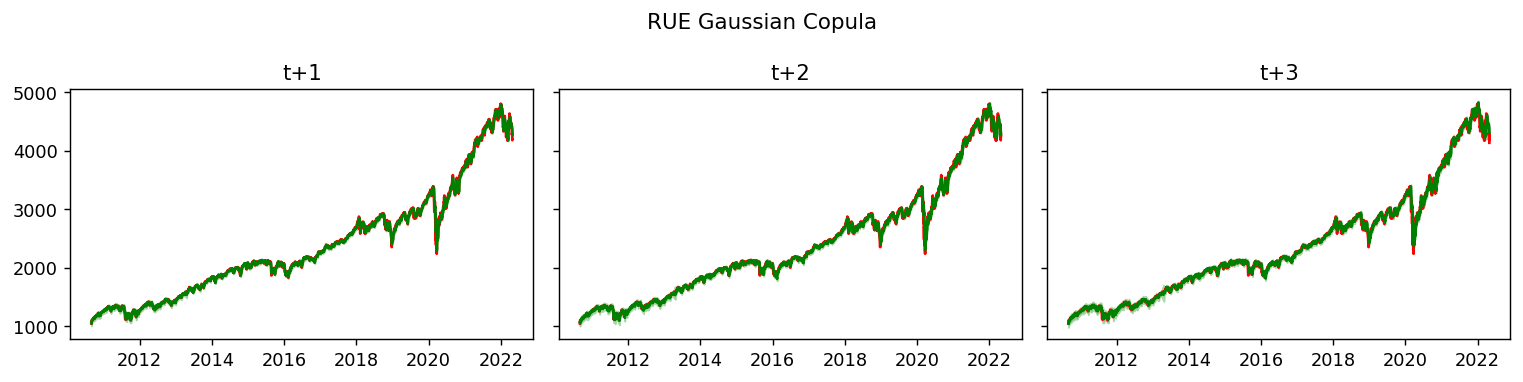

RUE Conditional Gaussian :


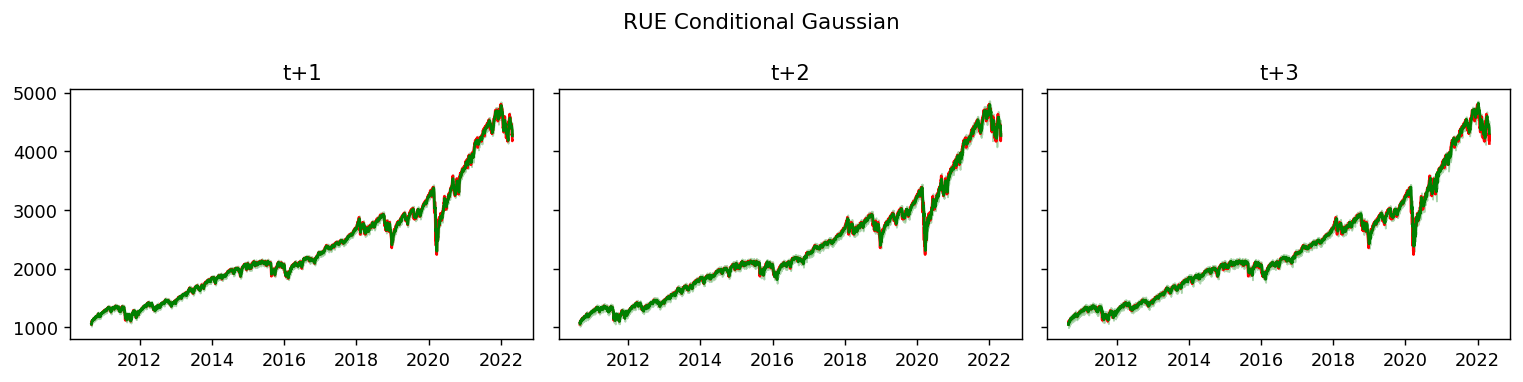

RUE Weighted :


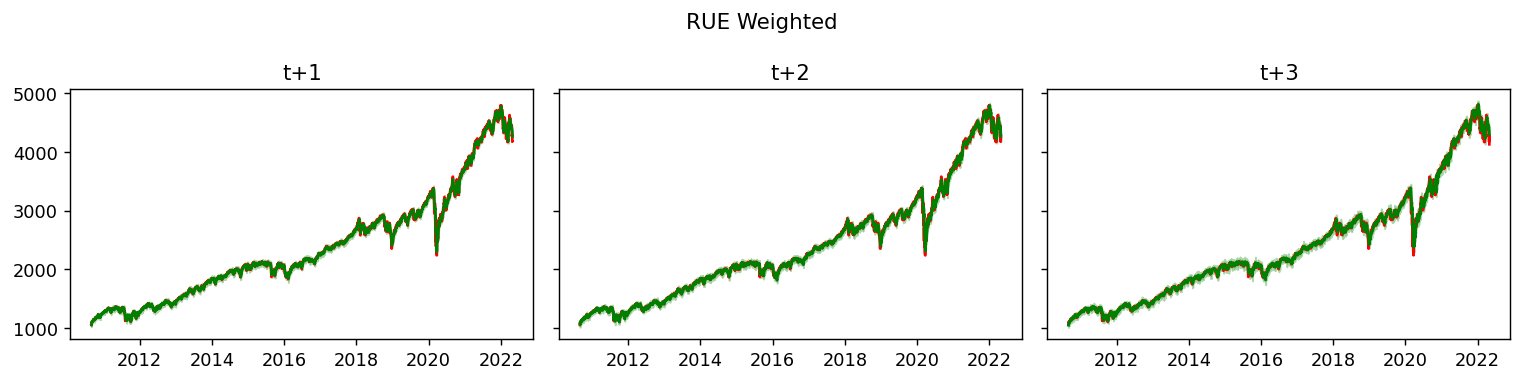

RUE KNN :


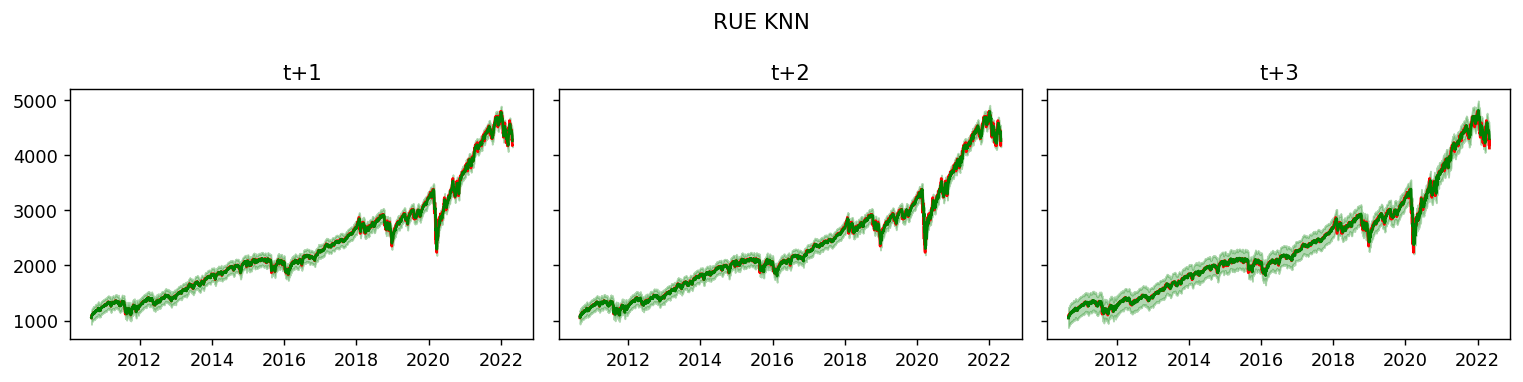

RUE Conformal :


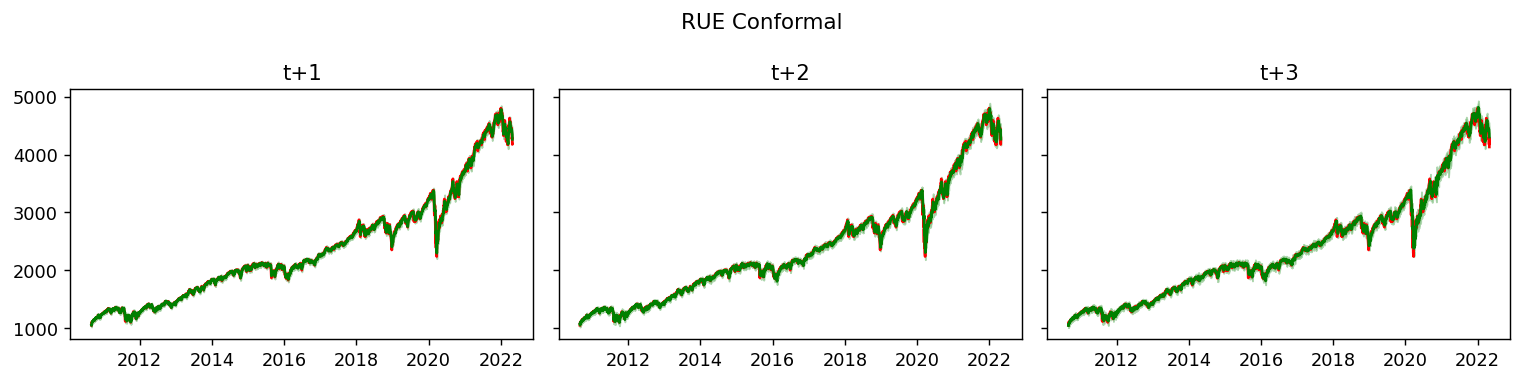

MC Dropout Conformal :


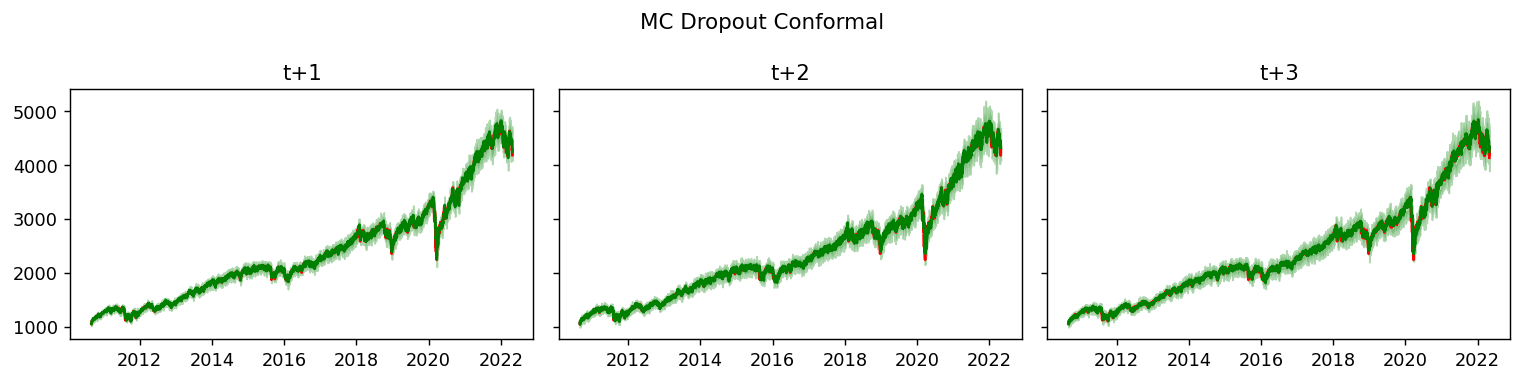

In [67]:
# function to calculate pis
plot_predictions_with_pi(df_dict, pi_dict, scaler, seed=seed, dpi=128, save_figs=False)

#### Parallel Coordinate Plot

In [62]:
def plot_pi_metrics_parallel_coordinate(pi_stats, seed, categories=["CP", "PINAW", "PINAFD"], save_fig=False):
    from matplotlib import cm
    from matplotlib.colors import rgb2hex
    import seaborn as sns
    
    pi_stats = pi_stats.copy().sort_values(by=["Time Horizon", "Method"])
    num_cat = len(categories)
    
    rue_colors = sns.color_palette('spring', n_colors=4)
    other_colors = sns.color_palette('winter', n_colors=3)
    
    # color_list =  other_colors + rue_colors
    color_list = sns.color_palette('rainbow', n_colors=pi_stats["Method"].nunique())
    print(pi_stats["Method"].unique())
    # color_list = [
    #     '#1f77b4',  # muted blue
    #     '#ff7f0e',  # safety orange
    #     '#2ca02c',  # cooked asparagus green
    #     '#d62728',  # brick red
    #     '#9467bd',  # muted purple
    #     '#8c564b',  # chestnut brown
    #     '#e377c2',  # raspberry yogurt pink
    # #     '#7f7f7f',  # middle gray
    # #     '#bcbd22',  # curry yellow-green
    # #     '#17becf'   # blue-teal
    # ]
    
    fig, axes = plt.subplots(1, num_cat, sharey=True, dpi=300, figsize=(num_cat*3, 3))
    xticks = range(num_cat)
    
    for i, (time_horizon_label, time_df) in enumerate(pi_stats.groupby("Time Horizon")):
        time_df[categories] = (time_df[categories]-time_df[categories].min())/(time_df[categories].max()-time_df[categories].min())
        for j, (method_label, method_df) in enumerate(time_df.groupby("Method")):
            # print(method_df[categories].values.flatten())
            axes[i].plot(xticks, method_df[categories].values.flatten(), label=method_label if i==0 else None, linestyle="--" if "RUE" not in method_label else "-")
            axes[i].set_xticks(xticks, categories)
        axes[i].set_title(time_horizon_label)

    reorder=lambda hl,nc:(sum((lis[i::nc]for i in range(nc)),[])for lis in hl)
    h_l = axes[0].get_legend_handles_labels()
    fig.legend(*reorder(h_l, 5), loc='upper center', bbox_to_anchor=(0.5, 0), ncol=5, fontsize=8)
    plt.tight_layout()
    if save_fig:
        fp_fig_folder = os.path.join(fp_project_model_evaluations, str(seed))
        plt.savefig(os.path.join(fp_fig_folder, "parallel_coord.jpg"), bbox_inches="tight")
    

['MC Dropout Conformal' 'RUE Conditional Gaussian' 'RUE Conformal'
 'RUE Gaussian Copula' 'RUE KNN' 'RUE Weighted']


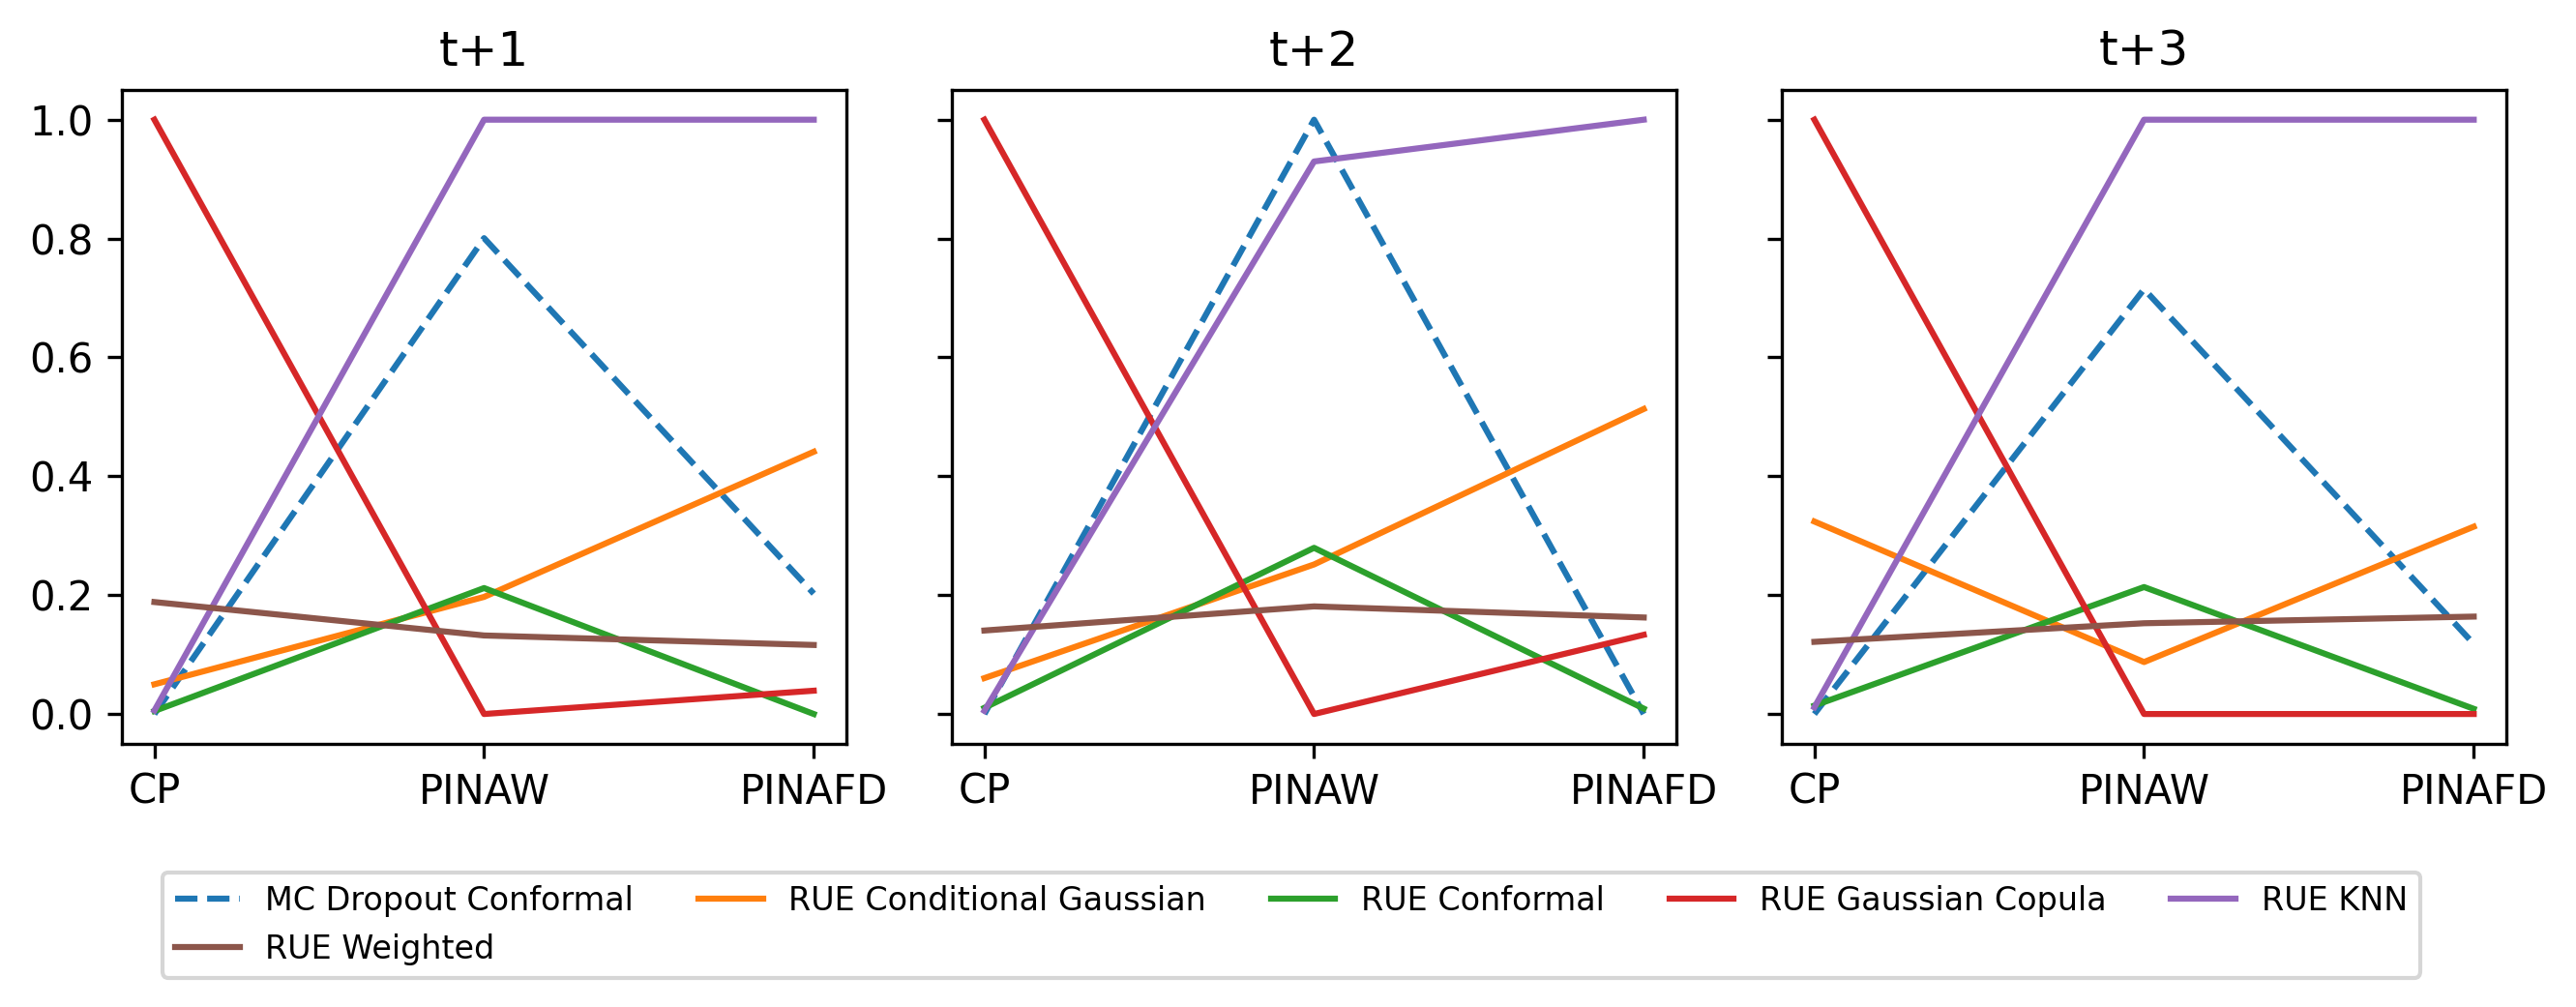

In [63]:
plot_pi_metrics_parallel_coordinate(pi_stats, seed=seed, categories=["CP", "PINAW", "PINAFD"], save_fig=True)

#### UE-Error Scatter Plot

In [68]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', pad=0, y=0.975)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

# Scatter plot of rows of t+1, t+2... t+3
# - In each row, we have the scatterplots of each UE
def get_ue_loss_scatterplot(test_df_dict, ue_dict, seed, nbins=10, dpi=300, save_fig=False):
    eqn_label_fs = 7
    line_col = 'black'
    point_color = "#0090C1"
    point_size = 75
    point_alpha = 0.5
    marker = "."
    formatting_dict = dict(color=point_color, s=point_size, alpha=point_alpha, marker=marker, edgecolors='none')
    
    bin_width = int(100/nbins)
    num_cols = len(ue_dict)
    num_rows = len(test_df_dict) # num intervals
    #, constrained_layout=True
    # fig, axes = plt.subplots(num_rows*2, num_cols, dpi=dpi, figsize=(num_cols*4, 1.5*2*num_rows)) # , sharey="row", sharex="col"
    fig = plt.figure(dpi=dpi, figsize=(num_cols*3, 2*2*num_rows))
    grid = fig.add_gridspec(num_rows, 1, height_ratios=[1 for i in range(num_rows)], hspace=0.3)
    
    # For all time intervals 
    for time_i ,(regressor_label, test_df_info) in enumerate(test_df_dict.items()):
        cur_gs = grid[time_i].subgridspec(2, num_cols, wspace=0, hspace=0.1)
        axes = cur_gs.subplots(sharey='row', sharex='col')
        test_df = test_df_info["test_df"]
        pred_cols = test_df_info["pred_cols"]
        y_true = test_df[pred_cols].values

        create_subtitle(fig, grid[time_i, ::], regressor_label)
        # For each ue 
        for ue_i, (ue_type, ue_info) in enumerate(ue_dict.items()):
            
            ue_df = test_df.copy()
            
            pred_label = ue_info["pred_label"]
            ue_col = ue_info["ue_col"]

            # Get error and UE cols
            y_pred_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
            y_pred = test_df[y_pred_cols].values
            ue = test_df[ue_col].values
            loss = np.mean(np.abs(y_true-y_pred), axis=1)
            ue_df["loss"] = loss

            # Normalise UE
            ue = min_max_norm_wo_outliers(ue)
            ue_df[ue_col] = ue
            max_range = round(max(ue), 1)
            bin_edges = np.array([0]+list(np.linspace(bin_width, int(max_range*100), num=int(max_range*10))/100))
            
            # Plot scatter
            scatter_ax = axes[0, ue_i]
            scatter_ax.axvspan(0, bin_width/100, color='grey', alpha=0.2, linewidth=0)
            scatter_ax.scatter(ue, loss, **formatting_dict)
            # Plot line
            m, c = np.polyfit(ue, loss, 1) 
            ue = np.sort(ue)
            scatter_ax.plot(ue, m*ue+c, color=line_col, linestyle='-', label=f'y = {m:.3f}x + {c:.3f}', linewidth=1.5)
            scatter_ax.legend(fontsize=eqn_label_fs)
            if ue_i == 0:
                axes[0, ue_i].set_ylabel("MAE")
                
            # Plot Barplot
            ue_df['bin'] = pd.cut(ue_df[ue_col], bins=bin_edges, labels=bin_edges[1:], include_lowest=True, right=True)
            grouped = ue_df.groupby("bin", observed=False)
            grouped_loss = grouped["loss"].mean()
            # Comparison of losses
            bar_ax = axes[1, ue_i]
            bar_ax.bar(
                bin_edges[1:]-bin_width/100/2, grouped_loss, width=bin_width/100*0.9, color="#0090C1")
            ticks = list(axes[1, ue_i].get_yticks(minor=True)) + [grouped_loss[0.1]]
            bar_ax.set_yticks(ticks, minor=True)
            if ue_i == 0:
                bar_ax.set_ylabel("Mean MAE")
            bar_ax.set_xlabel(ue_type)

    if save_fig:
        fp_fig_folder = os.path.join(fp_project_model_evaluations, str(seed))
        plt.savefig(os.path.join(fp_fig_folder, "ue_error_scatter.jpg"), bbox_inches="tight")


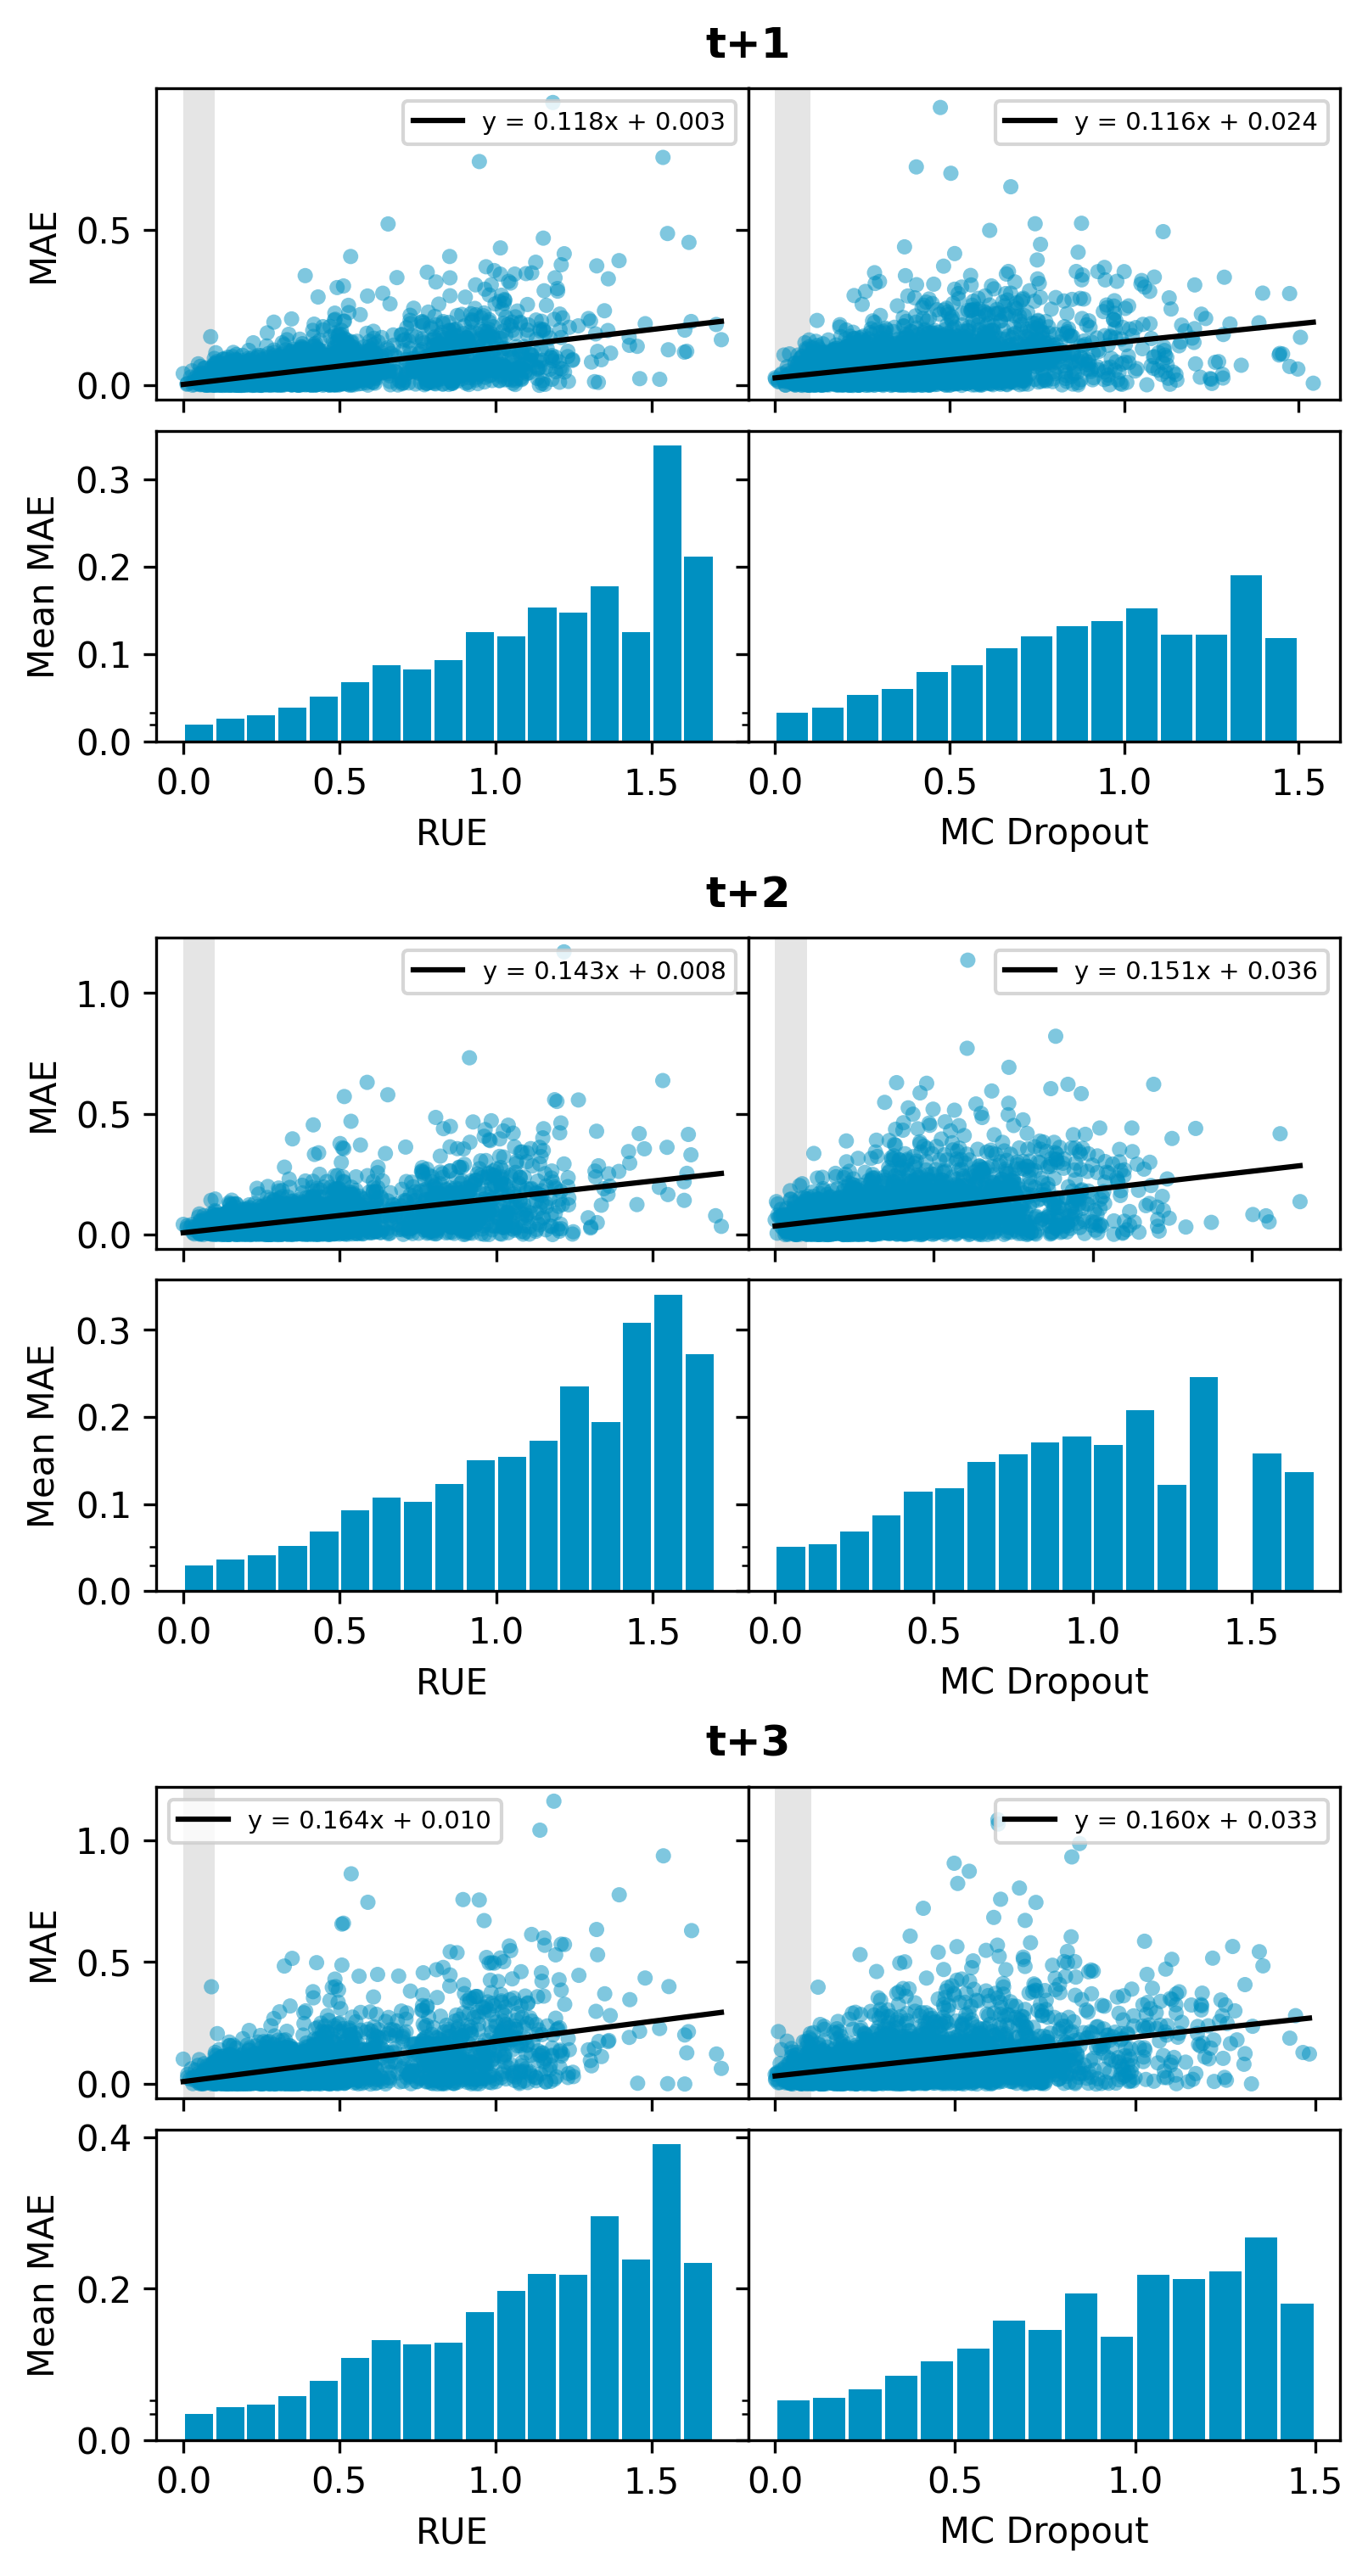

In [69]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
    # "Infer-Noise": {
    #     "pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", 
    # },
    "MC Dropout": {
        "pred_label": "_mean", "ue_col": "mcd", 
    },
    # "GPR": {
    #     "pred_label": "_gpr", "ue_col": "gpr_std_mean", 
    # },
    # "BNN": {
    #     "pred_label": "_bnn", "ue_col": "bnn_uncertainty", 
    # },
    # "DER": {
    #     "pred_label": "_der", "ue_col": "der_uncertainty", 
    # },
}    
get_ue_loss_scatterplot(df_dict, ue_dict, seed=seed, dpi=300, save_fig=True)

#### Starplot

In [ ]:
def plot_pi_metrics_starplot(pi_stats, categories=pi_stats.columns.tolist()[2:-2]):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    from plotly.colors import hex_to_rgb
    fig = make_subplots(
        rows=1, cols=pi_stats["Time Horizon"].nunique(),
        specs=[[{"type": "scatterpolar"}, {"type": "scatterpolar"}, {"type": "scatterpolar"}]], 
        subplot_titles=pi_stats["Time Horizon"].unique()
    )
    pi_stats = pi_stats.copy()
    color_list = [
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
    #     '#7f7f7f',  # middle gray
    #     '#bcbd22',  # curry yellow-green
    #     '#17becf'   # blue-teal
    ]
    
    for i, (time_horizon_label, time_df) in enumerate(pi_stats.groupby("Time Horizon")):
        # time_df[categories] = (time_df[categories]-time_df[categories].min())/(time_df[categories].max()-time_df[categories].min())
        time_df[categories] = time_df[categories]/time_df[categories].max()
        # time_df[categories] = np.log(time_df[categories])
        for j, (method_label, method_df) in enumerate(time_df.groupby("Method")):
            cur_col = list(hex_to_rgb(color_list[j]))
            cur_fill_col = f'rgba({cur_col[0]}, {cur_col[1]}, {cur_col[2]}, 0.3)'
            cur_outline_col = f'rgba({cur_col[0]}, {cur_col[1]}, {cur_col[2]}, 0.8)'
            fig.append_trace(
                go.Scatterpolar(
                      r=method_df[categories].values[0],
                      theta=categories,
                      fill='toself',
                      name=method_label if i==0 else None,
                      fillcolor=cur_fill_col,
                      marker=dict(color=cur_outline_col, line=dict(
                            color=color_list[j],
                            width=1
                        ),
                    ),
                    showlegend=i==0
                ), row=1, col=i+1
            )

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
              visible=False,
            )
        ),
        polar2=dict(
            radialaxis=dict(
              visible=False,
            )
          ),
        polar3=dict(
            radialaxis=dict(
              visible=False,
            )
      ),
      showlegend=True, 
      width=850,  
      height=350,
      title_x=0.5,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            xanchor="center",
            y=-0.5,
            x=0.5,
            entrywidth=180
        )
    )
#     fig.show()
    return fig
        
plot_pi_metrics_starplot(pi_stats, categories=pi_stats.columns.tolist()[3:-1])

## Repeat Experiment

In [ ]:
hp_seed = 2023

def train_rue_n_predictor(seed, data_dict, override_checkpoints, testing):
    # Load Best HP
    all_rue_decoder_best_hp = joblib.load(os.path.join(fp_tuning, str(hp_seed), "all_rue_decoder_best_hp.joblib"))
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            fp_model = os.path.join(fp_project_models, str(seed), f"rue_{time_label}")
            # Check if fp_model exists
            if override_checkpoints or not os.path.exists(fp_model):
                # Get best hyperparameter
                best_hp = all_rue_decoder_best_hp[time_label]
                # Train model
                ae_regressor = model_training(
                    best_hp, predictors=predictors, pred_cols=time_info_dict["outputs"], 
                    train_df=time_info_dict["train_df"], valid_df = time_info_dict["valid_df"], seed=seed,
                    batch_size=batch_size, max_epochs=10000 if not testing else 1, verbose=1, patience=20
                ) 
                # Save model
                save_model(
                    model=ae_regressor, name=f"rue_{time_label}", 
                    fp_checkpoints=os.path.join(fp_project_models, str(seed)), override=True)
            else:
                print(f"- Skip {time_label} Training")

def predict_rue_n_predictor(seed, data_dict, override_checkpoints, testing):
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            # Load model
            ae_regressor = load_model(name=f"rue_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
            # Check if we have predicted on the validation set
            fp_valid_df = os.path.join(fp_project_predictions, str(seed), f"rue_valid_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_valid_df):
                rue_valid_df = model_test_predictions(
                    ae_regressor, df_train=time_info_dict["train_df"], df_test=time_info_dict["valid_df"], 
                    pred_cols=time_info_dict["outputs"], predictors=predictors, 
                    regressor_label="_"+time_label, pred_min=int(time_label[-1]), T=10 if not testing else 1, seed=seed
                )
                rue_valid_df.to_csv(fp_valid_df)
            else:
                print(f"- Skip {time_label} Validation Prediction")
                
            # Check if we have predicted on the testing set 
            fp_test_df = os.path.join(fp_project_predictions, str(seed), f"rue_test_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_test_df):
                rue_test_df = model_test_predictions(
                    ae_regressor, df_train=time_info_dict["train_df"], df_test=time_info_dict["test_df"], 
                    pred_cols=time_info_dict["outputs"], predictors=predictors, 
                    regressor_label="_"+time_label, pred_min=int(time_label[-1]), T=10 if not testing else 1, seed=seed
                )
                rue_test_df.to_csv(fp_test_df)
            else:
                print(f"- Skip {time_label} Testing Prediction")
            
def train_gpr(seed, data_dict, override_checkpoints, testing):
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            fp_model = os.path.join(fp_project_models, str(seed), f"gpr_{time_label[-1]}")
            # Check if fp_model exists
            if override_checkpoints or not os.path.exists(fp_model):
                # Train model
                gpr = model_training_gpr( 
                    predictors=predictors, pred_cols=time_info_dict["outputs"], 
                    train_df=time_info_dict["train_df"], valid_df = time_info_dict["valid_df"], seed=seed
                ) 
                # Save model
                save_model_gpr(model=gpr, name=f"gpr_{time_label[-1]}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
            else:
                print(f"- Skip {time_label} Training")

def predict_gpr(seed, data_dict, override_checkpoints, testing):
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            gpr = load_model_gpr(name=f"gpr_{time_label[-1]}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
            # Check if we have predicted on the validation set
            fp_valid_df = os.path.join(fp_project_predictions, str(seed), f"gpr_valid_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_valid_df):
                gpr_valid_df = model_test_predictions_gpr(
                    gpr=gpr, df_test=time_info_dict["valid_df"], pred_cols=time_info_dict["outputs"], 
                    predictors=predictors, regressor_label=f"_{time_label}", pred_min=int(time_label[-1]), seed=seed)
                gpr_valid_df.to_csv(fp_valid_df)
            else:
                print(f"- Skip {time_label} Validation Prediction")
                
            # Check if we have predicted on the testing set
            fp_test_df = os.path.join(fp_project_predictions, str(seed), f"gpr_test_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_test_df):
                gpr_test_df = model_test_predictions_gpr(
                    gpr=gpr, df_test=time_info_dict["test_df"], pred_cols=time_info_dict["outputs"], 
                    predictors=predictors, regressor_label=f"_{time_label}", pred_min=int(time_label[-1]), seed=seed)
                gpr_test_df.to_csv(fp_test_df)
            else:
                print(f"- Skip {time_label} Testing Prediction")    
                
def predict_infernoise(seed, data_dict, override_checkpoints, testing):
    # Load best hp for infernoise
    infernoise_hp_dict = joblib.load(os.path.join(fp_tuning, str(hp_seed), "all_infernoise_best_hp.joblib"))
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            # Load model
            ae_regressor = load_model(name=f"rue_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
            # Check if we have predicted on the validation set
            fp_valid_df = os.path.join(fp_project_predictions, str(seed), f"infernoise_valid_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_valid_df):
                infernoise_valid_df = infernoise_test_predictions(
                     ae_regressor, test_df=time_info_dict["valid_df"], inputs=predictors, outputs=time_info_dict["outputs"], regressor_label="_"+time_label, 
                     seed=seed, T=10 if not testing else 1, stddev=infernoise_hp_dict[time_label]
                ) 
                infernoise_valid_df.to_csv(fp_valid_df)
            else:
                print(f"- Skip {time_label} Validation Prediction")
                
            # Check if we have predicted on the testing set
            fp_test_df = os.path.join(fp_project_predictions, str(seed), f"infernoise_test_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_test_df):
                infernoise_test_df = infernoise_test_predictions(
                     ae_regressor, test_df=time_info_dict["test_df"], inputs=predictors, outputs=time_info_dict["outputs"], regressor_label="_"+time_label, 
                     seed=seed, T=10 if not testing else 1, stddev=infernoise_hp_dict[time_label]
                ) 
                infernoise_test_df.to_csv(fp_test_df)
            else:
                print(f"- Skip {time_label} Testing Prediction")    

def train_bnn(seed, data_dict, override_checkpoints, testing):
    # Load Best HP
    all_bnn_best_hp = joblib.load(os.path.join(fp_tuning, str(hp_seed), "all_bnn_best_hp.joblib"))
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            fp_model = os.path.join(fp_project_models, str(seed), f"bnn_{time_label}.pt")
            # Check if fp_model exists
            if override_checkpoints or not os.path.exists(fp_model):
                # Get best hyperparameter
                bnn_best_hp = all_bnn_best_hp[time_label]
                # Train model
                bnn_model = train_model_w_best_param(
                    best_param=bnn_best_hp, train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
                    feat_cols=predictors, target_cols=time_info_dict["outputs"],
                    epochs=500 if not testing else 1, patience=5, seed=seed, fp_model=fp_model
                )
            else:
                print(f"- Skip {time_label} Training")

def predict_bnn(seed, data_dict, override_checkpoints, testing):
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            # Load model
            fp_model = os.path.join(fp_project_models, str(seed), f"bnn_{time_label}.pt")
            bnn_model = torch.load(fp_model)
            # Check if we have predicted on the validation set
            fp_valid_df = os.path.join(fp_project_predictions, str(seed), f"bnn_valid_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_valid_df):
                bnn_valid_df = bnn_model_prediction(
                    bnn_model, time_info_dict["valid_df"], 
                    feat_cols=predictors, target_cols=time_info_dict["outputs"], 
                    T=10 if not testing else 1, seed=seed, regressor_label=time_label)
                bnn_valid_df.to_csv(fp_valid_df)
            else:
                print(f"- Skip {time_label} Validation Prediction")
                
            # Check if we have predicted on the testing set 
            fp_test_df = os.path.join(fp_project_predictions, str(seed), f"bnn_test_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_test_df):
                bnn_test_df = bnn_model_prediction(
                    bnn_model, time_info_dict["test_df"], 
                    feat_cols=predictors, target_cols=time_info_dict["outputs"], 
                    T=10 if not testing else 1, seed=seed, regressor_label=time_label)
                bnn_test_df.to_csv(fp_test_df)
            else:
                print(f"- Skip {time_label} Testing Prediction")

def train_der(seed, data_dict, override_checkpoints, testing):
    # Load Best HP
    all_der_best_hp = joblib.load(os.path.join(fp_tuning, str(hp_seed), "all_der_best_hp.joblib"))
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            fp_model = os.path.join(fp_project_models, str(seed), f"der_{time_label}.pt")
            # Check if fp_model exists
            if override_checkpoints or not os.path.exists(fp_model):
                # Get best hyperparameter
                best_hp = all_der_best_hp[time_label]
                # Train model
                der_model, _ = train_der_w_param(
                    **best_hp, train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
                    inputs=predictors, outputs=time_info_dict["outputs"],
                    seed=seed, max_epochs= 500 if not testing else 1, patience=5
                )
                torch.save(der_model, fp_model)
            else:
                print(f"- Skip {time_label} Training")

def predict_der(seed, data_dict, override_checkpoints, testing):
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            # Load model
            fp_model = os.path.join(fp_project_models, str(seed), f"der_{time_label}.pt")
            der_model = torch.load(fp_model)
            # Check if we have predicted on the validation set
            fp_valid_df = os.path.join(fp_project_predictions, str(seed), f"der_valid_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_valid_df):
                der_valid_df = der_model_prediction(
                    der_model, test_df=time_info_dict["valid_df"], 
                    feat_cols=predictors, target_cols=time_info_dict["outputs"], 
                    seed=seed, silent=False, regressor_label=time_label)
                der_valid_df.to_csv(fp_valid_df)
            else:
                print(f"- Skip {time_label} Validation Prediction")
                
            # Check if we have predicted on the testing set 
            fp_test_df = os.path.join(fp_project_predictions, str(seed), f"der_test_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_test_df):
                der_test_df = der_model_prediction(
                    der_model, test_df=time_info_dict["test_df"], 
                    feat_cols=predictors, target_cols=time_info_dict["outputs"], 
                    seed=seed, silent=False, regressor_label=time_label)
                der_test_df.to_csv(fp_test_df)
            else:
                print(f"- Skip {time_label} Testing Prediction")
                
def save_df_dict_fast(df_dict, seed):
    fp_df_dict = os.path.join(fp_project_pi_predictions, str(seed), "df_dict.joblib")
    joblib.dump(df_dict, fp_df_dict)

def load_df_dict_fast( seed):
    fp_df_dict = os.path.join(fp_project_pi_predictions, str(seed), "df_dict.joblib")
    return joblib.load(fp_df_dict)

def retrieve_history_file(seed):
    fp_history = os.path.join(fp_project_pi_predictions, str(seed), "df_dict_history.joblib")
    if os.path.exists(fp_history):
        return joblib.load(fp_history)
    else:
        return []

def add_to_pi_history_file(event, seed):
    fp_history = os.path.join(fp_project_pi_predictions, str(seed), "df_dict_history.joblib")
    if not os.path.exists(fp_history):
        history = set(event)
    else:
        history = joblib.load(fp_history)
        history.add(event)
    joblib.dump(history, fp_history)
    
def create_df_dict(seed, data_dict, override_checkpoints, testing):
    event = "creation"
    history = retrieve_history_file(seed)
    if (override_checkpoints) or (event not in history):
        df_dict = {}
        with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
            for time_label, time_info_dict in pbar:
                df_dict[time_label] = {
                    "valid_df": load_all_predictions(time_label=int(time_label[-1]), split="valid", seed=seed),
                    "test_df": load_all_predictions(time_label=int(time_label[-1]), split="test", seed=seed),
                    "pred_cols": time_info_dict["outputs"]
                }
        save_df_dict_fast(df_dict, seed)
        add_to_pi_history_file(event, seed)
    else:
        print(f"- Skip df_dict creation!")

def generate_prediction_interval(seed, data_dict, override_checkpoints, testing, 
                                 event, pi_func, ue_dict):
    history = retrieve_history_file(seed)
    if (override_checkpoints) or (event not in history):
        df_dict = load_df_dict_fast(seed)
        scaler = load_scaler(fp_downsampled_scaler_file)
        for time_label, time_info in df_dict.items():
            val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
            for ue_label, ue_info in ue_dict.items():
                pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
                df_dict[time_label]["test_df"] = pi_func(
                    df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=predictors, pred_cols=pred_cols, 
                    pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler, seed=seed
                )
        save_df_dict_fast(df_dict, seed)
        add_to_pi_history_file(event, seed)
    else:
        print(f"- Skip {event} PI!")

def generate_knn_pi(seed, data_dict, override_checkpoints, testing):
    ue_dict = {"RUE": {"pred_label": "_direct", "ue_col": "rue"}} 
    generate_prediction_interval(
        seed, data_dict, override_checkpoints, testing, 
        event="knn", pi_func=knn_prediction_interval, ue_dict=ue_dict)

def generate_weighted_pi(seed, data_dict, override_checkpoints, testing):
    ue_dict = {"RUE": {"pred_label": "_direct", "ue_col": "rue"}} 
    generate_prediction_interval(
        seed, data_dict, override_checkpoints, testing, 
        event="weighted", pi_func=weighted_prediction_interval, ue_dict=ue_dict)

def generate_conditional_pi(seed, data_dict, override_checkpoints, testing):
    ue_dict = {"RUE": {"pred_label": "_direct", "ue_col": "rue"}} 
    generate_prediction_interval(
        seed, data_dict, override_checkpoints, testing, 
        event="conditional", pi_func=cond_gauss_prediction_interval, ue_dict=ue_dict)

def generate_copula_pi(seed, data_dict, override_checkpoints, testing):
    ue_dict = {"RUE": {"pred_label": "_direct", "ue_col": "rue"}} 
    generate_prediction_interval(
        seed, data_dict, override_checkpoints, testing, 
        event="copula", pi_func=gauss_copula_prediction_interval, ue_dict=ue_dict)

def generate_conformal_pi(seed, data_dict, override_checkpoints, testing):
    ue_dict = {
        "RUE": {"pred_label": "_direct", "ue_col": "rue"},
        "MC Dropout": {"pred_label": "_mean", "ue_col": "mcd", },
        "GPR": {"pred_label": "_gpr", "ue_col": "gpr_std_mean", },
        "Infer-Noise": {"pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", },
        "BNN": {"pred_label": "_bnn", "ue_col": "bnn_uncertainty", },
        "DER": {"pred_label": "_der", "ue_col": "der_uncertainty", }
    }   
    generate_prediction_interval(
        seed, data_dict, override_checkpoints, testing, 
        event="conformal", pi_func=conformal_prediction_interval, ue_dict=ue_dict)

def evaluate_model_perf(seed, data_dict, override_checkpoints, testing):
    df_dict = load_df_dict_fast(seed)
    ue_dict = {
        "RUE": {"pred_label": "_direct", "ue_col": "rue"},
        "MC Dropout": {"pred_label": "_mean", "ue_col": "mcd", },
        "GPR": {"pred_label": "_gpr", "ue_col": "gpr_std_mean", },
        "Infer-Noise": {"pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", },
        "BNN": {"pred_label": "_bnn", "ue_col": "bnn_uncertainty", },
        "DER": {"pred_label": "_der", "ue_col": "der_uncertainty", }
    }   
    fp_pred_perf = os.path.join(fp_project_model_evaluations, str(seed), "pred_perf.csv")
    if override_checkpoints or not os.path.exists(fp_pred_perf):
        pred_perf_df = get_prediction_performance_table(df_dict, ue_dict)
        display(pred_perf_df)
        pred_perf_df.to_csv(fp_pred_perf)
    else:
        print(f"- Skip prediction performance evaluation!")

def evaluate_ue_perf(seed, data_dict, override_checkpoints, testing):
    df_dict = load_df_dict_fast(seed)
    ue_dict = {
        "RUE": {"pred_label": "_direct", "ue_col": "rue"},
        "MC Dropout": {"pred_label": "_mean", "ue_col": "mcd", },
        "GPR": {"pred_label": "_gpr", "ue_col": "gpr_std_mean", },
        "Infer-Noise": {"pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", },
        "BNN": {"pred_label": "_bnn", "ue_col": "bnn_uncertainty", },
        "DER": {"pred_label": "_der", "ue_col": "der_uncertainty", }
    }   
    fp_ue_perf = os.path.join(fp_project_model_evaluations, str(seed), "ue_perf.csv")
    if override_checkpoints or not os.path.exists(fp_ue_perf):
        ue_perf_df = get_ue_performance_table(df_dict, ue_dict)
        display(ue_perf_df)
        ue_perf_df.to_csv(fp_ue_perf)
    else:
        print(f"- Skip UE performance evaluation!")

    fp_ue_scatter = os.path.join(fp_project_model_evaluations, str(seed), "ue_error_scatter.jpg")
    if override_checkpoints or not os.path.exists(fp_ue_scatter):
        get_ue_loss_scatterplot(df_dict, ue_dict, seed=seed, dpi=300, save_fig=True)
    else:
        print(f"- Skip UE-Error Scatter Plot!")

def evaluate_pi_perf(seed, data_dict, override_checkpoints, testing):
    override_checkpoints = True
    df_dict = load_df_dict_fast(seed)
    scaler = load_scaler(fp_downsampled_scaler_file)
    pi_dict = {
        "RUE Gaussian Copula": {"pred_label": "_direct", "ue_col": "rue", "pi_label": "_gauss_copula"},
        "RUE Conditional Gaussian": {"pred_label": "_direct", "ue_col": "rue", "pi_label": "_cond_gauss"},
        "RUE Weighted": {"pred_label": "_direct", "ue_col": "rue", "pi_label": "_weighted"},
        "RUE KNN": {"pred_label": "_direct", "ue_col": "rue", "pi_label": "_knn"},
        "RUE Conformal": {"pred_label": "_direct", "ue_col": "rue", "pi_label": "_conformal"},
        "Infer-Noise Conformal": {"pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", "pi_label": "_conformal"},
        "MC Dropout Conformal": {"pred_label": "_mean", "ue_col": "mcd", "pi_label": "_conformal"},
        "GPR Conformal": {"pred_label": "_gpr", "ue_col": "gpr_std_mean", "pi_label": "_conformal"},
        "BNN Conformal": {"pred_label": "_bnn", "ue_col": "bnn_uncertainty", "pi_label": "_conformal"},
        "DER Conformal": {"pred_label": "_der", "ue_col": "der_uncertainty", "pi_label": "_conformal"},
    }   
    fp_pi_perf = os.path.join(fp_project_model_evaluations, str(seed), "pi_perf.csv")
    if override_checkpoints or not os.path.exists(fp_pi_perf):
        pi_perf_df = calculate_metrics(df_dict, pi_dict)
        display(pi_perf_df)
        pi_perf_df.to_csv(fp_pi_perf)
    else:
        pi_perf_df = pd.read_csv(fp_pi_perf, index_col=0)
        print(f"- Skip PI performance evaluation!")

    fp_pi_folder = os.path.join(fp_project_model_evaluations, str(seed), "pi_line_graphs")
    if override_checkpoints or not os.path.exists(fp_pi_folder):
        plot_predictions_with_pi(df_dict, pi_dict, scaler, seed=seed, dpi=300, save_figs=True)
    else:
        print(f"- Skip PI Line Plots!")

    fp_pi_parallel_coord = os.path.join(fp_project_model_evaluations, str(seed), "parallel_coord.jpg")
    if override_checkpoints or not os.path.exists(fp_pi_parallel_coord):
        plot_pi_metrics_parallel_coordinate(pi_perf_df, seed=seed, categories=["CP", "PINAW", "PINAFD"], save_fig=True)
    else:
        print(f"- Skip PI Parallel Coordinates Plot!")
    
def run_one_experiment(seed, override_checkpoints=False, testing=False):
    data_dict = {
        "t+1": {"train_df": df_train_1, "valid_df": df_valid_1, "test_df": df_test_1, "outputs": pred_cols_1},
        "t+2": {"train_df": df_train_2, "valid_df": df_valid_2, "test_df": df_test_2, "outputs": pred_cols_2},
        "t+3": {"train_df": df_train_3, "valid_df": df_valid_3, "test_df": df_test_3, "outputs": pred_cols_3},
    }
    checkpoint_dict = {
        "Train RUE and Predictor": train_rue_n_predictor,
        "Prediction with RUE and Predictor": predict_rue_n_predictor,
        "Prediction with Infer-Noise": predict_infernoise,
        "Train GPR": train_gpr,
        "Prediction with GPR": predict_gpr,
        "Train BNN": train_bnn, 
        "Prediction with BNN": predict_bnn, 
        "Train DER": train_der, # <-
        "Prediction with DER": predict_der,
        "Create DF Dict": create_df_dict,
        "Generate KNN PI":generate_knn_pi,
        "Generate Weighted PI": generate_weighted_pi,
        "Generate Conditional PI": generate_conditional_pi,
        "Generate Copula PI": generate_copula_pi,
        "Generate Conformal PI": generate_conformal_pi,
        "Evaluate Model Performance": evaluate_model_perf,
        "Evaluate UE Performance": evaluate_ue_perf,
        "Evaluate PI Performance": evaluate_pi_perf
    }
    create_all_seed_folders(seed)
    for i, (checkpoint_name, checkpoint_func) in enumerate(checkpoint_dict.items()):
        print(f"{i+1}. {checkpoint_name}")
        start = time.time()
        checkpoint_func(seed, data_dict, override_checkpoints, testing)
        print(f"- {checkpoint_name} took {time.time()-start} s.")

def run_multiple_experiments(seed_list, override_checkpoints=False, testing=False):
    with tqdm(seed_list, total=len(seed_list)) as pbar:
        for seed in pbar:
            pbar.set_description(str(seed))
            run_one_experiment(seed, override_checkpoints, testing)

start_seed = 2024
num_experiments = 4
seed_list = range(start_seed, start_seed+num_experiments)
run_multiple_experiments(seed_list, override_checkpoints=False, testing=False)

### Analyse Results

In [ ]:
seed_list=list(range(2023, 2023+5))
def combine_mean_n_std_matrices(mean, std):
    assert mean.shape == std.shape
    shape = mean.shape
    returned_list = []
    for i in range(shape[0]):
        cur_list = []
        for j in range(shape[1]):
            cur_list.append(f"{mean[i][j]:.3f} ± {std[i][j]:.3f}")
        returned_list.append(cur_list)
    return returned_list

def get_average_of_all_seed_csvs(seed_list, fp_folder, filename, index_col=None):
    result_list = []
    for cur_seed in seed_list:
        fp_perf = os.path.join(fp_folder, str(cur_seed), filename)
        df = pd.read_csv(fp_perf, index_col=0)
        if index_col:
            df = df.set_index(index_col)
        result_list.append(df.values)
    results = np.array(result_list)
    combined_mean = np.mean(results, axis=0)
    combined_std = np.std(results, axis=0)
    return pd.DataFrame(
        combine_mean_n_std_matrices(combined_mean, combined_std), 
        index=df.index, columns=df.columns)

def get_mean_of_all_seed_csvs(seed_list, fp_folder, filename, index_col=None):
    result_list = []
    for cur_seed in seed_list:
        fp_perf = os.path.join(fp_folder, str(cur_seed), filename)
        df = pd.read_csv(fp_perf, index_col=0)
        if index_col:
            df = df.set_index(index_col)
        result_list.append(df.values)
    results = np.array(result_list)
    combined_mean = np.mean(results, axis=0)
    return pd.DataFrame(
        combined_mean, 
        index=df.index, columns=df.columns)

best_color = "#88E7B8"
second_best_color = "#FAC05E"

# Function to highlight most and second highest
def highlight_first_n_second_highest(s):
    s = s.map(lambda x: float(x.split(" ")[0]))
    highest = s.nlargest(1).iloc[-1] # Find the highest value
    second_highest = s.nlargest(2).iloc[-1]  # Find the second highest value
    output = []
    for v in s:
        if v == highest:
            output.append(f'background-color: {best_color}')
        elif v == second_highest:
            output.append(f'background-color: {second_best_color}')
        else:
            output.append("")
    return output

def highlight_first_n_second_lowest(s):
    s = s.map(lambda x: float(x.split(" ")[0]))
    smallest = s.nsmallest(1).iloc[-1] # Find the highest value
    second_smallest = s.nsmallest(2).iloc[-1]  # Find the second highest value
    output = []
    for v in s:
        if v == smallest:
            output.append(f'background-color: {best_color}')
        elif v == second_smallest:
            output.append(f'background-color: {second_best_color}')
        else:
            output.append("")
    return output

#### Prediction Performance

In [ ]:
def get_consolidated_pred_perf(seed_list):
    return get_average_of_all_seed_csvs(seed_list, fp_project_model_evaluations, filename="pred_perf.csv", index_col="Model")

def display_consolidated_pred_perf(pred_perf_df):
    display(pred_perf_df.style.apply(highlight_first_n_second_lowest))

pred_perf_df = get_consolidated_pred_perf(seed_list)
# display(pred_perf_df)
display_consolidated_pred_perf(pred_perf_df)
pred_perf_df.to_csv(os.path.join(fp_project_consolidated_results, "pred_perf.csv"))

In [ ]:
# Function to bold the best
def bold_best(s, direction):
    s = s.map(lambda x: float(x.replace(r"\underline{", "").replace("}", "").split(" ")[0]))
    if direction == "max":
        best = s.nlargest(1).iloc[-1] # Find the best
    elif direction == "min":
        best = s.nsmallest(1).iloc[-1] # Find the best
    else:
        raise Exception(f"Invalid direction {direction}!")
    
    output = []
    for v in s:
        if v == best:
            output.append("textbf:--rwrap;")
        else:
            output.append("")
    return output

# Function to underline the second best
def underline_second_best(s, direction):
    ori_s = s.copy()
    s = s.map(lambda x: float(x.split(" ")[0]))
    if direction == "max":
        second_best = s.nlargest(2).iloc[-1]  # Find the second best
    elif direction == "min":
        second_best = s.nsmallest(2).iloc[-1]  # Find the second best
    else:
        raise Exception(f"Invalid direction {direction}!")
    
    output = []
    for ori_v, v in zip(ori_s, s):
        if v == second_best:
            output.append(r'\underline{'+ori_v+'}')
        else:
            output.append(ori_v)
    return output

def df_to_latex(df, column_format_dict):
    df = df.copy()
    for col, direction in column_format_dict.items():
        df[col] = underline_second_best(df[col], direction)
    styler = df.style
    # Bold column names
    styler.map_index(lambda v: "textbf:--rwrap;", axis="columns")
    # Bold best
    for col, direction in column_format_dict.items():
        styler.apply(bold_best, subset=[col], direction=direction)
    return styler.to_latex(column_format='c'*(df.shape[1]+df.index.nlevels))

print(df_to_latex(pred_perf_df, column_format_dict={"t+1": "min", "t+2": "min", "t+3": "min"}))

#### UE Performance

In [ ]:
def get_consolidated_ue_perf(seed_list):
    return get_average_of_all_seed_csvs(seed_list, fp_project_model_evaluations, filename="ue_perf.csv", index_col="Model")

ue_perf_df = get_consolidated_ue_perf(seed_list)
display(ue_perf_df)
ue_perf_df.to_csv(os.path.join(fp_project_consolidated_results, "ue_perf.csv"))

In [ ]:
def display_consolidated_ue_perf(ue_perf_df):
    ue_perf_df = ue_perf_df.copy()
    # Split df into time label
    num_time, num_metrics = 3, 7
    for i in range(num_time):
        print(f"t+{i}:")
        column_indices = list(range(i*num_metrics, (i+1)*num_metrics))
        cur_df = ue_perf_df.iloc[:,column_indices]
        cur_df.columns = cur_df.columns.str.split(" ").str[-1] # remove time label from column names
        display(
            cur_df.style.apply(
                highlight_first_n_second_highest, subset=cur_df.columns[0]).apply(
                    highlight_first_n_second_lowest, subset=cur_df.columns[2:]
                )
        )
        
display_consolidated_ue_perf(ue_perf_df)

In [ ]:
# Function to bold the best
def bold_best_grouped(s, direction):
    s = s.map(lambda x: float(x.replace(r"\underline{", "").replace("}", "").split(" ")[0]))
    if direction == "max":
        best = s.nlargest(1).iloc[-1] # Find the best
    elif direction == "min":
        best = s.nsmallest(1).iloc[-1] # Find the best
    else:
        raise Exception(f"Invalid direction {direction}!")
    
    output = []
    for v in s:
        if v == best:
            output.append("textbf:--rwrap;")
        else:
            output.append("")
    return output

# Function to underline the second best
def bold_best_underline_second_best_grouped(s, direction, group_col):
    s = s.copy()
    output = []
    for group_name, group_s in s.groupby(level=group_col):
        ori_group_s = group_s.copy()
        group_s = group_s.map(lambda x: float(x.split(" ")[0]))
        if direction == "max":
            best = group_s.nlargest(1).iloc[-1] # Find the best
            second_best = group_s.nlargest(2).iloc[-1]  # Find the second best
        elif direction == "min":
            best = group_s.nsmallest(1).iloc[-1] # Find the best
            second_best = group_s.nsmallest(2).iloc[-1]  # Find the second best
        else:
            raise Exception(f"Invalid direction {direction}!")
        for ori_v, v in zip(ori_group_s, group_s):
            if v == best:
                output.append(r'\textbf{'+ori_v+'}')
            elif v == second_best:
                output.append(r'\underline{'+ori_v+'}')
            else:
                output.append(ori_v)
    return output

def ue_perf_to_latex(ue_perf_df):
    # TODO: Groupby + df to latex
    ue_perf_df = ue_perf_df.copy()
    
    # Split df into time label
    num_time, num_metrics = 3, 7
    all_dfs = []
    for i in range(num_time):
        print()
        column_indices = list(range(i*num_metrics, (i+1)*num_metrics))
        cur_df = ue_perf_df.iloc[:,column_indices]
        cur_df.columns = cur_df.columns.str.split(" ").str[-1] # remove time label from column names
        cur_df.loc[:,"Time Horizon"] = f"t+{i}"
        all_dfs.append(cur_df)
    all_dfs = pd.concat(all_dfs)
    all_dfs = all_dfs.reset_index().set_index(["Time Horizon", "Model"])
    column_format_dict={"Corr": "max", "AURC":"min", "Sigma=0.1": "min", "Sigma=0.2": "min", "Sigma=0.3": "min", "Sigma=0.4": "min"}
    for col, direction in column_format_dict.items():
        all_dfs[col] = bold_best_underline_second_best_grouped(all_dfs[col], direction , group_col="Time Horizon")
    
    return all_dfs.to_latex(column_format='c'*(all_dfs.shape[1]+all_dfs.index.nlevels))
print(ue_perf_to_latex(ue_perf_df))

#### PI Performance

In [ ]:
def get_consolidated_pi_perf(seed_list):
    return get_average_of_all_seed_csvs(seed_list, fp_project_model_evaluations, filename="pi_perf.csv", index_col=["Time Horizon","Method"])

pi_perf_df = get_consolidated_pi_perf(seed_list)
display(pi_perf_df)
pi_perf_df.to_csv(os.path.join(fp_project_consolidated_results, "pi_perf.csv"))

In [ ]:
def plot_pi_mean_metrics_parallel_coordinate(seed_list, categories=["CP", "PINAW", "PINAFD"], save_fig=False):
    from matplotlib import cm
    from matplotlib.colors import rgb2hex
    import seaborn as sns

    pi_stats = get_mean_of_all_seed_csvs(seed_list, fp_project_model_evaluations, filename="pi_perf.csv", index_col=["Time Horizon","Method"]).reset_index()
    
    pi_stats = pi_stats.copy().sort_values(by=["Time Horizon", "Method"])
    num_cat = len(categories)
    
    rue_colors = sns.color_palette('spring', n_colors=4)
    other_colors = sns.color_palette('winter', n_colors=3)
    color_list = sns.color_palette('rainbow', n_colors=pi_stats["Method"].nunique())

    fig, axes = plt.subplots(1, num_cat, sharey=True, dpi=300, figsize=(num_cat*3, 3))
    xticks = range(num_cat)
    
    for i, (time_horizon_label, time_df) in enumerate(pi_stats.groupby("Time Horizon")):
        time_df[categories] = (time_df[categories]-time_df[categories].min())/(time_df[categories].max()-time_df[categories].min())
        for j, (method_label, method_df) in enumerate(time_df.groupby("Method")):
            # print(method_df[categories].values.flatten())
            axes[i].plot(xticks, method_df[categories].values.flatten(), label=method_label if i==0 else None, linestyle="--" if "RUE" not in method_label else "-")
            axes[i].set_xticks(xticks, categories)
        axes[i].set_title(time_horizon_label)

    reorder=lambda hl,nc:(sum((lis[i::nc]for i in range(nc)),[])for lis in hl)
    h_l = axes[0].get_legend_handles_labels()
    fig.legend(*reorder(h_l, 5), loc='upper center', bbox_to_anchor=(0.5, 0), ncol=5, fontsize=8)
    plt.tight_layout()
    if save_fig:
        plt.savefig(os.path.join(fp_project_consolidated_results, "parallel_coord.jpg"), bbox_inches="tight")

In [ ]:
plot_pi_mean_metrics_parallel_coordinate(seed_list, save_fig=True)

#### Runtime

In [ ]:
def analyse_runtime():
    categories = ["Training", "Predicting", "PI"]
    time_df = pd.read_csv(fp_time_log, header=None)
    time_df.columns = ["Seed", "Description", "Time/s"]
    time_df = time_df.drop_duplicates(keep="last")
    time_series = time_df.groupby(by=["Description"])["Time/s"].mean()
    category_values = [category for op in time_series.index for category in categories if category in op]
    output_df = pd.DataFrame({"Category": category_values, "Operation":time_series.index, "Time/s": time_series.values})
    return output_df.sort_values(by=["Category", "Time/s"]).set_index(["Category", "Operation"])

runtime_df = analyse_runtime()
display(runtime_df)
runtime_df.to_csv(os.path.join(fp_project_consolidated_results, "runtime.csv"))